* קובץ ראשון של ניסיון עבודה עם tensorflow
* 1- הורדת ערכים חורגים על מנת לנסות להתיחס רק למידע רלוונטי- אבדוק את ההשפעה של זה גם על שאר המודלים
* 2- נירמול הנתונים על מנת שאף נתון לא יקבל משקל גבוה מידי
* 3- הפיכת ערכי הדיאגנוזה מאותיות למספרים
* 4- בניית המודל- ערכי הייפר פרמטר כרגע הם סתם ערכים שלקחתי מדוגמא השלב הבא יהיה לבדוק איך שינוי שלהם יביא לתוצאה אידיאלית
* הערה- יש שימוש ב3 קבוצות של נתונים קבוצת אימון, קבוצת בקרה- בעזרתה המודל ישווה תוצאות וישפר את המשקולות וקבוצת מבחן בה משתמשים רק בסוף
* 5- הערכת המודל 
* אחוזי ההצלחה כרגע הם 95% עבור סט המבחן וערך 
* f1 97
* (מודה שעדיין לא הבנתי בדיוק מה המשמעות שלו)

* ניסיון למצוא הייפר פרמטרים אופטימלים
* הניסיון מתבצע בעזרת 3 לולאות כך שכל פעם בוחרים אוסף פרמטרים בתחום מסויים, ההרצה לוקחת הרבה זמן לכן חילקתי למספר פעמים כאשר כל פעם מתכווננים יותר לערך הרצוי
* בדיקת ערכים שנותנים מקסימום של דיוק ומינימום לוס וגרף שמתאר את ההתנהגות 
* חשב- ארגון הנתונים במבנה נתונים שמאפשר חיפוש והסקת מסקנות ולא המון הדפסות שאי אפשר להבין
* השלב הבא:
* 1-בניית מודל למידת מכונה שימצא ערכים אופטימליים
* 2- בדיקה המודל בהיבט overfitting/underfitting
* 3- ניסיון למודל משולב- הרצת מספר מודלים במקביל וההחלטה תעשה על ידי רוב

# tensorflow model# 

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt  # Import matplotlib for data visualisation
import seaborn as sns  # Statistical data visualization



In [ ]:
data=pd.read_csv("/kaggle/input/breast-cancer-wisconsin-data/data.csv")
data =data.iloc[:,1:-1]

In [ ]:
data2=data.iloc[:,1:]

# remove ecxeptional values

In [ ]:
chart = sns.boxplot(x="variable", y="value", data=pd.melt(data2))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

In [ ]:
from scipy.stats import zscore
z0 = data2.apply(zscore)
z0.describe()

In [ ]:
z = np.abs(zscore(data2))
z_in = (np.abs(zscore(data2)) < 3)
data_clean = data[z_in.all(axis=1)]

In [ ]:
data_clean

In [ ]:
x = data_clean.iloc[:,1:]
y = data_clean.iloc[:,0]
y

# changing labels from letters to numbers

In [ ]:
d = pd.get_dummies(y)
d

In [ ]:
y = d.drop('M', axis=1)
y

In [ ]:
x_standard = x.apply(zscore)
x_standard.describe()

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_standard, y, test_size=0.3, random_state=1)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.7, random_state=1)

# model building

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
def baseline_model(units1, units2, dropout):
  model = Sequential()
  model.add(Dense(units1, input_shape=(30,), activation='relu'))
  model.add(Dropout(dropout))
  model.add(BatchNormalization(axis=1))
  model.add(Dense(units2, activation='relu', activity_regularizer=l2(0.01), kernel_regularizer=l2(0.01)))
  model.add(Dropout(dropout))
  model.add(BatchNormalization(axis=1))
  model.add(Dense(1, activation='sigmoid'))
 
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
  model.summary()
 
  return model

In [ ]:
#stop the training if arriving to good results
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')


In [ ]:
units1 = 128
units2 = 128
dropout = 0.25
 
# Fit the model
model = baseline_model(units1, units2, dropout)
 
history = model.fit(x_train, y_train, 
                    batch_size=32, 
                    epochs=100, 
                    validation_data=(x_val,y_val), 
                    callbacks=[es])

# evaluating the model looking at the training set, value set and test set

In [ ]:
loss, acc = model.evaluate(x_train, y_train)

In [ ]:
loss, acc = model.evaluate(x_val, y_val)

In [ ]:
loss, acc = model.evaluate(x_test, y_test)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score
y_pred = model.predict(x_test)
y_pred = np.array([0 if n <= .5 else 1 for n in y_pred])
cm= confusion_matrix(y_test, y_pred)

sns.heatmap(cm,annot=True,fmt="d")
acc = accuracy_score(y_test, y_pred)
print('The accuracy is: %.2f' % acc)
print('f1 score : %.2f '% f1_score(y_test, y_pred))

# looking for the best hyper parameters# 

In [ ]:
# Early stopping
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=1,
                   verbose=1,
                   mode='auto')

 # create model
    
def baseline_model(units1, units2, dropout):
  model = Sequential()
  model.add(Dense(units1, input_shape=(30,), activation='relu'))
  model.add(Dropout(dropout))
  model.add(BatchNormalization(axis=1))
  model.add(Dense(units2, activation='relu', activity_regularizer=l2(0.01), kernel_regularizer=l2(0.01)))
  model.add(Dropout(dropout))
  model.add(BatchNormalization(axis=1))
  model.add(Dense(1, activation='sigmoid'))
 
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
 
  model.summary()
 
  return model


In [ ]:
unit1 = np.arange(0, 512, 20)
unit2 = np.arange(0, 512, 20)
dropouts= np.arange(0, 20, 0.1)


In [102]:
summ = pd.DataFrame(columns=['unit1','unit2','dropout','val_loss','val_acc'])
summary=[]

for un1 in np.arange(0, 301, 50):
    for un2 in np.arange(0, 301, 50):
        for dr in np.arange(0.1, 0.5, 0.1):

           # Name the test model
           name = 'unit1=_{}_unit2=_{}_dropout={}'.format(un1,un2,dr)
           print(name)

           # build the model
           model = baseline_model(un1,un2,dr)
        
           # Fit the model
           history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                     epochs=100, batch_size=32, verbose=1, callbacks=[es])
        
           # Plot the history
           #plot_history(history,name,'acc')
        
           #plot_history(history,name,'loss')
       
           # Print the summary values
           val_loss, val_acc = model.evaluate(x_test,y_test)
            
           line=pd.DataFrame({'unit1':[un1],'unit2':[un2],'dropout':[dr],'val_loss':[val_loss],'val_acc':[val_acc]})                  
           summ = summ.append(line,ignore_index=True)
        
           summary.append('Summary: val_loss: {}, val_acc: {}'.format(val_loss, val_acc)) 


unit1=_0_unit2=_0_dropout=0.1
Model: "sequential_1612"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4836 (Dense)           (None, 0)                 0         
_________________________________________________________________
dropout_3224 (Dropout)       (None, 0)                 0         
_________________________________________________________________
batch_normalization_3224 (Ba (None, 0)                 0         
_________________________________________________________________
dense_4837 (Dense)           (None, 0)                 0         
_________________________________________________________________
dropout_3225 (Dropout)       (None, 0)                 0         
_________________________________________________________________
batch_normalization_3225 (Ba (None, 0)                 0         
_________________________________________________________________
dense_4838 (Dense)   

11/11 [==============================] - 0s 21ms/step - loss: 0.6866 - accuracy: 0.6329 - val_loss: 0.6733 - val_accuracy: 0.7045
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6735 - accuracy: 0.6503 - val_loss: 0.6561 - val_accuracy: 0.7045
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6630 - accuracy: 0.6503 - val_loss: 0.6412 - val_accuracy: 0.7045
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6558 - accuracy: 0.6503 - val_loss: 0.6295 - val_accuracy: 0.7045
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6502 - accuracy: 0.6503 - val_loss: 0.6226 - val_accuracy: 0.7045
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6481 - accuracy: 0.6503 - val_loss: 0.6180 - val_accuracy: 0.7045
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6475 - accuracy: 0.6503 - val_loss: 0.6149 - val_accuracy: 0.7045
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 21ms/step - loss: 0.6849 - accuracy: 0.6387 - val_loss: 0.6717 - val_accuracy: 0.7045
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6726 - accuracy: 0.6503 - val_loss: 0.6535 - val_accuracy: 0.7045
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6615 - accuracy: 0.6503 - val_loss: 0.6395 - val_accuracy: 0.7045
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6550 - accuracy: 0.6503 - val_loss: 0.6283 - val_accuracy: 0.7045
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6507 - accuracy: 0.6503 - val_loss: 0.6213 - val_accuracy: 0.7045
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6483 - accuracy: 0.6503 - val_loss: 0.6177 - val_accuracy: 0.7045
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6476 - accuracy: 0.6503 - val_loss: 0.6165 - val_accuracy: 0.7045
Epoch 8/100
11/11 [=====

Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6699 - accuracy: 0.6503 - val_loss: 0.6489 - val_accuracy: 0.7045
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6575 - accuracy: 0.6503 - val_loss: 0.6321 - val_accuracy: 0.7045
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6500 - accuracy: 0.6503 - val_loss: 0.6212 - val_accuracy: 0.7045
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6486 - accuracy: 0.6503 - val_loss: 0.6146 - val_accuracy: 0.7045
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6474 - accuracy: 0.6503 - val_loss: 0.6126 - val_accuracy: 0.7045
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6474 - accuracy: 0.6503 - val_loss: 0.6129 - val_accuracy: 0.7045
Epoch 00007: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6129 - accuracy: 0.7045
unit1=_0_unit2=_100_dropout=0.4
Model: "s

Epoch 00006: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6138 - accuracy: 0.7045
unit1=_0_unit2=_150_dropout=0.30000000000000004
Model: "sequential_1626"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4878 (Dense)           (None, 0)                 0         
_________________________________________________________________
dropout_3252 (Dropout)       (None, 0)                 0         
_________________________________________________________________
batch_normalization_3252 (Ba (None, 0)                 0         
_________________________________________________________________
dense_4879 (Dense)           (None, 150)               150       
_________________________________________________________________
dropout_3253 (Dropout)       (None, 150)               0         
_________________________________________________________________
batch_normalization_32

11/11 [==============================] - 0s 26ms/step - loss: 0.6843 - accuracy: 0.6156 - val_loss: 0.6597 - val_accuracy: 0.7045
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6618 - accuracy: 0.6503 - val_loss: 0.6359 - val_accuracy: 0.7045
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6534 - accuracy: 0.6503 - val_loss: 0.6197 - val_accuracy: 0.7045
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6482 - accuracy: 0.6503 - val_loss: 0.6138 - val_accuracy: 0.7045
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6474 - accuracy: 0.6503 - val_loss: 0.6137 - val_accuracy: 0.7045
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6474 - accuracy: 0.6503 - val_loss: 0.6130 - val_accuracy: 0.7045
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6477 - accuracy: 0.6503 - val_loss: 0.6128 - val_accuracy: 0.7045
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 23ms/step - loss: 0.6809 - accuracy: 0.6329 - val_loss: 0.6553 - val_accuracy: 0.7045
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6585 - accuracy: 0.6503 - val_loss: 0.6329 - val_accuracy: 0.7045
Epoch 3/100
11/11 [==============================] - 9s 862ms/step - loss: 0.6490 - accuracy: 0.6503 - val_loss: 0.6170 - val_accuracy: 0.7045
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6477 - accuracy: 0.6503 - val_loss: 0.6110 - val_accuracy: 0.7045
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6478 - accuracy: 0.6503 - val_loss: 0.6109 - val_accuracy: 0.7045
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6479 - accuracy: 0.6503 - val_loss: 0.6132 - val_accuracy: 0.7045
Epoch 00006: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6132 - accuracy: 0.7045
unit1=_0_unit2=_250_dropout=0.30000000000000004
Mo

11/11 [==============================] - 0s 26ms/step - loss: 0.6800 - accuracy: 0.6156 - val_loss: 0.6525 - val_accuracy: 0.7045
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6582 - accuracy: 0.6503 - val_loss: 0.6230 - val_accuracy: 0.7045
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6473 - accuracy: 0.6503 - val_loss: 0.6151 - val_accuracy: 0.7045
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6475 - accuracy: 0.6503 - val_loss: 0.6115 - val_accuracy: 0.7045
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6479 - accuracy: 0.6503 - val_loss: 0.6112 - val_accuracy: 0.7045
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6474 - accuracy: 0.6503 - val_loss: 0.6123 - val_accuracy: 0.7045
Epoch 00006: early stopping
2/2 [==============================] - 0s 3ms/step - loss: 0.6123 - accuracy: 0.7045
unit1=_0_unit2=_300_dropout=0.30000000000000004
Mode

11/11 [==============================] - 0s 25ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 00002: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.2955
unit1=_50_unit2=_0_dropout=0.30000000000000004
Model: "sequential_1642"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4926 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3284 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3284 (Ba (None, 50)                200       
_________________________________________________________________
dense_4927 (Dens

11/11 [==============================] - 0s 9ms/step - loss: 0.2617 - accuracy: 0.9740 - val_loss: 0.4090 - val_accuracy: 0.9091
Epoch 23/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2564 - accuracy: 0.9884 - val_loss: 0.4004 - val_accuracy: 0.8864
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2635 - accuracy: 0.9740 - val_loss: 0.3914 - val_accuracy: 0.8864
Epoch 25/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2329 - accuracy: 0.9769 - val_loss: 0.3771 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2276 - accuracy: 0.9827 - val_loss: 0.3659 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2034 - accuracy: 0.9884 - val_loss: 0.3619 - val_accuracy: 0.9091
Epoch 28/100
11/11 [==============================] - 0s 11ms/step - loss: 0.1869 - accuracy: 0.9971 - val_loss: 0.3633 - val_accuracy: 0.8864
Epoch 00028: early

11/11 [==============================] - 0s 9ms/step - loss: 0.8772 - accuracy: 0.8844 - val_loss: 0.7872 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8001 - accuracy: 0.9104 - val_loss: 0.7402 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7340 - accuracy: 0.9191 - val_loss: 0.6988 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7031 - accuracy: 0.9220 - val_loss: 0.6620 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6540 - accuracy: 0.9451 - val_loss: 0.6299 - val_accuracy: 0.9545
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6151 - accuracy: 0.9364 - val_loss: 0.6005 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5633 - accuracy: 0.9538 - val_loss: 0.5745 - val_accuracy: 0.9545
Epoch 12/100
11/11 [===

Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5255 - accuracy: 0.9509 - val_loss: 0.5025 - val_accuracy: 0.9318
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4945 - accuracy: 0.9538 - val_loss: 0.4867 - val_accuracy: 0.9318
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4546 - accuracy: 0.9480 - val_loss: 0.4696 - val_accuracy: 0.9318
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4668 - accuracy: 0.9277 - val_loss: 0.4556 - val_accuracy: 0.9318
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4380 - accuracy: 0.9595 - val_loss: 0.4430 - val_accuracy: 0.9318
Epoch 20/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4413 - accuracy: 0.9335 - val_loss: 0.4310 - val_accuracy: 0.9318
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4237 - accuracy: 0.9422 - val_loss: 0.4187 - val_accuracy: 0.9545
Epoch 

Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4085 - accuracy: 0.9682 - val_loss: 0.5309 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3584 - accuracy: 0.9971 - val_loss: 0.5142 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3405 - accuracy: 0.9884 - val_loss: 0.4972 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3399 - accuracy: 0.9884 - val_loss: 0.4846 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3096 - accuracy: 0.9827 - val_loss: 0.4745 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2911 - accuracy: 0.9884 - val_loss: 0.4579 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2674 - accuracy: 0.9913 - val_loss: 0.4384 - val_accuracy: 0.9545
Epoch 

2/2 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.9545
unit1=_50_unit2=_100_dropout=0.30000000000000004
Model: "sequential_1650"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4950 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3300 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3300 (Ba (None, 50)                200       
_________________________________________________________________
dense_4951 (Dense)           (None, 100)               5100      
_________________________________________________________________
dropout_3301 (Dropout)       (None, 100)               0         
_________________________________________________________________
batch_normalization_3301 (Ba (None, 100)         

Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6560 - accuracy: 0.9480 - val_loss: 0.6226 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6197 - accuracy: 0.9451 - val_loss: 0.5932 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5873 - accuracy: 0.9509 - val_loss: 0.5649 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5288 - accuracy: 0.9566 - val_loss: 0.5410 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5236 - accuracy: 0.9306 - val_loss: 0.5215 - val_accuracy: 0.9773
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4980 - accuracy: 0.9335 - val_loss: 0.4997 - val_accuracy: 0.9773
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4620 - accuracy: 0.9422 - val_loss: 0.4772 - val_accuracy: 0.9773
Epoch 

Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1877 - accuracy: 0.9913 - val_loss: 0.3872 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1848 - accuracy: 0.9827 - val_loss: 0.4052 - val_accuracy: 0.9091
Epoch 00025: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.4052 - accuracy: 0.9091
unit1=_50_unit2=_150_dropout=0.2
Model: "sequential_1653"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4959 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3306 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3306 (Ba (None, 50)                200       
_________________________________________________________________
dense_4960 (Dense

11/11 [==============================] - 0s 8ms/step - loss: 0.7116 - accuracy: 0.9538 - val_loss: 0.6989 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6725 - accuracy: 0.9480 - val_loss: 0.6595 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6126 - accuracy: 0.9509 - val_loss: 0.6259 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 14ms/step - loss: 0.5983 - accuracy: 0.9566 - val_loss: 0.5986 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5195 - accuracy: 0.9653 - val_loss: 0.5730 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5141 - accuracy: 0.9509 - val_loss: 0.5481 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4901 - accuracy: 0.9595 - val_loss: 0.5185 - val_accuracy: 0.9545
Epoch 16/100
11/11

Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3050 - accuracy: 0.9682 - val_loss: 0.3774 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3019 - accuracy: 0.9740 - val_loss: 0.3702 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2963 - accuracy: 0.9566 - val_loss: 0.3615 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2749 - accuracy: 0.9653 - val_loss: 0.3604 - val_accuracy: 0.9091
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2739 - accuracy: 0.9682 - val_loss: 0.3533 - val_accuracy: 0.9091
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2650 - accuracy: 0.9653 - val_loss: 0.3444 - val_accuracy: 0.9091
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2668 - accuracy: 0.9566 - val_loss: 0.3342 - val_accuracy: 0.9091
Epoch 

11/11 [==============================] - 0s 23ms/step - loss: 1.6223 - accuracy: 0.7746 - val_loss: 1.3384 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2842 - accuracy: 0.9249 - val_loss: 1.1788 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1491 - accuracy: 0.9480 - val_loss: 1.0696 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0320 - accuracy: 0.9422 - val_loss: 0.9802 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9127 - accuracy: 0.9653 - val_loss: 0.9091 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8274 - accuracy: 0.9624 - val_loss: 0.8477 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7681 - accuracy: 0.9538 - val_loss: 0.7883 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2913 - accuracy: 0.9769 - val_loss: 0.4469 - val_accuracy: 0.8864
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2515 - accuracy: 0.9884 - val_loss: 0.4400 - val_accuracy: 0.8864
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2613 - accuracy: 0.9653 - val_loss: 0.4235 - val_accuracy: 0.8864
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2638 - accuracy: 0.9682 - val_loss: 0.4126 - val_accuracy: 0.8864
Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2458 - accuracy: 0.9682 - val_loss: 0.4020 - val_accuracy: 0.8864
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2171 - accuracy: 0.9827 - val_loss: 0.3913 - val_accuracy: 0.8864
Epoch 28/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2302 - accuracy: 0.9769 - val_loss: 0.3945 - val_accuracy: 0.8864
Epoch 

11/11 [==============================] - 0s 25ms/step - loss: 1.6181 - accuracy: 0.8237 - val_loss: 1.3556 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 1.2843 - accuracy: 0.9480 - val_loss: 1.1998 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1085 - accuracy: 0.9566 - val_loss: 1.0910 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9892 - accuracy: 0.9653 - val_loss: 1.0068 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8855 - accuracy: 0.9624 - val_loss: 0.9422 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7791 - accuracy: 0.9711 - val_loss: 0.8805 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7040 - accuracy: 0.9769 - val_loss: 0.8222 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2831 - accuracy: 0.9769 - val_loss: 0.4347 - val_accuracy: 0.9091
Epoch 00022: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.4347 - accuracy: 0.9091
unit1=_50_unit2=_250_dropout=0.30000000000000004
Model: "sequential_1662"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4986 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3324 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3324 (Ba (None, 50)                200       
_________________________________________________________________
dense_4987 (Dense)           (None, 250)               12750     
_________________________________________________________________
dropout_332

11/11 [==============================] - 0s 8ms/step - loss: 1.0320 - accuracy: 0.9422 - val_loss: 0.8893 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9431 - accuracy: 0.9480 - val_loss: 0.8330 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8469 - accuracy: 0.9422 - val_loss: 0.7803 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7939 - accuracy: 0.9364 - val_loss: 0.7349 - val_accuracy: 0.9091
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7192 - accuracy: 0.9451 - val_loss: 0.6969 - val_accuracy: 0.9091
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6700 - accuracy: 0.9393 - val_loss: 0.6613 - val_accuracy: 0.8864
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6044 - accuracy: 0.9798 - val_loss: 0.6248 - val_accuracy: 0.8864
Epoch 12/100
11/11 [===

11/11 [==============================] - 0s 22ms/step - loss: 1.5760 - accuracy: 0.8410 - val_loss: 1.3234 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2991 - accuracy: 0.9220 - val_loss: 1.1600 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1459 - accuracy: 0.9480 - val_loss: 1.0510 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0036 - accuracy: 0.9422 - val_loss: 0.9689 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8986 - accuracy: 0.9538 - val_loss: 0.8983 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7889 - accuracy: 0.9653 - val_loss: 0.8361 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7155 - accuracy: 0.9624 - val_loss: 0.7871 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2349 - accuracy: 0.9682 - val_loss: 0.3486 - val_accuracy: 0.8864
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2042 - accuracy: 0.9711 - val_loss: 0.3414 - val_accuracy: 0.9091
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2021 - accuracy: 0.9798 - val_loss: 0.3448 - val_accuracy: 0.8864
Epoch 00030: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3448 - accuracy: 0.8864
unit1=_50_unit2=_300_dropout=0.4
Model: "sequential_1667"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5001 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3334 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_n

11/11 [==============================] - 0s 22ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 00002: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.2955
unit1=_100_unit2=_0_dropout=0.30000000000000004
Model: "sequential_1670"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5010 (Dense)           (None, 100)               3100      
_________________________________________________________________
dropout_3340 (Dropout)       (None, 100)               0         
_________________________________________________________________
batch_normalization_3340 (Ba (None, 100)               400       
_________________________________________________________________
dense_5011 (Den

11/11 [==============================] - 0s 7ms/step - loss: 0.2634 - accuracy: 0.9942 - val_loss: 0.4394 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2564 - accuracy: 0.9913 - val_loss: 0.4250 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2374 - accuracy: 0.9913 - val_loss: 0.4134 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2286 - accuracy: 0.9942 - val_loss: 0.3881 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2332 - accuracy: 0.9913 - val_loss: 0.3653 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2080 - accuracy: 0.9971 - val_loss: 0.3879 - val_accuracy: 0.9091
Epoch 00027: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3879 - accuracy: 0.9091
unit1=_100_unit2=_50_dropout=0.2
Model: "sequent

11/11 [==============================] - 0s 8ms/step - loss: 0.6317 - accuracy: 0.9538 - val_loss: 0.6479 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5995 - accuracy: 0.9653 - val_loss: 0.6204 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5606 - accuracy: 0.9624 - val_loss: 0.6017 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5359 - accuracy: 0.9682 - val_loss: 0.5791 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5031 - accuracy: 0.9595 - val_loss: 0.5500 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4724 - accuracy: 0.9653 - val_loss: 0.5290 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4685 - accuracy: 0.9509 - val_loss: 0.5105 - val_accuracy: 0.9545
Epoch 18/100
11/11 

Epoch 28/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2777 - accuracy: 0.9740 - val_loss: 0.3714 - val_accuracy: 0.9091
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2608 - accuracy: 0.9798 - val_loss: 0.3572 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2555 - accuracy: 0.9682 - val_loss: 0.3488 - val_accuracy: 0.9091
Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2326 - accuracy: 0.9827 - val_loss: 0.3337 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 10ms/step - loss: 0.2550 - accuracy: 0.9653 - val_loss: 0.3210 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2591 - accuracy: 0.9480 - val_loss: 0.3089 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2797 - accuracy: 0.9451 - val_loss: 0.3089 - val_accuracy: 0.9318
Epoc

11/11 [==============================] - 0s 23ms/step - loss: 1.9954 - accuracy: 0.7168 - val_loss: 1.4669 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5800 - accuracy: 0.9220 - val_loss: 1.3008 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4199 - accuracy: 0.9162 - val_loss: 1.1926 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2225 - accuracy: 0.9624 - val_loss: 1.1053 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1018 - accuracy: 0.9653 - val_loss: 1.0353 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0112 - accuracy: 0.9595 - val_loss: 0.9635 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8943 - accuracy: 0.9711 - val_loss: 0.8996 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 8ms/step - loss: 0.3180 - accuracy: 0.9769 - val_loss: 0.4184 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2974 - accuracy: 0.9769 - val_loss: 0.4022 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2744 - accuracy: 0.9827 - val_loss: 0.3942 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2753 - accuracy: 0.9769 - val_loss: 0.3815 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2409 - accuracy: 0.9913 - val_loss: 0.3619 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2352 - accuracy: 0.9798 - val_loss: 0.3506 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2225 - accuracy: 0.9855 - val_loss: 0.3479 - val_accuracy: 0.9318
Epoch 32/100
11/11 

Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1739 - accuracy: 0.9884 - val_loss: 0.2642 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1671 - accuracy: 0.9827 - val_loss: 0.2729 - val_accuracy: 0.9545
Epoch 00039: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2729 - accuracy: 0.9545
unit1=_100_unit2=_150_dropout=0.1
Model: "sequential_1680"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5040 (Dense)           (None, 100)               3100      
_________________________________________________________________
dropout_3360 (Dropout)       (None, 100)               0         
_________________________________________________________________
batch_normalization_3360 (Ba (None, 100)               400       
_________________________________________________________________
dense_5041 (Dens

11/11 [==============================] - 0s 8ms/step - loss: 0.7574 - accuracy: 0.9711 - val_loss: 0.8465 - val_accuracy: 0.8636
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7102 - accuracy: 0.9682 - val_loss: 0.7950 - val_accuracy: 0.8864
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6440 - accuracy: 0.9855 - val_loss: 0.7686 - val_accuracy: 0.8864
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6046 - accuracy: 0.9711 - val_loss: 0.7313 - val_accuracy: 0.8864
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5706 - accuracy: 0.9769 - val_loss: 0.7045 - val_accuracy: 0.8864
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5306 - accuracy: 0.9769 - val_loss: 0.6880 - val_accuracy: 0.8636
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4772 - accuracy: 0.9855 - val_loss: 0.6617 - val_accuracy: 0.8409
Epoch 17/100
11/11 

11/11 [==============================] - 0s 22ms/step - loss: 2.2607 - accuracy: 0.7081 - val_loss: 1.6416 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.8907 - accuracy: 0.8526 - val_loss: 1.4496 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.6560 - accuracy: 0.9191 - val_loss: 1.3110 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5168 - accuracy: 0.9104 - val_loss: 1.2006 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3693 - accuracy: 0.9162 - val_loss: 1.1117 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1991 - accuracy: 0.9451 - val_loss: 1.0349 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 1.1032 - accuracy: 0.9451 - val_loss: 0.9630 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4022 - accuracy: 0.9913 - val_loss: 0.6368 - val_accuracy: 0.8636
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3775 - accuracy: 0.9884 - val_loss: 0.6216 - val_accuracy: 0.8409
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3455 - accuracy: 0.9942 - val_loss: 0.5964 - val_accuracy: 0.8409
Epoch 20/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3158 - accuracy: 1.0000 - val_loss: 0.5604 - val_accuracy: 0.8864
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2999 - accuracy: 0.9971 - val_loss: 0.5267 - val_accuracy: 0.8864
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2749 - accuracy: 0.9942 - val_loss: 0.5173 - val_accuracy: 0.8864
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2597 - accuracy: 0.9913 - val_loss: 0.5031 - val_accuracy: 0.8409
Epoch 

11/11 [==============================] - 0s 21ms/step - loss: 2.3661 - accuracy: 0.7832 - val_loss: 1.7164 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.9790 - accuracy: 0.9017 - val_loss: 1.5439 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.6927 - accuracy: 0.9364 - val_loss: 1.4136 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4971 - accuracy: 0.9451 - val_loss: 1.3069 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3457 - accuracy: 0.9451 - val_loss: 1.1996 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2114 - accuracy: 0.9451 - val_loss: 1.1069 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0629 - accuracy: 0.9711 - val_loss: 1.0304 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3855 - accuracy: 0.9769 - val_loss: 0.5817 - val_accuracy: 0.8636
Epoch 00020: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.5817 - accuracy: 0.8636
unit1=_100_unit2=_250_dropout=0.1
Model: "sequential_1688"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5064 (Dense)           (None, 100)               3100      
_________________________________________________________________
dropout_3376 (Dropout)       (None, 100)               0         
_________________________________________________________________
batch_normalization_3376 (Ba (None, 100)               400       
_________________________________________________________________
dense_5065 (Dense)           (None, 250)               25250     
_________________________________________________________________
dropout_3377 (Dropout)    

11/11 [==============================] - 0s 8ms/step - loss: 0.6351 - accuracy: 0.9827 - val_loss: 0.8171 - val_accuracy: 0.8636
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5735 - accuracy: 0.9855 - val_loss: 0.7770 - val_accuracy: 0.8864
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5169 - accuracy: 0.9913 - val_loss: 0.7394 - val_accuracy: 0.8636
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4746 - accuracy: 0.9913 - val_loss: 0.7066 - val_accuracy: 0.8409
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4334 - accuracy: 0.9855 - val_loss: 0.7030 - val_accuracy: 0.8636
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3897 - accuracy: 0.9913 - val_loss: 0.6639 - val_accuracy: 0.8636
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3740 - accuracy: 0.9855 - val_loss: 0.6146 - val_accuracy: 0.8636
Epoch 18/100
11/11 

11/11 [==============================] - 0s 9ms/step - loss: 0.7216 - accuracy: 0.9624 - val_loss: 0.7671 - val_accuracy: 0.8636
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6792 - accuracy: 0.9566 - val_loss: 0.7343 - val_accuracy: 0.8636
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5995 - accuracy: 0.9711 - val_loss: 0.7065 - val_accuracy: 0.8636
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5598 - accuracy: 0.9653 - val_loss: 0.6816 - val_accuracy: 0.8864
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5209 - accuracy: 0.9711 - val_loss: 0.6610 - val_accuracy: 0.8409
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4845 - accuracy: 0.9740 - val_loss: 0.6290 - val_accuracy: 0.8864
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4680 - accuracy: 0.9711 - val_loss: 0.5962 - val_accuracy: 0.8864
Epoch 19/100
11/11 

11/11 [==============================] - 0s 27ms/step - loss: 2.5207 - accuracy: 0.8092 - val_loss: 1.8931 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 2.0242 - accuracy: 0.9538 - val_loss: 1.7097 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7177 - accuracy: 0.9740 - val_loss: 1.5498 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5004 - accuracy: 0.9653 - val_loss: 1.4027 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 1.3053 - accuracy: 0.9740 - val_loss: 1.2737 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1699 - accuracy: 0.9624 - val_loss: 1.1712 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0210 - accuracy: 0.9827 - val_loss: 1.0752 - val_accuracy: 0.9773
Epoch 8/100
11/11 

11/11 [==============================] - 0s 22ms/step - loss: 2.6751 - accuracy: 0.7514 - val_loss: 1.9100 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 2.1731 - accuracy: 0.9046 - val_loss: 1.6954 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.9223 - accuracy: 0.8988 - val_loss: 1.5351 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.6714 - accuracy: 0.9451 - val_loss: 1.3997 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4910 - accuracy: 0.9393 - val_loss: 1.2849 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3191 - accuracy: 0.9538 - val_loss: 1.1759 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1870 - accuracy: 0.9451 - val_loss: 1.0848 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 23ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 00002: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.2955
unit1=_150_unit2=_0_dropout=0.4
Model: "sequential_1699"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5097 (Dense)           (None, 150)               4650      
_________________________________________________________________
dropout_3398 (Dropout)       (None, 150)               0         
_________________________________________________________________
batch_normalization_3398 (Ba (None, 150)               600       
_________________________________________________________________
dense_5098 (Dense)           (N

11/11 [==============================] - 0s 10ms/step - loss: 1.2952 - accuracy: 0.8873 - val_loss: 1.1193 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1468 - accuracy: 0.9335 - val_loss: 1.0737 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0399 - accuracy: 0.9422 - val_loss: 1.0411 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9468 - accuracy: 0.9480 - val_loss: 0.9951 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8678 - accuracy: 0.9566 - val_loss: 0.9416 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8192 - accuracy: 0.9509 - val_loss: 0.8874 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7746 - accuracy: 0.9566 - val_loss: 0.8555 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==

11/11 [==============================] - 0s 8ms/step - loss: 0.3387 - accuracy: 0.9566 - val_loss: 0.4331 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2966 - accuracy: 0.9827 - val_loss: 0.4232 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2771 - accuracy: 0.9798 - val_loss: 0.4189 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2494 - accuracy: 0.9913 - val_loss: 0.4097 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2904 - accuracy: 0.9711 - val_loss: 0.3876 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2468 - accuracy: 0.9855 - val_loss: 0.3818 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2474 - accuracy: 0.9884 - val_loss: 0.3739 - val_accuracy: 0.9545
Epoch 30/100
11/11 

11/11 [==============================] - 0s 28ms/step - loss: 2.1167 - accuracy: 0.8179 - val_loss: 1.6011 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7210 - accuracy: 0.9480 - val_loss: 1.4976 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 1.4854 - accuracy: 0.9653 - val_loss: 1.4150 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 1.2901 - accuracy: 0.9740 - val_loss: 1.3371 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1587 - accuracy: 0.9798 - val_loss: 1.2790 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0432 - accuracy: 0.9740 - val_loss: 1.2064 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9425 - accuracy: 0.9827 - val_loss: 1.1258 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 28ms/step - loss: 2.4290 - accuracy: 0.6387 - val_loss: 1.6518 - val_accuracy: 0.8864
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8848 - accuracy: 0.9046 - val_loss: 1.4830 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 1.6677 - accuracy: 0.9422 - val_loss: 1.3712 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5036 - accuracy: 0.9480 - val_loss: 1.2828 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3583 - accuracy: 0.9566 - val_loss: 1.2030 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2332 - accuracy: 0.9480 - val_loss: 1.1307 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1224 - accuracy: 0.9566 - val_loss: 1.0597 - val_accuracy: 0.9091
Epoch 8/100
11/11 [

Epoch 23/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4132 - accuracy: 0.9566 - val_loss: 0.5564 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3703 - accuracy: 0.9769 - val_loss: 0.5209 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3768 - accuracy: 0.9740 - val_loss: 0.5018 - val_accuracy: 0.9773
Epoch 26/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3315 - accuracy: 0.9827 - val_loss: 0.5056 - val_accuracy: 0.9545
Epoch 00026: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.5056 - accuracy: 0.9545
unit1=_150_unit2=_150_dropout=0.1
Model: "sequential_1708"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5124 (Dense)           (None, 150)               4650      
____________________________________________________________

11/11 [==============================] - 0s 8ms/step - loss: 0.9258 - accuracy: 0.9740 - val_loss: 1.0008 - val_accuracy: 0.8636
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8466 - accuracy: 0.9682 - val_loss: 0.9474 - val_accuracy: 0.8636
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7554 - accuracy: 0.9884 - val_loss: 0.8832 - val_accuracy: 0.8636
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6820 - accuracy: 0.9827 - val_loss: 0.8388 - val_accuracy: 0.8636
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6349 - accuracy: 0.9855 - val_loss: 0.8272 - val_accuracy: 0.8636
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5962 - accuracy: 0.9855 - val_loss: 0.7669 - val_accuracy: 0.8636
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5348 - accuracy: 0.9913 - val_loss: 0.7184 - val_accuracy: 0.8636
Epoch 16/100
11/11

11/11 [==============================] - 0s 27ms/step - loss: 2.8123 - accuracy: 0.6561 - val_loss: 1.8550 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 2.2158 - accuracy: 0.8960 - val_loss: 1.6778 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 1.9988 - accuracy: 0.9162 - val_loss: 1.5496 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7675 - accuracy: 0.9104 - val_loss: 1.4388 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5960 - accuracy: 0.9191 - val_loss: 1.3297 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4071 - accuracy: 0.9566 - val_loss: 1.2375 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3015 - accuracy: 0.9335 - val_loss: 1.1469 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5639 - accuracy: 0.9942 - val_loss: 0.8628 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5211 - accuracy: 0.9855 - val_loss: 0.8144 - val_accuracy: 0.9318
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5022 - accuracy: 0.9827 - val_loss: 0.7110 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4738 - accuracy: 0.9827 - val_loss: 0.6959 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4349 - accuracy: 0.9942 - val_loss: 0.6501 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3995 - accuracy: 0.9942 - val_loss: 0.6438 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3702 - accuracy: 0.9913 - val_loss: 0.6101 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 9ms/step - loss: 1.5640 - accuracy: 0.9682 - val_loss: 1.4118 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.3997 - accuracy: 0.9653 - val_loss: 1.2847 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2525 - accuracy: 0.9682 - val_loss: 1.1828 - val_accuracy: 0.9091
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1425 - accuracy: 0.9711 - val_loss: 1.1130 - val_accuracy: 0.9091
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0027 - accuracy: 0.9769 - val_loss: 1.0420 - val_accuracy: 0.8864
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9367 - accuracy: 0.9711 - val_loss: 0.9611 - val_accuracy: 0.8864
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8564 - accuracy: 0.9682 - val_loss: 0.9165 - val_accuracy: 0.8864
Epoch 12/100
11/11 [===

Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3396 - accuracy: 0.9740 - val_loss: 0.4965 - val_accuracy: 0.8864
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3164 - accuracy: 0.9769 - val_loss: 0.4746 - val_accuracy: 0.8864
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3087 - accuracy: 0.9798 - val_loss: 0.4694 - val_accuracy: 0.8864
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3105 - accuracy: 0.9624 - val_loss: 0.4622 - val_accuracy: 0.8864
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2848 - accuracy: 0.9740 - val_loss: 0.4411 - val_accuracy: 0.8864
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2692 - accuracy: 0.9913 - val_loss: 0.4263 - val_accuracy: 0.9091
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2680 - accuracy: 0.9711 - val_loss: 0.4215 - val_accuracy: 0.9091
Epoch 

11/11 [==============================] - 0s 9ms/step - loss: 0.8128 - accuracy: 0.9769 - val_loss: 0.9881 - val_accuracy: 0.8636
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7434 - accuracy: 0.9711 - val_loss: 0.9281 - val_accuracy: 0.8864
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6659 - accuracy: 0.9740 - val_loss: 0.8653 - val_accuracy: 0.8636
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6225 - accuracy: 0.9769 - val_loss: 0.8132 - val_accuracy: 0.8409
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5770 - accuracy: 0.9855 - val_loss: 0.7776 - val_accuracy: 0.8636
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4991 - accuracy: 0.9971 - val_loss: 0.7535 - val_accuracy: 0.8636
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4773 - accuracy: 0.9855 - val_loss: 0.7031 - val_accuracy: 0.8636
Epoch 18/100
11/11

11/11 [==============================] - 0s 8ms/step - loss: 1.9770 - accuracy: 0.9335 - val_loss: 1.6114 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.7447 - accuracy: 0.9566 - val_loss: 1.4661 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5537 - accuracy: 0.9509 - val_loss: 1.3408 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3670 - accuracy: 0.9624 - val_loss: 1.2288 - val_accuracy: 0.8864
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2914 - accuracy: 0.9220 - val_loss: 1.1456 - val_accuracy: 0.9091
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1390 - accuracy: 0.9538 - val_loss: 1.0693 - val_accuracy: 0.9091
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9820 - accuracy: 0.9913 - val_loss: 1.0063 - val_accuracy: 0.8864
Epoch 11/100
11/11 [===

11/11 [==============================] - 0s 22ms/step - loss: 3.1386 - accuracy: 0.8555 - val_loss: 2.3030 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 2.5317 - accuracy: 0.9480 - val_loss: 2.0566 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 2.1602 - accuracy: 0.9538 - val_loss: 1.8484 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.8571 - accuracy: 0.9595 - val_loss: 1.6650 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.6200 - accuracy: 0.9566 - val_loss: 1.5213 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3976 - accuracy: 0.9798 - val_loss: 1.3967 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2630 - accuracy: 0.9682 - val_loss: 1.2802 - val_accuracy: 0.8864
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 3.3081 - accuracy: 0.7601 - val_loss: 2.3169 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 2.7312 - accuracy: 0.9624 - val_loss: 2.0582 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 2.3600 - accuracy: 0.9393 - val_loss: 1.8511 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 2.0739 - accuracy: 0.9451 - val_loss: 1.6795 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7992 - accuracy: 0.9451 - val_loss: 1.5179 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5758 - accuracy: 0.9682 - val_loss: 1.3889 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.4211 - accuracy: 0.9509 - val_loss: 1.2726 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 00002: early stopping
2/2 [==============================] - 0s 1ms/step - loss: 0.6931 - accuracy: 0.2955
unit1=_200_unit2=_0_dropout=0.4
Model: "sequential_1727"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5181 (Dense)           (None, 200)               6200      
_________________________________________________________________
dropout_3454 (Dropout)       (None, 200)               0         
_________________________________________________________________
batch_normalization_3454 (Ba (None, 200)               800       
_________________________________________________________________
dense_5182 (Dense)           (N

Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7763 - accuracy: 0.9653 - val_loss: 0.8635 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7460 - accuracy: 0.9566 - val_loss: 0.8211 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6798 - accuracy: 0.9740 - val_loss: 0.7763 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6272 - accuracy: 0.9740 - val_loss: 0.7382 - val_accuracy: 0.9091
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5874 - accuracy: 0.9769 - val_loss: 0.7269 - val_accuracy: 0.9091
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5308 - accuracy: 0.9884 - val_loss: 0.7183 - val_accuracy: 0.9091
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5232 - accuracy: 0.9711 - val_loss: 0.6981 - val_accuracy: 0.8636
Epoch 14/

11/11 [==============================] - 0s 21ms/step - loss: 1.6956 - accuracy: 0.7543 - val_loss: 1.2144 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3567 - accuracy: 0.8988 - val_loss: 1.0973 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2683 - accuracy: 0.9017 - val_loss: 1.0315 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1545 - accuracy: 0.8960 - val_loss: 0.9736 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0301 - accuracy: 0.9075 - val_loss: 0.9201 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9520 - accuracy: 0.9335 - val_loss: 0.8756 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8796 - accuracy: 0.9393 - val_loss: 0.8309 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 2.1922 - accuracy: 0.8642 - val_loss: 1.7337 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.8214 - accuracy: 0.9451 - val_loss: 1.6316 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5849 - accuracy: 0.9653 - val_loss: 1.5249 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4074 - accuracy: 0.9624 - val_loss: 1.4203 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2386 - accuracy: 0.9798 - val_loss: 1.3143 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1192 - accuracy: 0.9711 - val_loss: 1.2312 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0307 - accuracy: 0.9624 - val_loss: 1.1657 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3234 - accuracy: 0.9913 - val_loss: 0.5582 - val_accuracy: 0.8409
Epoch 00024: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.5582 - accuracy: 0.8409
unit1=_200_unit2=_100_dropout=0.4
Model: "sequential_1735"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5205 (Dense)           (None, 200)               6200      
_________________________________________________________________
dropout_3470 (Dropout)       (None, 200)               0         
_________________________________________________________________
batch_normalization_3470 (Ba (None, 200)               800       
_________________________________________________________________
dense_5206 (Dense)           (None, 100)               20100     
_________________________________________________________________
dropout_3471 (Dropout)    

11/11 [==============================] - 0s 9ms/step - loss: 1.4642 - accuracy: 0.9942 - val_loss: 1.5307 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3344 - accuracy: 0.9769 - val_loss: 1.4373 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1851 - accuracy: 0.9971 - val_loss: 1.3230 - val_accuracy: 0.8409
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0781 - accuracy: 0.9913 - val_loss: 1.2529 - val_accuracy: 0.8409
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9847 - accuracy: 0.9798 - val_loss: 1.1917 - val_accuracy: 0.8182
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8883 - accuracy: 0.9971 - val_loss: 1.1307 - val_accuracy: 0.8182
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8185 - accuracy: 0.9884 - val_loss: 1.0698 - val_accuracy: 0.8182
Epoch 12/100
11/11 [===

Epoch 00030: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.4701 - accuracy: 0.8864
unit1=_200_unit2=_150_dropout=0.30000000000000004
Model: "sequential_1738"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5214 (Dense)           (None, 200)               6200      
_________________________________________________________________
dropout_3476 (Dropout)       (None, 200)               0         
_________________________________________________________________
batch_normalization_3476 (Ba (None, 200)               800       
_________________________________________________________________
dense_5215 (Dense)           (None, 150)               30150     
_________________________________________________________________
dropout_3477 (Dropout)       (None, 150)               0         
_________________________________________________________________
batch_normalization_

11/11 [==============================] - 0s 8ms/step - loss: 0.4189 - accuracy: 0.9769 - val_loss: 0.6228 - val_accuracy: 0.8636
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3917 - accuracy: 0.9769 - val_loss: 0.5893 - val_accuracy: 0.8864
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3629 - accuracy: 0.9827 - val_loss: 0.5666 - val_accuracy: 0.8864
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3609 - accuracy: 0.9740 - val_loss: 0.5602 - val_accuracy: 0.8864
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3562 - accuracy: 0.9711 - val_loss: 0.5449 - val_accuracy: 0.8636
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3144 - accuracy: 0.9855 - val_loss: 0.5099 - val_accuracy: 0.8864
Epoch 27/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3149 - accuracy: 0.9769 - val_loss: 0.4712 - val_accuracy: 0.8864
Epoch 28/100
11/11 

Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7394 - accuracy: 0.9855 - val_loss: 1.0273 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6638 - accuracy: 0.9884 - val_loss: 0.9629 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6296 - accuracy: 0.9884 - val_loss: 0.9007 - val_accuracy: 0.9318
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5582 - accuracy: 0.9913 - val_loss: 0.8672 - val_accuracy: 0.9318
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5225 - accuracy: 0.9855 - val_loss: 0.8331 - val_accuracy: 0.9091
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4733 - accuracy: 0.9942 - val_loss: 0.7979 - val_accuracy: 0.9318
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4735 - accuracy: 0.9740 - val_loss: 0.7457 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 24ms/step - loss: 3.4026 - accuracy: 0.7110 - val_loss: 2.3458 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 2.7537 - accuracy: 0.9017 - val_loss: 2.1294 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 2.4107 - accuracy: 0.9480 - val_loss: 1.9492 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.1635 - accuracy: 0.9364 - val_loss: 1.7777 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 1.9302 - accuracy: 0.9451 - val_loss: 1.6279 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7056 - accuracy: 0.9509 - val_loss: 1.5012 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5316 - accuracy: 0.9509 - val_loss: 1.3924 - val_accuracy: 0.9091
Epoch 8/100
11/11 [===

Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3986 - accuracy: 0.9913 - val_loss: 0.7471 - val_accuracy: 0.7727
Epoch 00019: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.7471 - accuracy: 0.7727
unit1=_200_unit2=_250_dropout=0.2
Model: "sequential_1745"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5235 (Dense)           (None, 200)               6200      
_________________________________________________________________
dropout_3490 (Dropout)       (None, 200)               0         
_________________________________________________________________
batch_normalization_3490 (Ba (None, 200)               800       
_________________________________________________________________
dense_5236 (Dense)           (None, 250)               50250     
_________________________________________________________________
dropout_3491 (Dropout)    

2/2 [==============================] - 0s 2ms/step - loss: 0.7706 - accuracy: 0.8182
unit1=_200_unit2=_250_dropout=0.4
Model: "sequential_1747"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5241 (Dense)           (None, 200)               6200      
_________________________________________________________________
dropout_3494 (Dropout)       (None, 200)               0         
_________________________________________________________________
batch_normalization_3494 (Ba (None, 200)               800       
_________________________________________________________________
dense_5242 (Dense)           (None, 250)               50250     
_________________________________________________________________
dropout_3495 (Dropout)       (None, 250)               0         
_________________________________________________________________
batch_normalization_3495 (Ba (None, 250)               1000     

Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4909 - accuracy: 0.9971 - val_loss: 0.7589 - val_accuracy: 0.8864
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4691 - accuracy: 0.9913 - val_loss: 0.6894 - val_accuracy: 0.8864
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4263 - accuracy: 0.9971 - val_loss: 0.6542 - val_accuracy: 0.8864
Epoch 21/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3896 - accuracy: 0.9971 - val_loss: 0.6630 - val_accuracy: 0.8864
Epoch 00021: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6630 - accuracy: 0.8864
unit1=_200_unit2=_300_dropout=0.2
Model: "sequential_1749"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5247 (Dense)           (None, 200)               6200      
______________________________________________________________

11/11 [==============================] - 0s 9ms/step - loss: 0.6799 - accuracy: 0.9798 - val_loss: 0.9149 - val_accuracy: 0.8409
Epoch 16/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6183 - accuracy: 0.9827 - val_loss: 0.9416 - val_accuracy: 0.7500
Epoch 00016: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.9416 - accuracy: 0.7500
unit1=_200_unit2=_300_dropout=0.4
Model: "sequential_1751"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5253 (Dense)           (None, 200)               6200      
_________________________________________________________________
dropout_3502 (Dropout)       (None, 200)               0         
_________________________________________________________________
batch_normalization_3502 (Ba (None, 200)               800       
_________________________________________________________________
dense_5254 (Dense)           

11/11 [==============================] - 0s 21ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 00002: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.2955
unit1=_250_unit2=_0_dropout=0.4
Model: "sequential_1755"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5265 (Dense)           (None, 250)               7750      
_________________________________________________________________
dropout_3510 (Dropout)       (None, 250)               0         
_________________________________________________________________
batch_normalization_3510 (Ba (None, 250)               1000      
_________________________________________________________________
dense_5266 (Dense)           (N

Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5492 - accuracy: 0.9595 - val_loss: 0.7609 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5023 - accuracy: 0.9711 - val_loss: 0.7046 - val_accuracy: 0.9091
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4628 - accuracy: 0.9884 - val_loss: 0.6790 - val_accuracy: 0.9318
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4432 - accuracy: 0.9769 - val_loss: 0.6726 - val_accuracy: 0.9091
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4137 - accuracy: 0.9827 - val_loss: 0.6352 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3975 - accuracy: 0.9827 - val_loss: 0.6076 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3735 - accuracy: 0.9827 - val_loss: 0.5724 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.7474 - accuracy: 0.9566 - val_loss: 0.8164 - val_accuracy: 0.8864
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7223 - accuracy: 0.9566 - val_loss: 0.7847 - val_accuracy: 0.8636
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6654 - accuracy: 0.9451 - val_loss: 0.7505 - val_accuracy: 0.8636
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6099 - accuracy: 0.9653 - val_loss: 0.7227 - val_accuracy: 0.8636
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5690 - accuracy: 0.9682 - val_loss: 0.7009 - val_accuracy: 0.8636
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5706 - accuracy: 0.9451 - val_loss: 0.6828 - val_accuracy: 0.8864
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5173 - accuracy: 0.9566 - val_loss: 0.6698 - val_accuracy: 0.8636
Epoch 16/100
11/11 

Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.9775 - accuracy: 0.9566 - val_loss: 1.6883 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.7216 - accuracy: 0.9653 - val_loss: 1.6369 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5201 - accuracy: 0.9769 - val_loss: 1.5524 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3467 - accuracy: 0.9798 - val_loss: 1.4690 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2251 - accuracy: 0.9884 - val_loss: 1.4145 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1416 - accuracy: 0.9595 - val_loss: 1.3441 - val_accuracy: 0.8864
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0378 - accuracy: 0.9798 - val_loss: 1.2642 - val_accuracy: 0.8864
Epoch 9/100
1

11/11 [==============================] - 0s 8ms/step - loss: 1.7284 - accuracy: 0.9480 - val_loss: 1.4578 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5684 - accuracy: 0.9422 - val_loss: 1.3729 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4589 - accuracy: 0.9162 - val_loss: 1.2879 - val_accuracy: 0.8636
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3233 - accuracy: 0.9653 - val_loss: 1.2198 - val_accuracy: 0.8636
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2034 - accuracy: 0.9451 - val_loss: 1.1532 - val_accuracy: 0.8636
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0670 - accuracy: 0.9740 - val_loss: 1.1010 - val_accuracy: 0.8636
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0159 - accuracy: 0.9653 - val_loss: 1.0542 - val_accuracy: 0.8409
Epoch 11/100
11/11 [====

11/11 [==============================] - 0s 21ms/step - loss: 2.8936 - accuracy: 0.8786 - val_loss: 2.1920 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 2.3684 - accuracy: 0.9393 - val_loss: 2.0261 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 2.0172 - accuracy: 0.9653 - val_loss: 1.8627 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.7433 - accuracy: 0.9798 - val_loss: 1.7006 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5595 - accuracy: 0.9653 - val_loss: 1.5622 - val_accuracy: 0.8636
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3794 - accuracy: 0.9740 - val_loss: 1.4478 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2498 - accuracy: 0.9740 - val_loss: 1.3317 - val_accuracy: 0.8636
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 8ms/step - loss: 2.2093 - accuracy: 0.9509 - val_loss: 1.8102 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.9344 - accuracy: 0.9509 - val_loss: 1.6548 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.7324 - accuracy: 0.9364 - val_loss: 1.5167 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5351 - accuracy: 0.9566 - val_loss: 1.3935 - val_accuracy: 0.8636
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.3772 - accuracy: 0.9538 - val_loss: 1.3041 - val_accuracy: 0.8636
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2230 - accuracy: 0.9682 - val_loss: 1.2198 - val_accuracy: 0.8409
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1118 - accuracy: 0.9538 - val_loss: 1.1358 - val_accuracy: 0.8409
Epoch 10/100
11/11 [=====

11/11 [==============================] - 0s 23ms/step - loss: 3.4822 - accuracy: 0.8035 - val_loss: 2.5449 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 2.8006 - accuracy: 0.9451 - val_loss: 2.3313 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2.3906 - accuracy: 0.9682 - val_loss: 2.1130 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.0628 - accuracy: 0.9740 - val_loss: 1.9198 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8240 - accuracy: 0.9740 - val_loss: 1.7738 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5883 - accuracy: 0.9884 - val_loss: 1.6209 - val_accuracy: 0.8636
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.4205 - accuracy: 0.9740 - val_loss: 1.4974 - val_accuracy: 0.8409
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 3.5395 - accuracy: 0.8179 - val_loss: 2.4624 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 2.9816 - accuracy: 0.9017 - val_loss: 2.2521 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2.5693 - accuracy: 0.9306 - val_loss: 2.0837 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.2413 - accuracy: 0.9451 - val_loss: 1.8970 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.9808 - accuracy: 0.9509 - val_loss: 1.7242 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7641 - accuracy: 0.9538 - val_loss: 1.5899 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5574 - accuracy: 0.9653 - val_loss: 1.4920 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 31ms/step - loss: 3.7921 - accuracy: 0.8757 - val_loss: 2.7948 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 3.0227 - accuracy: 0.9653 - val_loss: 2.5396 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 2.5496 - accuracy: 0.9798 - val_loss: 2.2724 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.1825 - accuracy: 0.9855 - val_loss: 2.0432 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 1.8856 - accuracy: 0.9798 - val_loss: 1.8689 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 1.6942 - accuracy: 0.9595 - val_loss: 1.6711 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.4759 - accuracy: 0.9740 - val_loss: 1.5501 - val_accuracy: 0.8864
Epoch 8/100
11/11 [=

11/11 [==============================] - 0s 9ms/step - loss: 2.1073 - accuracy: 0.9335 - val_loss: 1.8102 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8250 - accuracy: 0.9566 - val_loss: 1.6347 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 1.6230 - accuracy: 0.9566 - val_loss: 1.5117 - val_accuracy: 0.8636
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 1.4235 - accuracy: 0.9595 - val_loss: 1.3994 - val_accuracy: 0.8636
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 1.2799 - accuracy: 0.9538 - val_loss: 1.3028 - val_accuracy: 0.8636
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1645 - accuracy: 0.9566 - val_loss: 1.2076 - val_accuracy: 0.8636
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0791 - accuracy: 0.9480 - val_loss: 1.1424 - val_accuracy: 0.8636
Epoch 12/100
11/11 [==

11/11 [==============================] - 0s 25ms/step - loss: 4.1903 - accuracy: 0.8266 - val_loss: 2.9923 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 3.3250 - accuracy: 0.9480 - val_loss: 2.7308 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2.8388 - accuracy: 0.9682 - val_loss: 2.4452 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.4355 - accuracy: 0.9740 - val_loss: 2.2239 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1083 - accuracy: 0.9740 - val_loss: 2.0085 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8248 - accuracy: 0.9855 - val_loss: 1.8421 - val_accuracy: 0.8636
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.6354 - accuracy: 0.9740 - val_loss: 1.6685 - val_accuracy: 0.8636
Epoch 8/100
11/11 [====

11/11 [==============================] - 0s 25ms/step - loss: 4.2409 - accuracy: 0.8121 - val_loss: 2.9035 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 3.5587 - accuracy: 0.9335 - val_loss: 2.6361 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 3.0172 - accuracy: 0.9480 - val_loss: 2.3838 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.6224 - accuracy: 0.9277 - val_loss: 2.1419 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.2352 - accuracy: 0.9653 - val_loss: 1.9397 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.9392 - accuracy: 0.9740 - val_loss: 1.7708 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7263 - accuracy: 0.9682 - val_loss: 1.6203 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 8ms/step - loss: 0.6931 - accuracy: 0.3497 - val_loss: 0.6931 - val_accuracy: 0.2955
Epoch 00002: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6931 - accuracy: 0.2955
unit1=_300_unit2=_0_dropout=0.4
Model: "sequential_1783"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5349 (Dense)           (None, 300)               9300      
_________________________________________________________________
dropout_3566 (Dropout)       (None, 300)               0         
_________________________________________________________________
batch_normalization_3566 (Ba (None, 300)               1200      
_________________________________________________________________
dense_5350 (Dense)           (None, 0)                 0         
_________________________________________________________________
dropout_3567 (Dropout)       (None, 0)   

Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5678 - accuracy: 0.9884 - val_loss: 0.9031 - val_accuracy: 0.8864
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5301 - accuracy: 0.9827 - val_loss: 0.8424 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4911 - accuracy: 0.9884 - val_loss: 0.7990 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4692 - accuracy: 0.9855 - val_loss: 0.7717 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4436 - accuracy: 0.9769 - val_loss: 0.7538 - val_accuracy: 0.9091
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4298 - accuracy: 0.9798 - val_loss: 0.7013 - val_accuracy: 0.9091
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3895 - accuracy: 0.9855 - val_loss: 0.6730 - val_accuracy: 0.9091
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.6317 - accuracy: 0.9682 - val_loss: 0.7961 - val_accuracy: 0.9091
Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6184 - accuracy: 0.9480 - val_loss: 0.7539 - val_accuracy: 0.8864
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5687 - accuracy: 0.9566 - val_loss: 0.7282 - val_accuracy: 0.8864
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5606 - accuracy: 0.9653 - val_loss: 0.7243 - val_accuracy: 0.8864
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5046 - accuracy: 0.9711 - val_loss: 0.6962 - val_accuracy: 0.8864
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4679 - accuracy: 0.9740 - val_loss: 0.6839 - val_accuracy: 0.9091
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4955 - accuracy: 0.9480 - val_loss: 0.6481 - val_accuracy: 0.8864
Epoch 20/100
11/11 

11/11 [==============================] - 0s 9ms/step - loss: 2.0449 - accuracy: 0.9624 - val_loss: 1.7471 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.7584 - accuracy: 0.9653 - val_loss: 1.6632 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5553 - accuracy: 0.9624 - val_loss: 1.5374 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3857 - accuracy: 0.9769 - val_loss: 1.4452 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.2576 - accuracy: 0.9711 - val_loss: 1.3615 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1229 - accuracy: 0.9855 - val_loss: 1.2756 - val_accuracy: 0.9091
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0145 - accuracy: 0.9855 - val_loss: 1.2222 - val_accuracy: 0.8636
Epoch 9/100
11/11 [======

11/11 [==============================] - 0s 8ms/step - loss: 1.3869 - accuracy: 0.9422 - val_loss: 1.3398 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2394 - accuracy: 0.9480 - val_loss: 1.2686 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1193 - accuracy: 0.9595 - val_loss: 1.1927 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0110 - accuracy: 0.9682 - val_loss: 1.1314 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9293 - accuracy: 0.9682 - val_loss: 1.0778 - val_accuracy: 0.9091
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8559 - accuracy: 0.9740 - val_loss: 1.0218 - val_accuracy: 0.9091
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7910 - accuracy: 0.9740 - val_loss: 0.9854 - val_accuracy: 0.9091
Epoch 13/100
11/11 [==

11/11 [==============================] - 0s 24ms/step - loss: 3.1265 - accuracy: 0.8266 - val_loss: 2.3006 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 2.5548 - accuracy: 0.9422 - val_loss: 2.1787 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2.1662 - accuracy: 0.9566 - val_loss: 2.0331 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 1.9258 - accuracy: 0.9538 - val_loss: 1.8686 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.6926 - accuracy: 0.9711 - val_loss: 1.7297 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4875 - accuracy: 0.9913 - val_loss: 1.6077 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.3378 - accuracy: 0.9711 - val_loss: 1.4889 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 24ms/step - loss: 3.3061 - accuracy: 0.7601 - val_loss: 2.2596 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 2.7580 - accuracy: 0.8988 - val_loss: 2.0973 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 2.3913 - accuracy: 0.9364 - val_loss: 1.9289 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 2.1256 - accuracy: 0.9306 - val_loss: 1.7648 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 1.8735 - accuracy: 0.9451 - val_loss: 1.6379 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 1.6829 - accuracy: 0.9480 - val_loss: 1.5317 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.5099 - accuracy: 0.9595 - val_loss: 1.4171 - val_accuracy: 0.8409
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 23ms/step - loss: 3.6368 - accuracy: 0.8584 - val_loss: 2.6851 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 2.9543 - accuracy: 0.9538 - val_loss: 2.4900 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2.4995 - accuracy: 0.9769 - val_loss: 2.2389 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.1937 - accuracy: 0.9566 - val_loss: 2.0331 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8914 - accuracy: 0.9798 - val_loss: 1.8558 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.6772 - accuracy: 0.9855 - val_loss: 1.6849 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4953 - accuracy: 0.9682 - val_loss: 1.5615 - val_accuracy: 0.8864
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 23ms/step - loss: 3.7781 - accuracy: 0.7775 - val_loss: 2.6334 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 3.1611 - accuracy: 0.9220 - val_loss: 2.3783 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2.6929 - accuracy: 0.9422 - val_loss: 2.1736 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 2.3740 - accuracy: 0.9335 - val_loss: 1.9703 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.0842 - accuracy: 0.9422 - val_loss: 1.7853 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8317 - accuracy: 0.9538 - val_loss: 1.6372 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 1.6215 - accuracy: 0.9624 - val_loss: 1.5096 - val_accuracy: 0.8864
Epoch 8/100
11/11 [====

11/11 [==============================] - 0s 23ms/step - loss: 4.0794 - accuracy: 0.8497 - val_loss: 2.9661 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 3.2921 - accuracy: 0.9509 - val_loss: 2.7138 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 2.8025 - accuracy: 0.9566 - val_loss: 2.4371 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.4521 - accuracy: 0.9566 - val_loss: 2.1993 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.1160 - accuracy: 0.9682 - val_loss: 2.0152 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 1.8506 - accuracy: 0.9827 - val_loss: 1.8532 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.6650 - accuracy: 0.9740 - val_loss: 1.6869 - val_accuracy: 0.8636
Epoch 8/100
11/11 [====

11/11 [==============================] - 0s 9ms/step - loss: 1.5291 - accuracy: 0.9682 - val_loss: 1.4867 - val_accuracy: 0.8636
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 1.3629 - accuracy: 0.9624 - val_loss: 1.4157 - val_accuracy: 0.7955
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 1.2344 - accuracy: 0.9624 - val_loss: 1.3151 - val_accuracy: 0.8182
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0761 - accuracy: 0.9827 - val_loss: 1.2137 - val_accuracy: 0.8182
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9855 - accuracy: 0.9798 - val_loss: 1.1623 - val_accuracy: 0.7955
Epoch 13/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8777 - accuracy: 0.9884 - val_loss: 1.1149 - val_accuracy: 0.7727
Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8068 - accuracy: 0.9769 - val_loss: 1.0824 - val_accuracy: 0.7273
Epoch 15/100
11/11 [

11/11 [==============================] - 0s 24ms/step - loss: 4.3899 - accuracy: 0.8728 - val_loss: 3.2433 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 12ms/step - loss: 3.5252 - accuracy: 0.9451 - val_loss: 2.9179 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 2.9449 - accuracy: 0.9711 - val_loss: 2.6137 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 2.5426 - accuracy: 0.9711 - val_loss: 2.3339 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1745 - accuracy: 0.9855 - val_loss: 2.0958 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 1.9227 - accuracy: 0.9653 - val_loss: 1.8954 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7047 - accuracy: 0.9624 - val_loss: 1.7018 - val_accuracy: 0.8636
Epoch 8/100
11/11 

11/11 [==============================] - 0s 22ms/step - loss: 4.5842 - accuracy: 0.8150 - val_loss: 3.1388 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 3.7720 - accuracy: 0.9306 - val_loss: 2.8337 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 3.1875 - accuracy: 0.9422 - val_loss: 2.5437 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 2.7180 - accuracy: 0.9538 - val_loss: 2.2666 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.3341 - accuracy: 0.9538 - val_loss: 2.0365 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0367 - accuracy: 0.9538 - val_loss: 1.8579 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7742 - accuracy: 0.9682 - val_loss: 1.7036 - val_accuracy: 0.8636
Epoch 8/100
11/11 [====

In [105]:
summ

,unit1,unit2,dropout,val_loss,val_acc
0,0,0,0.1,0.693147,0.295455
1,0,0,0.2,0.693147,0.295455
2,0,0,0.3,0.693147,0.295455
3,0,0,0.4,0.693147,0.295455
4,0,50,0.1,0.612662,0.704545
...,...,...,...,...,...
191,300,250,0.4,0.534578,0.886364
192,300,300,0.1,1.130886,0.750000
193,300,300,0.2,0.698141,0.863636
194,300,300,0.3,0.635325,0.863636


In [115]:
summ['val_acc'].idxmax()


34

In [120]:
summ['val_loss'].idxmin()

35

In [122]:
summ.iloc[34]


unit1             50
unit2             50
dropout          0.3
val_loss    0.253502
val_acc     0.977273
Name: 34, dtype: object

In [123]:
summ.iloc[35]

unit1             50
unit2             50
dropout          0.4
val_loss    0.238886
val_acc     0.954545
Name: 35, dtype: object

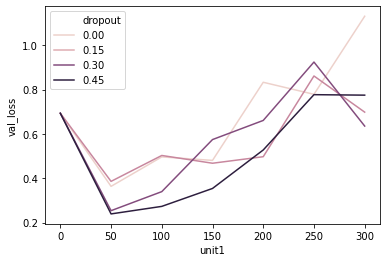

In [129]:
ax1 = sns.lineplot(x="unit1", y="val_loss", hue="dropout" ,data=summ[summ['unit2']==summ['unit1']])

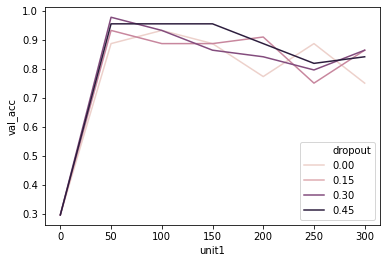

In [130]:
ax2 = sns.lineplot(x="unit1", y="val_acc", hue="dropout" ,data=summ[summ['unit2']==summ['unit1']])

In [131]:
summ2 = pd.DataFrame(columns=['unit1','unit2','dropout','val_loss','val_acc'])

for un1 in np.arange(30, 70, 5):
    for un2 in np.arange(30, 70, 5):
        for dr in np.arange(0.25, 0.45, 0.05):

           # Name the test model
           name = 'unit1=_{}_unit2=_{}_dropout={}'.format(un1,un2,dr)
           print(name)

           # build the model
           model = baseline_model(un1,un2,dr)
        
           # Fit the model
           history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                     epochs=100, batch_size=32, verbose=1, callbacks=[es])
        
           # Plot the history
           #plot_history(history,name,'acc')
        
           #plot_history(history,name,'loss')
       
           # Print the summary values
           val_loss, val_acc = model.evaluate(x_test,y_test)
            
           line=pd.DataFrame({'unit1':[un1],'unit2':[un2],'dropout':[dr],'val_loss':[val_loss],'val_acc':[val_acc]})                  
           summ2 = summ2.append(line,ignore_index=True)
        



unit1=_30_unit2=_30_dropout=0.25
Model: "sequential_1808"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5424 (Dense)           (None, 30)                930       
_________________________________________________________________
dropout_3616 (Dropout)       (None, 30)                0         
_________________________________________________________________
batch_normalization_3616 (Ba (None, 30)                120       
_________________________________________________________________
dense_5425 (Dense)           (None, 30)                930       
_________________________________________________________________
dropout_3617 (Dropout)       (None, 30)                0         
_________________________________________________________________
batch_normalization_3617 (Ba (None, 30)                120       
_________________________________________________________________
dense_5426 (Dense)

11/11 [==============================] - 0s 24ms/step - loss: 1.2943 - accuracy: 0.5231 - val_loss: 1.0084 - val_accuracy: 0.6136
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0587 - accuracy: 0.6618 - val_loss: 0.8586 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9127 - accuracy: 0.7601 - val_loss: 0.7548 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7826 - accuracy: 0.8353 - val_loss: 0.6860 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7095 - accuracy: 0.8555 - val_loss: 0.6346 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6758 - accuracy: 0.8728 - val_loss: 0.5955 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6093 - accuracy: 0.8988 - val_loss: 0.5625 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5148 - accuracy: 0.9191 - val_loss: 0.4699 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4827 - accuracy: 0.9220 - val_loss: 0.4529 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4601 - accuracy: 0.9422 - val_loss: 0.4369 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4359 - accuracy: 0.9249 - val_loss: 0.4222 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4164 - accuracy: 0.9422 - val_loss: 0.4109 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4500 - accuracy: 0.9104 - val_loss: 0.3996 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3971 - accuracy: 0.9306 - val_loss: 0.3900 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.4531 - accuracy: 0.9451 - val_loss: 0.3988 - val_accuracy: 0.9773
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4618 - accuracy: 0.9249 - val_loss: 0.3881 - val_accuracy: 0.9773
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4343 - accuracy: 0.9480 - val_loss: 0.3780 - val_accuracy: 0.9773
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4311 - accuracy: 0.9364 - val_loss: 0.3696 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4344 - accuracy: 0.9220 - val_loss: 0.3619 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4164 - accuracy: 0.9191 - val_loss: 0.3523 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3621 - accuracy: 0.9566 - val_loss: 0.3441 - val_accuracy: 0.9773
Epoch 24/100
11/11 

Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5675 - accuracy: 0.9249 - val_loss: 0.5400 - val_accuracy: 0.9318
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5788 - accuracy: 0.9017 - val_loss: 0.5194 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5210 - accuracy: 0.9277 - val_loss: 0.5018 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4894 - accuracy: 0.9335 - val_loss: 0.4857 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4598 - accuracy: 0.9509 - val_loss: 0.4697 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4524 - accuracy: 0.9393 - val_loss: 0.4548 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4569 - accuracy: 0.9364 - val_loss: 0.4428 - val_accuracy: 0.9545
Epoch 

Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3804 - accuracy: 0.9364 - val_loss: 0.3834 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3339 - accuracy: 0.9624 - val_loss: 0.3716 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3191 - accuracy: 0.9682 - val_loss: 0.3648 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3122 - accuracy: 0.9653 - val_loss: 0.3588 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2887 - accuracy: 0.9682 - val_loss: 0.3505 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2932 - accuracy: 0.9595 - val_loss: 0.3436 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2774 - accuracy: 0.9595 - val_loss: 0.3341 - val_accuracy: 0.9545
Epoch 

Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2817 - accuracy: 0.9740 - val_loss: 0.3101 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2822 - accuracy: 0.9538 - val_loss: 0.3062 - val_accuracy: 0.9091
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2950 - accuracy: 0.9451 - val_loss: 0.3008 - val_accuracy: 0.9091
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2678 - accuracy: 0.9566 - val_loss: 0.2964 - val_accuracy: 0.9091
Epoch 34/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2398 - accuracy: 0.9653 - val_loss: 0.2898 - val_accuracy: 0.9091
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2321 - accuracy: 0.9740 - val_loss: 0.2850 - val_accuracy: 0.9091
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2482 - accuracy: 0.9711 - val_loss: 0.2812 - val_accuracy: 0.9091
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.3132 - accuracy: 0.9364 - val_loss: 0.3283 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2895 - accuracy: 0.9422 - val_loss: 0.3196 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2629 - accuracy: 0.9509 - val_loss: 0.3125 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2842 - accuracy: 0.9422 - val_loss: 0.3060 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2769 - accuracy: 0.9393 - val_loss: 0.3024 - val_accuracy: 0.9318
Epoch 35/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2521 - accuracy: 0.9624 - val_loss: 0.2958 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2506 - accuracy: 0.9624 - val_loss: 0.2887 - val_accuracy: 0.9545
Epoch 37/100
11/11 

Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1736 - accuracy: 0.9798 - val_loss: 0.2663 - val_accuracy: 0.9318
Epoch 37/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1705 - accuracy: 0.9798 - val_loss: 0.2585 - val_accuracy: 0.9318
Epoch 38/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1643 - accuracy: 0.9827 - val_loss: 0.2562 - val_accuracy: 0.9318
Epoch 39/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1818 - accuracy: 0.9682 - val_loss: 0.2579 - val_accuracy: 0.9318
Epoch 00039: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2579 - accuracy: 0.9318
unit1=_30_unit2=_40_dropout=0.3
Model: "sequential_1817"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5451 (Dense)           (None, 30)                930       
________________________________________________________________

11/11 [==============================] - 0s 21ms/step - loss: 1.3041 - accuracy: 0.5723 - val_loss: 0.9553 - val_accuracy: 0.8182
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0597 - accuracy: 0.7110 - val_loss: 0.8628 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9047 - accuracy: 0.8382 - val_loss: 0.7935 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8451 - accuracy: 0.8439 - val_loss: 0.7414 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7752 - accuracy: 0.8757 - val_loss: 0.6997 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7624 - accuracy: 0.8757 - val_loss: 0.6625 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7116 - accuracy: 0.8960 - val_loss: 0.6291 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7613 - accuracy: 0.8410 - val_loss: 0.6021 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7160 - accuracy: 0.8526 - val_loss: 0.5721 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6577 - accuracy: 0.8844 - val_loss: 0.5453 - val_accuracy: 0.9773
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6346 - accuracy: 0.8728 - val_loss: 0.5235 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5849 - accuracy: 0.9220 - val_loss: 0.5037 - val_accuracy: 0.9773
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5950 - accuracy: 0.8844 - val_loss: 0.4841 - val_accuracy: 0.9773
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5331 - accuracy: 0.9191 - val_loss: 0.4664 - val_accuracy: 0.9773
Epoch 13/1

Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5437 - accuracy: 0.9335 - val_loss: 0.5242 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5345 - accuracy: 0.9191 - val_loss: 0.5050 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5049 - accuracy: 0.9249 - val_loss: 0.4858 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4624 - accuracy: 0.9451 - val_loss: 0.4659 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4466 - accuracy: 0.9335 - val_loss: 0.4515 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4229 - accuracy: 0.9451 - val_loss: 0.4365 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4046 - accuracy: 0.9480 - val_loss: 0.4204 - val_accuracy: 0.9545
Epoch 

Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3892 - accuracy: 0.9364 - val_loss: 0.3668 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3515 - accuracy: 0.9509 - val_loss: 0.3535 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2978 - accuracy: 0.9711 - val_loss: 0.3407 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3529 - accuracy: 0.9422 - val_loss: 0.3286 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3171 - accuracy: 0.9451 - val_loss: 0.3180 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2989 - accuracy: 0.9682 - val_loss: 0.3053 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3096 - accuracy: 0.9509 - val_loss: 0.3011 - val_accuracy: 0.9773
Epoch 

Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3350 - accuracy: 0.9364 - val_loss: 0.3163 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3161 - accuracy: 0.9422 - val_loss: 0.3112 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3016 - accuracy: 0.9480 - val_loss: 0.3069 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2991 - accuracy: 0.9364 - val_loss: 0.3046 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2582 - accuracy: 0.9566 - val_loss: 0.2966 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2535 - accuracy: 0.9566 - val_loss: 0.2906 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2669 - accuracy: 0.9364 - val_loss: 0.2850 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.2540 - accuracy: 0.9653 - val_loss: 0.2926 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2449 - accuracy: 0.9624 - val_loss: 0.2879 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2578 - accuracy: 0.9538 - val_loss: 0.2816 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2290 - accuracy: 0.9682 - val_loss: 0.2712 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2253 - accuracy: 0.9595 - val_loss: 0.2646 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2306 - accuracy: 0.9538 - val_loss: 0.2601 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2128 - accuracy: 0.9711 - val_loss: 0.2558 - val_accuracy: 0.9545
Epoch 34/100
11/11 

Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2498 - accuracy: 0.9653 - val_loss: 0.3228 - val_accuracy: 0.9318
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2329 - accuracy: 0.9798 - val_loss: 0.3134 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2323 - accuracy: 0.9769 - val_loss: 0.3051 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2172 - accuracy: 0.9740 - val_loss: 0.2984 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2083 - accuracy: 0.9740 - val_loss: 0.2927 - val_accuracy: 0.9091
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2194 - accuracy: 0.9653 - val_loss: 0.2873 - val_accuracy: 0.9091
Epoch 34/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2225 - accuracy: 0.9595 - val_loss: 0.2870 - val_accuracy: 0.9091
Epoch 

Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2091 - accuracy: 0.9595 - val_loss: 0.2801 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1788 - accuracy: 0.9798 - val_loss: 0.2798 - val_accuracy: 0.9318
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1867 - accuracy: 0.9798 - val_loss: 0.2808 - val_accuracy: 0.9318
Epoch 00037: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2808 - accuracy: 0.9318
unit1=_30_unit2=_50_dropout=0.35
Model: "sequential_1826"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5478 (Dense)           (None, 30)                930       
_________________________________________________________________
dropout_3652 (Dropout)       (None, 30)                0         
_________________________________________________________________
batch_n

11/11 [==============================] - 0s 21ms/step - loss: 1.4969 - accuracy: 0.4682 - val_loss: 1.0813 - val_accuracy: 0.6591
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.2125 - accuracy: 0.6214 - val_loss: 0.9475 - val_accuracy: 0.7955
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0526 - accuracy: 0.7283 - val_loss: 0.8525 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0142 - accuracy: 0.7630 - val_loss: 0.7831 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8727 - accuracy: 0.8468 - val_loss: 0.7304 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8078 - accuracy: 0.8468 - val_loss: 0.6873 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7712 - accuracy: 0.8786 - val_loss: 0.6479 - val_accuracy: 0.8864
Epoch 8/100
11/11 [=====

Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0818 - accuracy: 0.7168 - val_loss: 0.8593 - val_accuracy: 0.8636
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9077 - accuracy: 0.8092 - val_loss: 0.7938 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7944 - accuracy: 0.8873 - val_loss: 0.7389 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7480 - accuracy: 0.8786 - val_loss: 0.6887 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6849 - accuracy: 0.9162 - val_loss: 0.6450 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6370 - accuracy: 0.9104 - val_loss: 0.6040 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6055 - accuracy: 0.9046 - val_loss: 0.5667 - val_accuracy: 0.9318
Epoch 9/100
1

Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4625 - accuracy: 0.9364 - val_loss: 0.4521 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4584 - accuracy: 0.9162 - val_loss: 0.4365 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4142 - accuracy: 0.9509 - val_loss: 0.4208 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4102 - accuracy: 0.9451 - val_loss: 0.4062 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4008 - accuracy: 0.9393 - val_loss: 0.3948 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3879 - accuracy: 0.9335 - val_loss: 0.3834 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3501 - accuracy: 0.9595 - val_loss: 0.3717 - val_accuracy: 0.9545
Epoch 

Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5019 - accuracy: 0.9191 - val_loss: 0.4621 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4425 - accuracy: 0.9422 - val_loss: 0.4460 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4295 - accuracy: 0.9422 - val_loss: 0.4296 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4368 - accuracy: 0.9335 - val_loss: 0.4184 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3985 - accuracy: 0.9393 - val_loss: 0.4084 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4027 - accuracy: 0.9335 - val_loss: 0.3943 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3782 - accuracy: 0.9306 - val_loss: 0.3807 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.3682 - accuracy: 0.9451 - val_loss: 0.3681 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3684 - accuracy: 0.9451 - val_loss: 0.3588 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3512 - accuracy: 0.9480 - val_loss: 0.3524 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3523 - accuracy: 0.9364 - val_loss: 0.3464 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3425 - accuracy: 0.9480 - val_loss: 0.3380 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3170 - accuracy: 0.9509 - val_loss: 0.3323 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3084 - accuracy: 0.9422 - val_loss: 0.3247 - val_accuracy: 0.9545
Epoch 31/100
11/11 

Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5003 - accuracy: 0.9364 - val_loss: 0.4645 - val_accuracy: 0.9773
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4552 - accuracy: 0.9480 - val_loss: 0.4498 - val_accuracy: 0.9773
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4439 - accuracy: 0.9538 - val_loss: 0.4336 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4533 - accuracy: 0.9364 - val_loss: 0.4181 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4060 - accuracy: 0.9422 - val_loss: 0.4035 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3892 - accuracy: 0.9393 - val_loss: 0.3866 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3598 - accuracy: 0.9566 - val_loss: 0.3710 - val_accuracy: 0.9545
Epoch 

Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3794 - accuracy: 0.9480 - val_loss: 0.3872 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3431 - accuracy: 0.9653 - val_loss: 0.3818 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3287 - accuracy: 0.9566 - val_loss: 0.3712 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3264 - accuracy: 0.9595 - val_loss: 0.3629 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3013 - accuracy: 0.9653 - val_loss: 0.3557 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3147 - accuracy: 0.9538 - val_loss: 0.3482 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3027 - accuracy: 0.9624 - val_loss: 0.3406 - val_accuracy: 0.9545
Epoch 

Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3055 - accuracy: 0.9653 - val_loss: 0.3412 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2800 - accuracy: 0.9595 - val_loss: 0.3355 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2575 - accuracy: 0.9769 - val_loss: 0.3262 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2566 - accuracy: 0.9682 - val_loss: 0.3183 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2783 - accuracy: 0.9538 - val_loss: 0.3148 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2616 - accuracy: 0.9538 - val_loss: 0.3103 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2745 - accuracy: 0.9509 - val_loss: 0.3022 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.2396 - accuracy: 0.9769 - val_loss: 0.2981 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2351 - accuracy: 0.9682 - val_loss: 0.2935 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2661 - accuracy: 0.9393 - val_loss: 0.2951 - val_accuracy: 0.9318
Epoch 00031: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2951 - accuracy: 0.9318
unit1=_30_unit2=_65_dropout=0.25
Model: "sequential_1836"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5508 (Dense)           (None, 30)                930       
_________________________________________________________________
dropout_3672 (Dropout)       (None, 30)                0         
_________________________________________________________________
batch_normalization_

Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9346 - accuracy: 0.8439 - val_loss: 0.8025 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8528 - accuracy: 0.8699 - val_loss: 0.7475 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7817 - accuracy: 0.9017 - val_loss: 0.7017 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7147 - accuracy: 0.9104 - val_loss: 0.6621 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6955 - accuracy: 0.9133 - val_loss: 0.6267 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6730 - accuracy: 0.9133 - val_loss: 0.5958 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6021 - accuracy: 0.9393 - val_loss: 0.5644 - val_accuracy: 0.9773
Epoch 11/100

11/11 [==============================] - 0s 22ms/step - loss: 1.3019 - accuracy: 0.6156 - val_loss: 0.9978 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0873 - accuracy: 0.7283 - val_loss: 0.8806 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9240 - accuracy: 0.8150 - val_loss: 0.7964 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8526 - accuracy: 0.8613 - val_loss: 0.7319 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8272 - accuracy: 0.8324 - val_loss: 0.6806 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7318 - accuracy: 0.8931 - val_loss: 0.6387 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6655 - accuracy: 0.9249 - val_loss: 0.6022 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5836 - accuracy: 0.9220 - val_loss: 0.5094 - val_accuracy: 0.9773
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5489 - accuracy: 0.9220 - val_loss: 0.4857 - val_accuracy: 0.9773
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5334 - accuracy: 0.9277 - val_loss: 0.4661 - val_accuracy: 0.9773
Epoch 13/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5347 - accuracy: 0.9364 - val_loss: 0.4498 - val_accuracy: 0.9773
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4961 - accuracy: 0.9364 - val_loss: 0.4336 - val_accuracy: 0.9773
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4759 - accuracy: 0.9364 - val_loss: 0.4195 - val_accuracy: 0.9773
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4440 - accuracy: 0.9277 - val_loss: 0.4052 - val_accuracy: 0.9773
Epoch

11/11 [==============================] - 0s 8ms/step - loss: 0.4341 - accuracy: 0.9509 - val_loss: 0.4228 - val_accuracy: 0.9773
Epoch 17/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3949 - accuracy: 0.9538 - val_loss: 0.4073 - val_accuracy: 0.9773
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3806 - accuracy: 0.9653 - val_loss: 0.3910 - val_accuracy: 0.9773
Epoch 19/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3580 - accuracy: 0.9538 - val_loss: 0.3785 - val_accuracy: 0.9773
Epoch 20/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3485 - accuracy: 0.9538 - val_loss: 0.3689 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3853 - accuracy: 0.9422 - val_loss: 0.3590 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3269 - accuracy: 0.9740 - val_loss: 0.3489 - val_accuracy: 0.9773
Epoch 23/100
11/11 

Epoch 22/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3454 - accuracy: 0.9538 - val_loss: 0.3517 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3293 - accuracy: 0.9538 - val_loss: 0.3429 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3245 - accuracy: 0.9538 - val_loss: 0.3353 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3088 - accuracy: 0.9538 - val_loss: 0.3302 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 12ms/step - loss: 0.3143 - accuracy: 0.9509 - val_loss: 0.3242 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2722 - accuracy: 0.9509 - val_loss: 0.3212 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3135 - accuracy: 0.9393 - val_loss: 0.3167 - val_accuracy: 0.9545
Ep

11/11 [==============================] - 0s 9ms/step - loss: 0.3414 - accuracy: 0.9393 - val_loss: 0.3117 - val_accuracy: 0.9318
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3181 - accuracy: 0.9451 - val_loss: 0.3086 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3131 - accuracy: 0.9566 - val_loss: 0.3028 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2451 - accuracy: 0.9827 - val_loss: 0.3006 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3064 - accuracy: 0.9451 - val_loss: 0.2999 - val_accuracy: 0.9091
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2611 - accuracy: 0.9566 - val_loss: 0.2948 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2675 - accuracy: 0.9595 - val_loss: 0.2925 - val_accuracy: 0.9091
Epoch 35/100
11/11 

11/11 [==============================] - 0s 8ms/step - loss: 0.4146 - accuracy: 0.9306 - val_loss: 0.3808 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3812 - accuracy: 0.9422 - val_loss: 0.3709 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3809 - accuracy: 0.9335 - val_loss: 0.3615 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3712 - accuracy: 0.9393 - val_loss: 0.3528 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3300 - accuracy: 0.9538 - val_loss: 0.3426 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3510 - accuracy: 0.9306 - val_loss: 0.3328 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3303 - accuracy: 0.9480 - val_loss: 0.3244 - val_accuracy: 0.9545
Epoch 29/100
11/11 

Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2434 - accuracy: 0.9740 - val_loss: 0.3189 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2566 - accuracy: 0.9653 - val_loss: 0.3170 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2311 - accuracy: 0.9769 - val_loss: 0.3129 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2598 - accuracy: 0.9566 - val_loss: 0.3024 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2249 - accuracy: 0.9653 - val_loss: 0.2983 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2101 - accuracy: 0.9827 - val_loss: 0.2963 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1996 - accuracy: 0.9798 - val_loss: 0.2907 - val_accuracy: 0.9545
Epoch 

Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1675 - accuracy: 0.9740 - val_loss: 0.2594 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1820 - accuracy: 0.9740 - val_loss: 0.2533 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1841 - accuracy: 0.9711 - val_loss: 0.2462 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1507 - accuracy: 0.9798 - val_loss: 0.2363 - val_accuracy: 0.9545
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1768 - accuracy: 0.9711 - val_loss: 0.2394 - val_accuracy: 0.9545
Epoch 00040: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2394 - accuracy: 0.9545
unit1=_35_unit2=_35_dropout=0.35
Model: "sequential_1846"
_________________________________________________________________
Layer (type)                 Output Shape            

11/11 [==============================] - 0s 22ms/step - loss: 1.2724 - accuracy: 0.5636 - val_loss: 1.0326 - val_accuracy: 0.5455
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0639 - accuracy: 0.7052 - val_loss: 0.8993 - val_accuracy: 0.8636
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9867 - accuracy: 0.7601 - val_loss: 0.8048 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8989 - accuracy: 0.7977 - val_loss: 0.7372 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7882 - accuracy: 0.8728 - val_loss: 0.6864 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7438 - accuracy: 0.8960 - val_loss: 0.6430 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6930 - accuracy: 0.8902 - val_loss: 0.6111 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 1.1375 - accuracy: 0.7168 - val_loss: 1.0148 - val_accuracy: 0.6591
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9774 - accuracy: 0.7919 - val_loss: 0.8813 - val_accuracy: 0.8636
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8405 - accuracy: 0.8728 - val_loss: 0.7948 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7609 - accuracy: 0.9191 - val_loss: 0.7307 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7075 - accuracy: 0.9075 - val_loss: 0.6779 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6740 - accuracy: 0.9133 - val_loss: 0.6350 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6020 - accuracy: 0.9277 - val_loss: 0.5981 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8592 - accuracy: 0.8410 - val_loss: 0.7377 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7848 - accuracy: 0.8844 - val_loss: 0.6861 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7112 - accuracy: 0.9220 - val_loss: 0.6435 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7164 - accuracy: 0.9017 - val_loss: 0.6082 - val_accuracy: 0.9773
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6603 - accuracy: 0.8988 - val_loss: 0.5770 - val_accuracy: 0.9773
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6377 - accuracy: 0.9075 - val_loss: 0.5502 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5968 - accuracy: 0.9017 - val_loss: 0.5277 - val_accuracy: 0.9773
Epoch 11/10

11/11 [==============================] - 0s 8ms/step - loss: 0.5695 - accuracy: 0.9451 - val_loss: 0.5438 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5837 - accuracy: 0.9162 - val_loss: 0.5222 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5313 - accuracy: 0.9451 - val_loss: 0.5047 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5235 - accuracy: 0.9335 - val_loss: 0.4867 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5325 - accuracy: 0.9104 - val_loss: 0.4715 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4564 - accuracy: 0.9509 - val_loss: 0.4544 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4558 - accuracy: 0.9364 - val_loss: 0.4388 - val_accuracy: 0.9545
Epoch 17/100
11/11 

11/11 [==============================] - 0s 8ms/step - loss: 0.4185 - accuracy: 0.9422 - val_loss: 0.3685 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3938 - accuracy: 0.9393 - val_loss: 0.3586 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3755 - accuracy: 0.9595 - val_loss: 0.3494 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3663 - accuracy: 0.9509 - val_loss: 0.3422 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3318 - accuracy: 0.9566 - val_loss: 0.3331 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3473 - accuracy: 0.9451 - val_loss: 0.3244 - val_accuracy: 0.9773
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3325 - accuracy: 0.9566 - val_loss: 0.3171 - val_accuracy: 0.9773
Epoch 27/100
11/11 

Epoch 19/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3248 - accuracy: 0.9711 - val_loss: 0.4095 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3240 - accuracy: 0.9624 - val_loss: 0.3979 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3093 - accuracy: 0.9740 - val_loss: 0.3887 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3217 - accuracy: 0.9538 - val_loss: 0.3787 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2913 - accuracy: 0.9653 - val_loss: 0.3683 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2816 - accuracy: 0.9624 - val_loss: 0.3556 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2882 - accuracy: 0.9624 - val_loss: 0.3448 - val_accuracy: 0.9545
Epoch

Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2380 - accuracy: 0.9653 - val_loss: 0.2964 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2188 - accuracy: 0.9624 - val_loss: 0.2915 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2049 - accuracy: 0.9711 - val_loss: 0.2822 - val_accuracy: 0.9318
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2070 - accuracy: 0.9798 - val_loss: 0.2714 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1968 - accuracy: 0.9769 - val_loss: 0.2694 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1873 - accuracy: 0.9682 - val_loss: 0.2691 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1637 - accuracy: 0.9798 - val_loss: 0.2771 - val_accuracy: 0.9318
Epoch 

2/2 [==============================] - 0s 2ms/step - loss: 0.2521 - accuracy: 0.9545
unit1=_35_unit2=_45_dropout=0.39999999999999997
Model: "sequential_1855"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5565 (Dense)           (None, 35)                1085      
_________________________________________________________________
dropout_3710 (Dropout)       (None, 35)                0         
_________________________________________________________________
batch_normalization_3710 (Ba (None, 35)                140       
_________________________________________________________________
dense_5566 (Dense)           (None, 45)                1620      
_________________________________________________________________
dropout_3711 (Dropout)       (None, 45)                0         
_________________________________________________________________
batch_normalization_3711 (Ba (None, 45)           

11/11 [==============================] - 0s 23ms/step - loss: 1.2687 - accuracy: 0.6301 - val_loss: 0.9671 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0007 - accuracy: 0.8035 - val_loss: 0.8524 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8712 - accuracy: 0.8526 - val_loss: 0.7769 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7640 - accuracy: 0.9220 - val_loss: 0.7202 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7163 - accuracy: 0.9249 - val_loss: 0.6750 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6665 - accuracy: 0.9249 - val_loss: 0.6382 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6295 - accuracy: 0.9306 - val_loss: 0.6051 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4366 - accuracy: 0.9624 - val_loss: 0.4576 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3998 - accuracy: 0.9624 - val_loss: 0.4426 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3740 - accuracy: 0.9740 - val_loss: 0.4256 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3732 - accuracy: 0.9566 - val_loss: 0.4117 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3753 - accuracy: 0.9480 - val_loss: 0.3950 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3258 - accuracy: 0.9653 - val_loss: 0.3869 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3262 - accuracy: 0.9740 - val_loss: 0.3754 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.3804 - accuracy: 0.9364 - val_loss: 0.4046 - val_accuracy: 0.9773
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3710 - accuracy: 0.9451 - val_loss: 0.3900 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3558 - accuracy: 0.9451 - val_loss: 0.3786 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3760 - accuracy: 0.9538 - val_loss: 0.3665 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3341 - accuracy: 0.9451 - val_loss: 0.3563 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3165 - accuracy: 0.9509 - val_loss: 0.3482 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2966 - accuracy: 0.9538 - val_loss: 0.3388 - val_accuracy: 0.9773
Epoch 26/100
11/11 

Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4007 - accuracy: 0.9393 - val_loss: 0.4017 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3638 - accuracy: 0.9480 - val_loss: 0.3902 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3797 - accuracy: 0.9422 - val_loss: 0.3798 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3461 - accuracy: 0.9509 - val_loss: 0.3726 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3405 - accuracy: 0.9364 - val_loss: 0.3642 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3378 - accuracy: 0.9509 - val_loss: 0.3554 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3209 - accuracy: 0.9509 - val_loss: 0.3482 - val_accuracy: 0.9545
Epoch 

Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3711 - accuracy: 0.9769 - val_loss: 0.4223 - val_accuracy: 0.9318
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3532 - accuracy: 0.9682 - val_loss: 0.4126 - val_accuracy: 0.9318
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3432 - accuracy: 0.9711 - val_loss: 0.4034 - val_accuracy: 0.9318
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3383 - accuracy: 0.9624 - val_loss: 0.3942 - val_accuracy: 0.9318
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3152 - accuracy: 0.9595 - val_loss: 0.3863 - val_accuracy: 0.9318
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3100 - accuracy: 0.9740 - val_loss: 0.3739 - val_accuracy: 0.9318
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2809 - accuracy: 0.9827 - val_loss: 0.3616 - val_accuracy: 0.9318
Epoch 

Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2656 - accuracy: 0.9769 - val_loss: 0.3227 - val_accuracy: 0.9773
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2701 - accuracy: 0.9538 - val_loss: 0.3166 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2567 - accuracy: 0.9653 - val_loss: 0.3124 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2650 - accuracy: 0.9566 - val_loss: 0.3049 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2426 - accuracy: 0.9653 - val_loss: 0.2961 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2197 - accuracy: 0.9769 - val_loss: 0.2909 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2146 - accuracy: 0.9798 - val_loss: 0.2857 - val_accuracy: 0.9545
Epoch 

Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2025 - accuracy: 0.9653 - val_loss: 0.2444 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1818 - accuracy: 0.9769 - val_loss: 0.2444 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1562 - accuracy: 0.9855 - val_loss: 0.2395 - val_accuracy: 0.9545
Epoch 40/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1553 - accuracy: 0.9740 - val_loss: 0.2319 - val_accuracy: 0.9545
Epoch 41/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1710 - accuracy: 0.9769 - val_loss: 0.2252 - val_accuracy: 0.9545
Epoch 42/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1632 - accuracy: 0.9798 - val_loss: 0.2165 - val_accuracy: 0.9545
Epoch 43/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1471 - accuracy: 0.9740 - val_loss: 0.2164 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 9ms/step - loss: 0.1825 - accuracy: 0.9769 - val_loss: 0.2551 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2094 - accuracy: 0.9682 - val_loss: 0.2469 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1798 - accuracy: 0.9798 - val_loss: 0.2425 - val_accuracy: 0.9545
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1570 - accuracy: 0.9884 - val_loss: 0.2344 - val_accuracy: 0.9545
Epoch 41/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1498 - accuracy: 0.9855 - val_loss: 0.2268 - val_accuracy: 0.9545
Epoch 42/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1609 - accuracy: 0.9769 - val_loss: 0.2244 - val_accuracy: 0.9545
Epoch 43/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1650 - accuracy: 0.9827 - val_loss: 0.2220 - val_accuracy: 0.9545
Epoch 44/100
11/11 

Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2316 - accuracy: 0.9624 - val_loss: 0.3229 - val_accuracy: 0.8864
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2320 - accuracy: 0.9769 - val_loss: 0.3207 - val_accuracy: 0.8864
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2252 - accuracy: 0.9624 - val_loss: 0.3031 - val_accuracy: 0.8864
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1988 - accuracy: 0.9682 - val_loss: 0.2914 - val_accuracy: 0.8864
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1971 - accuracy: 0.9740 - val_loss: 0.2917 - val_accuracy: 0.8864
Epoch 00034: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2917 - accuracy: 0.8864
unit1=_35_unit2=_60_dropout=0.3
Model: "sequential_1865"
_________________________________________________________________
Layer (type)                 Output Shape             

11/11 [==============================] - 0s 23ms/step - loss: 1.4898 - accuracy: 0.5289 - val_loss: 0.9909 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2113 - accuracy: 0.6821 - val_loss: 0.8803 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0321 - accuracy: 0.7890 - val_loss: 0.8079 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9233 - accuracy: 0.8671 - val_loss: 0.7534 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8714 - accuracy: 0.8410 - val_loss: 0.7118 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7939 - accuracy: 0.8642 - val_loss: 0.6767 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7469 - accuracy: 0.8960 - val_loss: 0.6446 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 1.4270 - accuracy: 0.5376 - val_loss: 1.0471 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1346 - accuracy: 0.7139 - val_loss: 0.9109 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0497 - accuracy: 0.7746 - val_loss: 0.8191 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9321 - accuracy: 0.8410 - val_loss: 0.7514 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8837 - accuracy: 0.8324 - val_loss: 0.6960 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7821 - accuracy: 0.8757 - val_loss: 0.6471 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7376 - accuracy: 0.9075 - val_loss: 0.6087 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4446 - accuracy: 0.9509 - val_loss: 0.4676 - val_accuracy: 0.9773
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4416 - accuracy: 0.9480 - val_loss: 0.4489 - val_accuracy: 0.9773
Epoch 15/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4338 - accuracy: 0.9393 - val_loss: 0.4343 - val_accuracy: 0.9773
Epoch 16/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3763 - accuracy: 0.9653 - val_loss: 0.4183 - val_accuracy: 0.9773
Epoch 17/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3733 - accuracy: 0.9480 - val_loss: 0.3991 - val_accuracy: 0.9773
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3500 - accuracy: 0.9682 - val_loss: 0.3834 - val_accuracy: 0.9773
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3319 - accuracy: 0.9624 - val_loss: 0.3700 - val_accuracy: 0.9773
Epoc

Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3181 - accuracy: 0.9509 - val_loss: 0.3511 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2977 - accuracy: 0.9451 - val_loss: 0.3414 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2774 - accuracy: 0.9711 - val_loss: 0.3411 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2655 - accuracy: 0.9624 - val_loss: 0.3422 - val_accuracy: 0.9318
Epoch 00028: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3422 - accuracy: 0.9318
unit1=_35_unit2=_65_dropout=0.35
Model: "sequential_1870"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5610 (Dense)           (None, 35)                1085      
_______________________________________________________________

Epoch 00044: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2707 - accuracy: 0.9545
unit1=_35_unit2=_65_dropout=0.39999999999999997
Model: "sequential_1871"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5613 (Dense)           (None, 35)                1085      
_________________________________________________________________
dropout_3742 (Dropout)       (None, 35)                0         
_________________________________________________________________
batch_normalization_3742 (Ba (None, 35)                140       
_________________________________________________________________
dense_5614 (Dense)           (None, 65)                2340      
_________________________________________________________________
dropout_3743 (Dropout)       (None, 65)                0         
_________________________________________________________________
batch_normalization_37

11/11 [==============================] - 0s 23ms/step - loss: 1.4370 - accuracy: 0.4335 - val_loss: 1.0065 - val_accuracy: 0.7045
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1319 - accuracy: 0.6676 - val_loss: 0.9047 - val_accuracy: 0.8182
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9497 - accuracy: 0.7746 - val_loss: 0.8297 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8420 - accuracy: 0.8064 - val_loss: 0.7719 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8002 - accuracy: 0.8353 - val_loss: 0.7255 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7428 - accuracy: 0.8757 - val_loss: 0.6870 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6668 - accuracy: 0.8931 - val_loss: 0.6543 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5503 - accuracy: 0.9509 - val_loss: 0.5356 - val_accuracy: 0.9091
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5659 - accuracy: 0.9249 - val_loss: 0.5134 - val_accuracy: 0.9091
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5349 - accuracy: 0.9162 - val_loss: 0.4935 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5379 - accuracy: 0.9133 - val_loss: 0.4755 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4847 - accuracy: 0.9306 - val_loss: 0.4583 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4608 - accuracy: 0.9451 - val_loss: 0.4413 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4212 - accuracy: 0.9509 - val_loss: 0.4268 - val_accuracy: 0.9545
Epoch 15

Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4264 - accuracy: 0.9277 - val_loss: 0.4001 - val_accuracy: 0.9318
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3917 - accuracy: 0.9538 - val_loss: 0.3883 - val_accuracy: 0.9318
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3634 - accuracy: 0.9682 - val_loss: 0.3779 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3798 - accuracy: 0.9538 - val_loss: 0.3676 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3639 - accuracy: 0.9509 - val_loss: 0.3568 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3393 - accuracy: 0.9566 - val_loss: 0.3468 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3482 - accuracy: 0.9538 - val_loss: 0.3364 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.3392 - accuracy: 0.9451 - val_loss: 0.3541 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3509 - accuracy: 0.9566 - val_loss: 0.3478 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3123 - accuracy: 0.9711 - val_loss: 0.3408 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3181 - accuracy: 0.9451 - val_loss: 0.3326 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3125 - accuracy: 0.9451 - val_loss: 0.3249 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2990 - accuracy: 0.9682 - val_loss: 0.3124 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3264 - accuracy: 0.9451 - val_loss: 0.3057 - val_accuracy: 0.9545
Epoch 31/100
11/11 

11/11 [==============================] - 0s 22ms/step - loss: 1.3458 - accuracy: 0.5116 - val_loss: 0.9527 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0777 - accuracy: 0.7370 - val_loss: 0.8446 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9646 - accuracy: 0.7775 - val_loss: 0.7728 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8691 - accuracy: 0.8439 - val_loss: 0.7210 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8129 - accuracy: 0.8642 - val_loss: 0.6789 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7304 - accuracy: 0.8902 - val_loss: 0.6435 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6869 - accuracy: 0.9046 - val_loss: 0.6133 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4703 - accuracy: 0.9393 - val_loss: 0.4517 - val_accuracy: 0.9773
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4445 - accuracy: 0.9393 - val_loss: 0.4395 - val_accuracy: 0.9773
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4467 - accuracy: 0.9422 - val_loss: 0.4265 - val_accuracy: 0.9773
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4574 - accuracy: 0.9220 - val_loss: 0.4137 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4058 - accuracy: 0.9451 - val_loss: 0.4018 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3812 - accuracy: 0.9509 - val_loss: 0.3914 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3579 - accuracy: 0.9509 - val_loss: 0.3816 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.4440 - accuracy: 0.9538 - val_loss: 0.4250 - val_accuracy: 0.9773
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4406 - accuracy: 0.9393 - val_loss: 0.4124 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4466 - accuracy: 0.9306 - val_loss: 0.4001 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4043 - accuracy: 0.9538 - val_loss: 0.3911 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4180 - accuracy: 0.9422 - val_loss: 0.3801 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3890 - accuracy: 0.9480 - val_loss: 0.3704 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3693 - accuracy: 0.9480 - val_loss: 0.3592 - val_accuracy: 0.9773
Epoch 26/100
11/11 

Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2975 - accuracy: 0.9798 - val_loss: 0.3725 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3429 - accuracy: 0.9422 - val_loss: 0.3609 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2979 - accuracy: 0.9653 - val_loss: 0.3532 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2865 - accuracy: 0.9538 - val_loss: 0.3414 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2734 - accuracy: 0.9595 - val_loss: 0.3300 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2639 - accuracy: 0.9595 - val_loss: 0.3197 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2740 - accuracy: 0.9566 - val_loss: 0.3114 - val_accuracy: 0.9545
Epoch 

Epoch 19/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3664 - accuracy: 0.9422 - val_loss: 0.3846 - val_accuracy: 0.9773
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3624 - accuracy: 0.9422 - val_loss: 0.3725 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3362 - accuracy: 0.9624 - val_loss: 0.3636 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3263 - accuracy: 0.9538 - val_loss: 0.3537 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3221 - accuracy: 0.9451 - val_loss: 0.3448 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2753 - accuracy: 0.9740 - val_loss: 0.3335 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2846 - accuracy: 0.9653 - val_loss: 0.3225 - val_accuracy: 0.9773
Epoch

Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2939 - accuracy: 0.9595 - val_loss: 0.3399 - val_accuracy: 0.9091
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2703 - accuracy: 0.9682 - val_loss: 0.3352 - val_accuracy: 0.9091
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2892 - accuracy: 0.9538 - val_loss: 0.3309 - val_accuracy: 0.9091
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2565 - accuracy: 0.9711 - val_loss: 0.3276 - val_accuracy: 0.9091
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3022 - accuracy: 0.9538 - val_loss: 0.3220 - val_accuracy: 0.9091
Epoch 30/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2519 - accuracy: 0.9595 - val_loss: 0.3106 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2543 - accuracy: 0.9653 - val_loss: 0.3025 - val_accuracy: 0.9318
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.2169 - accuracy: 0.9653 - val_loss: 0.2793 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2443 - accuracy: 0.9595 - val_loss: 0.2779 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2191 - accuracy: 0.9624 - val_loss: 0.2738 - val_accuracy: 0.9545
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1799 - accuracy: 0.9827 - val_loss: 0.2678 - val_accuracy: 0.9545
Epoch 41/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1899 - accuracy: 0.9827 - val_loss: 0.2613 - val_accuracy: 0.9545
Epoch 42/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1959 - accuracy: 0.9624 - val_loss: 0.2591 - val_accuracy: 0.9545
Epoch 43/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2216 - accuracy: 0.9509 - val_loss: 0.2591 - val_accuracy: 0.9545
Epoch 44/100
11/11 

Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2249 - accuracy: 0.9827 - val_loss: 0.3069 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2210 - accuracy: 0.9769 - val_loss: 0.2974 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2598 - accuracy: 0.9538 - val_loss: 0.2943 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2172 - accuracy: 0.9769 - val_loss: 0.2992 - val_accuracy: 0.9318
Epoch 00032: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2992 - accuracy: 0.9318
unit1=_40_unit2=_45_dropout=0.3
Model: "sequential_1885"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5655 (Dense)           (None, 40)                1240      
________________________________________________________________

11/11 [==============================] - 0s 21ms/step - loss: 1.4328 - accuracy: 0.5520 - val_loss: 1.0180 - val_accuracy: 0.8182
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2045 - accuracy: 0.6647 - val_loss: 0.9041 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0183 - accuracy: 0.7861 - val_loss: 0.8237 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8872 - accuracy: 0.8699 - val_loss: 0.7625 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8433 - accuracy: 0.8815 - val_loss: 0.7166 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7887 - accuracy: 0.8844 - val_loss: 0.6792 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7648 - accuracy: 0.8786 - val_loss: 0.6476 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9469 - accuracy: 0.8092 - val_loss: 0.7243 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8670 - accuracy: 0.8382 - val_loss: 0.6877 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8181 - accuracy: 0.8613 - val_loss: 0.6529 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7617 - accuracy: 0.8786 - val_loss: 0.6243 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7260 - accuracy: 0.8728 - val_loss: 0.5998 - val_accuracy: 0.9545
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6794 - accuracy: 0.9046 - val_loss: 0.5770 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6084 - accuracy: 0.9277 - val_loss: 0.5547 - val_accuracy: 0.9773
Epoch 11/100

Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8208 - accuracy: 0.8931 - val_loss: 0.7410 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7869 - accuracy: 0.9017 - val_loss: 0.6971 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7199 - accuracy: 0.9220 - val_loss: 0.6578 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6715 - accuracy: 0.9220 - val_loss: 0.6227 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6415 - accuracy: 0.9104 - val_loss: 0.5936 - val_accuracy: 0.9545
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6052 - accuracy: 0.9364 - val_loss: 0.5676 - val_accuracy: 0.9545
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5715 - accuracy: 0.9509 - val_loss: 0.5420 - val_accuracy: 0.9545
Epoch 11/10

Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5540 - accuracy: 0.9451 - val_loss: 0.5474 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5204 - accuracy: 0.9480 - val_loss: 0.5269 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4970 - accuracy: 0.9566 - val_loss: 0.5098 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4731 - accuracy: 0.9566 - val_loss: 0.4943 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4639 - accuracy: 0.9480 - val_loss: 0.4796 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4461 - accuracy: 0.9393 - val_loss: 0.4651 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4487 - accuracy: 0.9393 - val_loss: 0.4521 - val_accuracy: 0.9545
Epoch 

Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3620 - accuracy: 0.9624 - val_loss: 0.3657 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3465 - accuracy: 0.9538 - val_loss: 0.3576 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3268 - accuracy: 0.9653 - val_loss: 0.3516 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3084 - accuracy: 0.9653 - val_loss: 0.3436 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3249 - accuracy: 0.9538 - val_loss: 0.3309 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3043 - accuracy: 0.9624 - val_loss: 0.3210 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2860 - accuracy: 0.9653 - val_loss: 0.3143 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.3006 - accuracy: 0.9653 - val_loss: 0.3561 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3225 - accuracy: 0.9451 - val_loss: 0.3443 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2874 - accuracy: 0.9740 - val_loss: 0.3326 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2853 - accuracy: 0.9798 - val_loss: 0.3222 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2657 - accuracy: 0.9682 - val_loss: 0.3141 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2862 - accuracy: 0.9566 - val_loss: 0.3025 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2545 - accuracy: 0.9538 - val_loss: 0.2966 - val_accuracy: 0.9545
Epoch 33/100
11/11 

Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1979 - accuracy: 0.9798 - val_loss: 0.2912 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1850 - accuracy: 0.9769 - val_loss: 0.2877 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1836 - accuracy: 0.9798 - val_loss: 0.2847 - val_accuracy: 0.9318
Epoch 38/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1670 - accuracy: 0.9884 - val_loss: 0.2810 - val_accuracy: 0.9318
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1825 - accuracy: 0.9740 - val_loss: 0.2733 - val_accuracy: 0.9318
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1407 - accuracy: 0.9913 - val_loss: 0.2596 - val_accuracy: 0.9318
Epoch 41/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1595 - accuracy: 0.9855 - val_loss: 0.2538 - val_accuracy: 0.9545
Epoch 

Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1884 - accuracy: 0.9798 - val_loss: 0.2767 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1911 - accuracy: 0.9682 - val_loss: 0.2818 - val_accuracy: 0.9545
Epoch 00037: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2818 - accuracy: 0.9545
unit1=_40_unit2=_55_dropout=0.35
Model: "sequential_1894"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5682 (Dense)           (None, 40)                1240      
_________________________________________________________________
dropout_3788 (Dropout)       (None, 40)                0         
_________________________________________________________________
batch_normalization_3788 (Ba (None, 40)                160       
_________________________________________________________________
dense_5683 (Dense

11/11 [==============================] - 0s 21ms/step - loss: 1.5275 - accuracy: 0.5376 - val_loss: 1.0920 - val_accuracy: 0.6818
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2380 - accuracy: 0.7110 - val_loss: 0.9579 - val_accuracy: 0.8636
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0913 - accuracy: 0.7948 - val_loss: 0.8611 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9582 - accuracy: 0.8555 - val_loss: 0.7887 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9213 - accuracy: 0.8584 - val_loss: 0.7337 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8367 - accuracy: 0.8960 - val_loss: 0.6888 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7730 - accuracy: 0.9075 - val_loss: 0.6500 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6639 - accuracy: 0.9393 - val_loss: 0.6644 - val_accuracy: 0.9545
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6174 - accuracy: 0.9509 - val_loss: 0.6293 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5616 - accuracy: 0.9595 - val_loss: 0.5979 - val_accuracy: 0.9318
Epoch 11/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5487 - accuracy: 0.9480 - val_loss: 0.5704 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5232 - accuracy: 0.9393 - val_loss: 0.5475 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5268 - accuracy: 0.9451 - val_loss: 0.5287 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4678 - accuracy: 0.9595 - val_loss: 0.5127 - val_accuracy: 0.9318
Epoch 15

Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4919 - accuracy: 0.9393 - val_loss: 0.4827 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4586 - accuracy: 0.9480 - val_loss: 0.4658 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4497 - accuracy: 0.9480 - val_loss: 0.4469 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4040 - accuracy: 0.9653 - val_loss: 0.4319 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3947 - accuracy: 0.9566 - val_loss: 0.4189 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3818 - accuracy: 0.9566 - val_loss: 0.4089 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3591 - accuracy: 0.9566 - val_loss: 0.4001 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.3213 - accuracy: 0.9624 - val_loss: 0.3684 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2897 - accuracy: 0.9682 - val_loss: 0.3585 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2988 - accuracy: 0.9624 - val_loss: 0.3535 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2805 - accuracy: 0.9566 - val_loss: 0.3483 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2898 - accuracy: 0.9538 - val_loss: 0.3453 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2496 - accuracy: 0.9769 - val_loss: 0.3397 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2720 - accuracy: 0.9451 - val_loss: 0.3350 - val_accuracy: 0.9318
Epoch 32/100
11/11 

Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2583 - accuracy: 0.9566 - val_loss: 0.3133 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2494 - accuracy: 0.9653 - val_loss: 0.3133 - val_accuracy: 0.9318
Epoch 00034: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3133 - accuracy: 0.9318
unit1=_40_unit2=_65_dropout=0.25
Model: "sequential_1900"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5700 (Dense)           (None, 40)                1240      
_________________________________________________________________
dropout_3800 (Dropout)       (None, 40)                0         
_________________________________________________________________
batch_normalization_3800 (Ba (None, 40)                160       
_________________________________________________________________
dense_5701 (Dense

11/11 [==============================] - 0s 22ms/step - loss: 1.3950 - accuracy: 0.6301 - val_loss: 1.0274 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1406 - accuracy: 0.7688 - val_loss: 0.9194 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0236 - accuracy: 0.8439 - val_loss: 0.8476 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9390 - accuracy: 0.8468 - val_loss: 0.7955 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8308 - accuracy: 0.9017 - val_loss: 0.7524 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8002 - accuracy: 0.9220 - val_loss: 0.7133 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7141 - accuracy: 0.9277 - val_loss: 0.6779 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3318 - accuracy: 0.9480 - val_loss: 0.3666 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2886 - accuracy: 0.9711 - val_loss: 0.3539 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3163 - accuracy: 0.9335 - val_loss: 0.3331 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2669 - accuracy: 0.9682 - val_loss: 0.3278 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2660 - accuracy: 0.9566 - val_loss: 0.3284 - val_accuracy: 0.9545
Epoch 00026: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3284 - accuracy: 0.9545
unit1=_40_unit2=_65_dropout=0.39999999999999997
Model: "sequential_1903"
_________________________________________________________________
Layer (type)                 Output Sh

11/11 [==============================] - 0s 21ms/step - loss: 1.3613 - accuracy: 0.5636 - val_loss: 0.9245 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.1086 - accuracy: 0.6792 - val_loss: 0.8225 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9229 - accuracy: 0.8092 - val_loss: 0.7565 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8215 - accuracy: 0.8642 - val_loss: 0.7075 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7581 - accuracy: 0.8815 - val_loss: 0.6653 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7048 - accuracy: 0.9075 - val_loss: 0.6290 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6582 - accuracy: 0.9191 - val_loss: 0.5980 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4549 - accuracy: 0.9364 - val_loss: 0.4447 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4764 - accuracy: 0.9306 - val_loss: 0.4305 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4024 - accuracy: 0.9682 - val_loss: 0.4174 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4002 - accuracy: 0.9538 - val_loss: 0.4046 - val_accuracy: 0.9318
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3811 - accuracy: 0.9595 - val_loss: 0.3916 - val_accuracy: 0.9318
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3913 - accuracy: 0.9509 - val_loss: 0.3809 - val_accuracy: 0.9318
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3320 - accuracy: 0.9711 - val_loss: 0.3686 - val_accuracy: 0.9318
Epoch 

Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3179 - accuracy: 0.9480 - val_loss: 0.3569 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2994 - accuracy: 0.9566 - val_loss: 0.3494 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2843 - accuracy: 0.9480 - val_loss: 0.3447 - val_accuracy: 0.9318
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2858 - accuracy: 0.9595 - val_loss: 0.3364 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2749 - accuracy: 0.9595 - val_loss: 0.3309 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2679 - accuracy: 0.9422 - val_loss: 0.3265 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2377 - accuracy: 0.9798 - val_loss: 0.3178 - val_accuracy: 0.9318
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.2916 - accuracy: 0.9595 - val_loss: 0.3174 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3011 - accuracy: 0.9277 - val_loss: 0.3118 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2835 - accuracy: 0.9480 - val_loss: 0.3060 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2691 - accuracy: 0.9538 - val_loss: 0.3004 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2804 - accuracy: 0.9566 - val_loss: 0.2962 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2420 - accuracy: 0.9509 - val_loss: 0.2922 - val_accuracy: 0.9318
Epoch 35/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2466 - accuracy: 0.9653 - val_loss: 0.2849 - val_accuracy: 0.9318
Epoch 36/100
11/11

Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3485 - accuracy: 0.9509 - val_loss: 0.3458 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3062 - accuracy: 0.9653 - val_loss: 0.3279 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2869 - accuracy: 0.9682 - val_loss: 0.3145 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2563 - accuracy: 0.9827 - val_loss: 0.3055 - val_accuracy: 0.9773
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2684 - accuracy: 0.9595 - val_loss: 0.2985 - val_accuracy: 0.9773
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2563 - accuracy: 0.9711 - val_loss: 0.2898 - val_accuracy: 0.9773
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2638 - accuracy: 0.9653 - val_loss: 0.2804 - val_accuracy: 0.9773
Epoch

11/11 [==============================] - 0s 8ms/step - loss: 0.1894 - accuracy: 0.9798 - val_loss: 0.2659 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1905 - accuracy: 0.9798 - val_loss: 0.2614 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1976 - accuracy: 0.9682 - val_loss: 0.2565 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1957 - accuracy: 0.9682 - val_loss: 0.2494 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1768 - accuracy: 0.9769 - val_loss: 0.2538 - val_accuracy: 0.9318
Epoch 00038: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2538 - accuracy: 0.9318
unit1=_45_unit2=_35_dropout=0.35
Model: "sequential_1910"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   


11/11 [==============================] - 0s 23ms/step - loss: 1.3530 - accuracy: 0.5578 - val_loss: 0.9888 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1010 - accuracy: 0.7283 - val_loss: 0.8760 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0286 - accuracy: 0.7775 - val_loss: 0.7982 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8693 - accuracy: 0.8671 - val_loss: 0.7397 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8600 - accuracy: 0.8410 - val_loss: 0.6919 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7655 - accuracy: 0.9017 - val_loss: 0.6513 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7143 - accuracy: 0.9220 - val_loss: 0.6180 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7981 - accuracy: 0.9046 - val_loss: 0.7279 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7570 - accuracy: 0.8960 - val_loss: 0.6905 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6915 - accuracy: 0.9306 - val_loss: 0.6557 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6702 - accuracy: 0.9162 - val_loss: 0.6257 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6017 - accuracy: 0.9451 - val_loss: 0.5984 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5943 - accuracy: 0.9306 - val_loss: 0.5721 - val_accuracy: 0.9318
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5497 - accuracy: 0.9509 - val_loss: 0.5476 - val_accuracy: 0.9318
Epoch 12/10

Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5596 - accuracy: 0.9220 - val_loss: 0.5240 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4818 - accuracy: 0.9538 - val_loss: 0.5046 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4895 - accuracy: 0.9480 - val_loss: 0.4869 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4576 - accuracy: 0.9480 - val_loss: 0.4707 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4305 - accuracy: 0.9566 - val_loss: 0.4526 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4220 - accuracy: 0.9566 - val_loss: 0.4355 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 11ms/step - loss: 0.3982 - accuracy: 0.9595 - val_loss: 0.4257 - val_accuracy: 0.9545
Epoc

11/11 [==============================] - 0s 8ms/step - loss: 0.2857 - accuracy: 0.9682 - val_loss: 0.3515 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2796 - accuracy: 0.9566 - val_loss: 0.3390 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2502 - accuracy: 0.9711 - val_loss: 0.3299 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2626 - accuracy: 0.9595 - val_loss: 0.3221 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2343 - accuracy: 0.9740 - val_loss: 0.3142 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2237 - accuracy: 0.9769 - val_loss: 0.3078 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2310 - accuracy: 0.9740 - val_loss: 0.3049 - val_accuracy: 0.9545
Epoch 33/100
11/11 

Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2186 - accuracy: 0.9653 - val_loss: 0.2620 - val_accuracy: 0.9545
Epoch 41/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2211 - accuracy: 0.9682 - val_loss: 0.2600 - val_accuracy: 0.9318
Epoch 42/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1817 - accuracy: 0.9740 - val_loss: 0.2578 - val_accuracy: 0.9318
Epoch 43/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2059 - accuracy: 0.9682 - val_loss: 0.2559 - val_accuracy: 0.9318
Epoch 44/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2120 - accuracy: 0.9451 - val_loss: 0.2529 - val_accuracy: 0.9545
Epoch 45/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2180 - accuracy: 0.9566 - val_loss: 0.2425 - val_accuracy: 0.9545
Epoch 46/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1735 - accuracy: 0.9769 - val_loss: 0.2434 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 23ms/step - loss: 1.4662 - accuracy: 0.5607 - val_loss: 1.0963 - val_accuracy: 0.8409
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1599 - accuracy: 0.7457 - val_loss: 0.9693 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0082 - accuracy: 0.8266 - val_loss: 0.8798 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9390 - accuracy: 0.8497 - val_loss: 0.8127 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8338 - accuracy: 0.9104 - val_loss: 0.7608 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7863 - accuracy: 0.8902 - val_loss: 0.7159 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7653 - accuracy: 0.9104 - val_loss: 0.6776 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9277 - accuracy: 0.8526 - val_loss: 0.7625 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8505 - accuracy: 0.8468 - val_loss: 0.7271 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7936 - accuracy: 0.8873 - val_loss: 0.6969 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7347 - accuracy: 0.8902 - val_loss: 0.6699 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6910 - accuracy: 0.9162 - val_loss: 0.6444 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6232 - accuracy: 0.9393 - val_loss: 0.6203 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6138 - accuracy: 0.9277 - val_loss: 0.5976 - val_accuracy: 0.9318
Epoch 11/100

11/11 [==============================] - 0s 9ms/step - loss: 1.0758 - accuracy: 0.7543 - val_loss: 0.8379 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9874 - accuracy: 0.8121 - val_loss: 0.7826 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8861 - accuracy: 0.8815 - val_loss: 0.7371 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8411 - accuracy: 0.8786 - val_loss: 0.7009 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7673 - accuracy: 0.9075 - val_loss: 0.6714 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7515 - accuracy: 0.8902 - val_loss: 0.6460 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6758 - accuracy: 0.9249 - val_loss: 0.6205 - val_accuracy: 0.9318
Epoch 10/100
11/11 [=====

Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4491 - accuracy: 0.9538 - val_loss: 0.4852 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4301 - accuracy: 0.9653 - val_loss: 0.4678 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3771 - accuracy: 0.9769 - val_loss: 0.4526 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3757 - accuracy: 0.9682 - val_loss: 0.4379 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3822 - accuracy: 0.9509 - val_loss: 0.4188 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3480 - accuracy: 0.9682 - val_loss: 0.4045 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3281 - accuracy: 0.9711 - val_loss: 0.3924 - val_accuracy: 0.9545
Epoch 

Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2235 - accuracy: 0.9740 - val_loss: 0.3047 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2207 - accuracy: 0.9711 - val_loss: 0.2974 - val_accuracy: 0.9545
Epoch 34/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2316 - accuracy: 0.9624 - val_loss: 0.2887 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1875 - accuracy: 0.9884 - val_loss: 0.2808 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1904 - accuracy: 0.9798 - val_loss: 0.2749 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1866 - accuracy: 0.9798 - val_loss: 0.2747 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1894 - accuracy: 0.9798 - val_loss: 0.2657 - val_accuracy: 0.9545
Epoch 

Epoch 33/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2295 - accuracy: 0.9827 - val_loss: 0.2979 - val_accuracy: 0.9545
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2284 - accuracy: 0.9711 - val_loss: 0.2944 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2120 - accuracy: 0.9827 - val_loss: 0.2859 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2202 - accuracy: 0.9769 - val_loss: 0.2777 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2262 - accuracy: 0.9740 - val_loss: 0.2740 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1970 - accuracy: 0.9682 - val_loss: 0.2694 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1957 - accuracy: 0.9827 - val_loss: 0.2718 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 22ms/step - loss: 1.4498 - accuracy: 0.6387 - val_loss: 1.2587 - val_accuracy: 0.5000
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1610 - accuracy: 0.8006 - val_loss: 1.0712 - val_accuracy: 0.8182
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0259 - accuracy: 0.8613 - val_loss: 0.9556 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9113 - accuracy: 0.9017 - val_loss: 0.8713 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8588 - accuracy: 0.9017 - val_loss: 0.8039 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7576 - accuracy: 0.9335 - val_loss: 0.7497 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7294 - accuracy: 0.9220 - val_loss: 0.7022 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4583 - accuracy: 0.9364 - val_loss: 0.4597 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4291 - accuracy: 0.9335 - val_loss: 0.4486 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3767 - accuracy: 0.9595 - val_loss: 0.4373 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3648 - accuracy: 0.9711 - val_loss: 0.4202 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3512 - accuracy: 0.9798 - val_loss: 0.4023 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3278 - accuracy: 0.9653 - val_loss: 0.3859 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3302 - accuracy: 0.9653 - val_loss: 0.3743 - val_accuracy: 0.9545
Epoch 

Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3141 - accuracy: 0.9451 - val_loss: 0.3460 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3034 - accuracy: 0.9538 - val_loss: 0.3373 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2658 - accuracy: 0.9711 - val_loss: 0.3285 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2519 - accuracy: 0.9769 - val_loss: 0.3225 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2402 - accuracy: 0.9682 - val_loss: 0.3147 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2337 - accuracy: 0.9740 - val_loss: 0.3096 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2266 - accuracy: 0.9798 - val_loss: 0.3019 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 9ms/step - loss: 0.2308 - accuracy: 0.9711 - val_loss: 0.2946 - val_accuracy: 0.9318
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2420 - accuracy: 0.9509 - val_loss: 0.2827 - val_accuracy: 0.9318
Epoch 37/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2148 - accuracy: 0.9682 - val_loss: 0.2783 - val_accuracy: 0.9318
Epoch 38/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1974 - accuracy: 0.9682 - val_loss: 0.2753 - val_accuracy: 0.9318
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2080 - accuracy: 0.9769 - val_loss: 0.2731 - val_accuracy: 0.9318
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1908 - accuracy: 0.9769 - val_loss: 0.2709 - val_accuracy: 0.9318
Epoch 41/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1762 - accuracy: 0.9798 - val_loss: 0.2616 - val_accuracy: 0.9318
Epoch 42/100
11/11 

11/11 [==============================] - 0s 22ms/step - loss: 1.4083 - accuracy: 0.6792 - val_loss: 1.0990 - val_accuracy: 0.8182
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1600 - accuracy: 0.7977 - val_loss: 0.9749 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0158 - accuracy: 0.8815 - val_loss: 0.8883 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9561 - accuracy: 0.8815 - val_loss: 0.8263 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8717 - accuracy: 0.9046 - val_loss: 0.7742 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7983 - accuracy: 0.9393 - val_loss: 0.7311 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7408 - accuracy: 0.9422 - val_loss: 0.6949 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7029 - accuracy: 0.9133 - val_loss: 0.6243 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6712 - accuracy: 0.9191 - val_loss: 0.5984 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6242 - accuracy: 0.9249 - val_loss: 0.5764 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5869 - accuracy: 0.9335 - val_loss: 0.5558 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5210 - accuracy: 0.9624 - val_loss: 0.5362 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5074 - accuracy: 0.9566 - val_loss: 0.5190 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4903 - accuracy: 0.9422 - val_loss: 0.5016 - val_accuracy: 0.9545
Epoch 1

11/11 [==============================] - 0s 8ms/step - loss: 0.4682 - accuracy: 0.9364 - val_loss: 0.4748 - val_accuracy: 0.9318
Epoch 18/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4763 - accuracy: 0.9335 - val_loss: 0.4592 - val_accuracy: 0.9318
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4476 - accuracy: 0.9335 - val_loss: 0.4450 - val_accuracy: 0.9318
Epoch 20/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4367 - accuracy: 0.9335 - val_loss: 0.4297 - val_accuracy: 0.9318
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3994 - accuracy: 0.9566 - val_loss: 0.4173 - val_accuracy: 0.9318
Epoch 22/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3722 - accuracy: 0.9595 - val_loss: 0.4059 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3849 - accuracy: 0.9509 - val_loss: 0.3949 - val_accuracy: 0.9318
Epoch 24/100
11/11

Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3224 - accuracy: 0.9769 - val_loss: 0.4182 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3097 - accuracy: 0.9740 - val_loss: 0.4050 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2872 - accuracy: 0.9740 - val_loss: 0.3941 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2890 - accuracy: 0.9682 - val_loss: 0.3861 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2601 - accuracy: 0.9798 - val_loss: 0.3731 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2789 - accuracy: 0.9682 - val_loss: 0.3590 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2386 - accuracy: 0.9855 - val_loss: 0.3491 - val_accuracy: 0.9318
Epoch 

Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2193 - accuracy: 0.9711 - val_loss: 0.2601 - val_accuracy: 0.9773
Epoch 34/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1941 - accuracy: 0.9827 - val_loss: 0.2554 - val_accuracy: 0.9773
Epoch 35/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1832 - accuracy: 0.9798 - val_loss: 0.2516 - val_accuracy: 0.9773
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1905 - accuracy: 0.9798 - val_loss: 0.2453 - val_accuracy: 0.9773
Epoch 37/100
11/11 [==============================] - 0s 10ms/step - loss: 0.1868 - accuracy: 0.9711 - val_loss: 0.2404 - val_accuracy: 0.9773
Epoch 38/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1671 - accuracy: 0.9769 - val_loss: 0.2362 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1652 - accuracy: 0.9769 - val_loss: 0.2343 - val_accuracy: 0.9773
Epoch

Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2266 - accuracy: 0.9566 - val_loss: 0.3080 - val_accuracy: 0.9318
Epoch 37/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1789 - accuracy: 0.9827 - val_loss: 0.2931 - val_accuracy: 0.9091
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2113 - accuracy: 0.9624 - val_loss: 0.2935 - val_accuracy: 0.9318
Epoch 00038: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2935 - accuracy: 0.9318
unit1=_45_unit2=_65_dropout=0.39999999999999997
Model: "sequential_1935"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5805 (Dense)           (None, 45)                1395      
_________________________________________________________________
dropout_3870 (Dropout)       (None, 45)                0         
__________________________________________________________

11/11 [==============================] - 0s 21ms/step - loss: 1.2918 - accuracy: 0.6098 - val_loss: 0.9264 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9355 - accuracy: 0.8208 - val_loss: 0.8130 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8566 - accuracy: 0.8728 - val_loss: 0.7426 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7828 - accuracy: 0.8844 - val_loss: 0.6923 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7408 - accuracy: 0.9046 - val_loss: 0.6526 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6818 - accuracy: 0.9335 - val_loss: 0.6218 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6178 - accuracy: 0.9393 - val_loss: 0.5949 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3583 - accuracy: 0.9566 - val_loss: 0.3837 - val_accuracy: 0.9318
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3456 - accuracy: 0.9566 - val_loss: 0.3705 - val_accuracy: 0.9318
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3446 - accuracy: 0.9364 - val_loss: 0.3585 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3187 - accuracy: 0.9624 - val_loss: 0.3502 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2984 - accuracy: 0.9740 - val_loss: 0.3418 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2769 - accuracy: 0.9769 - val_loss: 0.3350 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3105 - accuracy: 0.9538 - val_loss: 0.3259 - val_accuracy: 0.9318
Epoch 

11/11 [==============================] - 0s 21ms/step - loss: 1.2697 - accuracy: 0.5607 - val_loss: 0.9821 - val_accuracy: 0.6591
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.1441 - accuracy: 0.6387 - val_loss: 0.8774 - val_accuracy: 0.8409
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0038 - accuracy: 0.7283 - val_loss: 0.8071 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9105 - accuracy: 0.8266 - val_loss: 0.7602 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8757 - accuracy: 0.8295 - val_loss: 0.7210 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8101 - accuracy: 0.8671 - val_loss: 0.6841 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7420 - accuracy: 0.8815 - val_loss: 0.6514 - val_accuracy: 0.8864
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 1.3191 - accuracy: 0.6416 - val_loss: 1.0658 - val_accuracy: 0.8182
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0492 - accuracy: 0.7717 - val_loss: 0.9261 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8914 - accuracy: 0.8873 - val_loss: 0.8398 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8094 - accuracy: 0.9017 - val_loss: 0.7767 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7625 - accuracy: 0.9104 - val_loss: 0.7273 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6935 - accuracy: 0.9364 - val_loss: 0.6873 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6653 - accuracy: 0.9335 - val_loss: 0.6515 - val_accuracy: 0.8864
Epoch 8/100
11/11 [=====

Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6755 - accuracy: 0.9133 - val_loss: 0.6569 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6276 - accuracy: 0.9306 - val_loss: 0.6276 - val_accuracy: 0.9545
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5971 - accuracy: 0.9306 - val_loss: 0.6016 - val_accuracy: 0.9545
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5587 - accuracy: 0.9480 - val_loss: 0.5783 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5210 - accuracy: 0.9422 - val_loss: 0.5545 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5266 - accuracy: 0.9277 - val_loss: 0.5333 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4940 - accuracy: 0.9364 - val_loss: 0.5143 - val_accuracy: 0.9545
Epoch 14/

Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3250 - accuracy: 0.9624 - val_loss: 0.3658 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3209 - accuracy: 0.9566 - val_loss: 0.3579 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2860 - accuracy: 0.9711 - val_loss: 0.3516 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2813 - accuracy: 0.9682 - val_loss: 0.3443 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2724 - accuracy: 0.9624 - val_loss: 0.3350 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2896 - accuracy: 0.9624 - val_loss: 0.3233 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2762 - accuracy: 0.9566 - val_loss: 0.3117 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.2064 - accuracy: 0.9740 - val_loss: 0.2594 - val_accuracy: 0.9545
Epoch 00036: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2594 - accuracy: 0.9545
unit1=_50_unit2=_40_dropout=0.25
Model: "sequential_1944"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5832 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3888 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3888 (Ba (None, 50)                200       
_________________________________________________________________
dense_5833 (Dense)           (None, 40)                2040      
_________________________________________________________________
dropout_3889 (Dropout)       (None, 40) 

Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0158 - accuracy: 0.8353 - val_loss: 0.9974 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8866 - accuracy: 0.8844 - val_loss: 0.8872 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8471 - accuracy: 0.9017 - val_loss: 0.8039 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7388 - accuracy: 0.9306 - val_loss: 0.7382 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6983 - accuracy: 0.9422 - val_loss: 0.6870 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6741 - accuracy: 0.9335 - val_loss: 0.6504 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6148 - accuracy: 0.9624 - val_loss: 0.6172 - val_accuracy: 0.9545
Epoch 9/100
1

Epoch 11/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5910 - accuracy: 0.9451 - val_loss: 0.5506 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5688 - accuracy: 0.9191 - val_loss: 0.5305 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5604 - accuracy: 0.9277 - val_loss: 0.5131 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5024 - accuracy: 0.9422 - val_loss: 0.4973 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4759 - accuracy: 0.9509 - val_loss: 0.4812 - val_accuracy: 0.9318
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4883 - accuracy: 0.9191 - val_loss: 0.4663 - val_accuracy: 0.9318
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4202 - accuracy: 0.9595 - val_loss: 0.4519 - val_accuracy: 0.9318
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.3500 - accuracy: 0.9653 - val_loss: 0.3459 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3354 - accuracy: 0.9538 - val_loss: 0.3345 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3456 - accuracy: 0.9393 - val_loss: 0.3290 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3084 - accuracy: 0.9566 - val_loss: 0.3226 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3265 - accuracy: 0.9451 - val_loss: 0.3177 - val_accuracy: 0.9318
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2658 - accuracy: 0.9653 - val_loss: 0.3124 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2913 - accuracy: 0.9538 - val_loss: 0.3034 - val_accuracy: 0.9318
Epoch 31/100
11/11 

Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1947 - accuracy: 0.9769 - val_loss: 0.3239 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1717 - accuracy: 0.9884 - val_loss: 0.3256 - val_accuracy: 0.9545
Epoch 00033: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3256 - accuracy: 0.9545
unit1=_50_unit2=_45_dropout=0.3
Model: "sequential_1949"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5847 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3898 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3898 (Ba (None, 50)                200       
_________________________________________________________________
dense_5848 (Dense)

11/11 [==============================] - 0s 7ms/step - loss: 0.9160 - accuracy: 0.8439 - val_loss: 0.7656 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8442 - accuracy: 0.8728 - val_loss: 0.7321 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7875 - accuracy: 0.8931 - val_loss: 0.7019 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7264 - accuracy: 0.9104 - val_loss: 0.6747 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6746 - accuracy: 0.9306 - val_loss: 0.6476 - val_accuracy: 0.9318
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6668 - accuracy: 0.9075 - val_loss: 0.6234 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6488 - accuracy: 0.9075 - val_loss: 0.6016 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==

Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5245 - accuracy: 0.9566 - val_loss: 0.5022 - val_accuracy: 0.9773
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5082 - accuracy: 0.9393 - val_loss: 0.4859 - val_accuracy: 0.9773
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5003 - accuracy: 0.9306 - val_loss: 0.4715 - val_accuracy: 0.9773
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4649 - accuracy: 0.9364 - val_loss: 0.4584 - val_accuracy: 0.9773
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4430 - accuracy: 0.9538 - val_loss: 0.4445 - val_accuracy: 0.9773
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4161 - accuracy: 0.9682 - val_loss: 0.4299 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4528 - accuracy: 0.9335 - val_loss: 0.4137 - val_accuracy: 0.9545
Epoch 

Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2787 - accuracy: 0.9711 - val_loss: 0.3562 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2399 - accuracy: 0.9855 - val_loss: 0.3467 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2538 - accuracy: 0.9624 - val_loss: 0.3388 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2298 - accuracy: 0.9827 - val_loss: 0.3327 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2112 - accuracy: 0.9913 - val_loss: 0.3200 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2098 - accuracy: 0.9827 - val_loss: 0.3084 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2231 - accuracy: 0.9769 - val_loss: 0.2978 - val_accuracy: 0.9545
Epoch 

2/2 [==============================] - 0s 2ms/step - loss: 0.2726 - accuracy: 0.9545
unit1=_50_unit2=_50_dropout=0.35
Model: "sequential_1954"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5862 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3908 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3908 (Ba (None, 50)                200       
_________________________________________________________________
dense_5863 (Dense)           (None, 50)                2550      
_________________________________________________________________
dropout_3909 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3909 (Ba (None, 50)                200       

Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9881 - accuracy: 0.8497 - val_loss: 0.8384 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8769 - accuracy: 0.8873 - val_loss: 0.7863 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8415 - accuracy: 0.8815 - val_loss: 0.7427 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7667 - accuracy: 0.9335 - val_loss: 0.7017 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7082 - accuracy: 0.9364 - val_loss: 0.6669 - val_accuracy: 0.9773
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6928 - accuracy: 0.9220 - val_loss: 0.6326 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6378 - accuracy: 0.9393 - val_loss: 0.6033 - val_accuracy: 0.9773
Epoch 11/10

Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3836 - accuracy: 0.9653 - val_loss: 0.4515 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3579 - accuracy: 0.9682 - val_loss: 0.4364 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3633 - accuracy: 0.9595 - val_loss: 0.4249 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3338 - accuracy: 0.9624 - val_loss: 0.4139 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3324 - accuracy: 0.9682 - val_loss: 0.4027 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2908 - accuracy: 0.9798 - val_loss: 0.3941 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2821 - accuracy: 0.9798 - val_loss: 0.3886 - val_accuracy: 0.9545
Epoch 

Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2364 - accuracy: 0.9769 - val_loss: 0.3062 - val_accuracy: 0.9318
Epoch 00031: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3062 - accuracy: 0.9318
unit1=_50_unit2=_55_dropout=0.35
Model: "sequential_1958"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5874 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3916 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3916 (Ba (None, 50)                200       
_________________________________________________________________
dense_5875 (Dense)           (None, 55)                2805      
_________________________________________________________________
dropout_3917 (Dropout)     

11/11 [==============================] - 0s 7ms/step - loss: 0.9604 - accuracy: 0.8671 - val_loss: 0.7930 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8823 - accuracy: 0.9017 - val_loss: 0.7567 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8463 - accuracy: 0.9249 - val_loss: 0.7253 - val_accuracy: 0.9318
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8006 - accuracy: 0.9017 - val_loss: 0.6964 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7495 - accuracy: 0.9249 - val_loss: 0.6677 - val_accuracy: 0.9545
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7059 - accuracy: 0.9335 - val_loss: 0.6401 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6448 - accuracy: 0.9538 - val_loss: 0.6155 - val_accuracy: 0.9545
Epoch 12/100
11/11 [===

Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4788 - accuracy: 0.9653 - val_loss: 0.5038 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4716 - accuracy: 0.9595 - val_loss: 0.4853 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4608 - accuracy: 0.9451 - val_loss: 0.4685 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4232 - accuracy: 0.9566 - val_loss: 0.4548 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3867 - accuracy: 0.9798 - val_loss: 0.4411 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3923 - accuracy: 0.9711 - val_loss: 0.4304 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3493 - accuracy: 0.9740 - val_loss: 0.4147 - val_accuracy: 0.9545
Epoch 

Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2310 - accuracy: 0.9798 - val_loss: 0.3208 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2096 - accuracy: 0.9798 - val_loss: 0.3134 - val_accuracy: 0.9318
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2277 - accuracy: 0.9682 - val_loss: 0.3137 - val_accuracy: 0.9318
Epoch 00029: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3137 - accuracy: 0.9318
unit1=_50_unit2=_60_dropout=0.35
Model: "sequential_1962"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5886 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3924 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_n

11/11 [==============================] - 0s 21ms/step - loss: 1.6910 - accuracy: 0.4769 - val_loss: 1.1836 - val_accuracy: 0.7955
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.3444 - accuracy: 0.6994 - val_loss: 1.0219 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1282 - accuracy: 0.8382 - val_loss: 0.9245 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0775 - accuracy: 0.8439 - val_loss: 0.8613 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9558 - accuracy: 0.8815 - val_loss: 0.8108 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8745 - accuracy: 0.9017 - val_loss: 0.7676 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8612 - accuracy: 0.9017 - val_loss: 0.7293 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1844 - accuracy: 0.8555 - val_loss: 0.9885 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0194 - accuracy: 0.9104 - val_loss: 0.9065 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9200 - accuracy: 0.9191 - val_loss: 0.8432 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8468 - accuracy: 0.9364 - val_loss: 0.7921 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7843 - accuracy: 0.9480 - val_loss: 0.7494 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7411 - accuracy: 0.9335 - val_loss: 0.7076 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6857 - accuracy: 0.9451 - val_loss: 0.6729 - val_accuracy: 0.9773
Epoch 9/100
1

Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3266 - accuracy: 0.9624 - val_loss: 0.3870 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3418 - accuracy: 0.9711 - val_loss: 0.3772 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2942 - accuracy: 0.9769 - val_loss: 0.3684 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2863 - accuracy: 0.9798 - val_loss: 0.3611 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2977 - accuracy: 0.9711 - val_loss: 0.3527 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2715 - accuracy: 0.9711 - val_loss: 0.3468 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2666 - accuracy: 0.9682 - val_loss: 0.3357 - val_accuracy: 0.9545
Epoch 

Epoch 00037: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3017 - accuracy: 0.9545
unit1=_50_unit2=_65_dropout=0.39999999999999997
Model: "sequential_1967"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5901 (Dense)           (None, 50)                1550      
_________________________________________________________________
dropout_3934 (Dropout)       (None, 50)                0         
_________________________________________________________________
batch_normalization_3934 (Ba (None, 50)                200       
_________________________________________________________________
dense_5902 (Dense)           (None, 65)                3315      
_________________________________________________________________
dropout_3935 (Dropout)       (None, 65)                0         
_________________________________________________________________
batch_normalization_39

11/11 [==============================] - 0s 8ms/step - loss: 0.1345 - accuracy: 0.9740 - val_loss: 0.2208 - val_accuracy: 0.9318
Epoch 49/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1210 - accuracy: 0.9884 - val_loss: 0.2259 - val_accuracy: 0.9318
Epoch 00049: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2259 - accuracy: 0.9318
unit1=_55_unit2=_30_dropout=0.25
Model: "sequential_1968"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5904 (Dense)           (None, 55)                1705      
_________________________________________________________________
dropout_3936 (Dropout)       (None, 55)                0         
_________________________________________________________________
batch_normalization_3936 (Ba (None, 55)                220       
_________________________________________________________________
dense_5905 (Dense)           (

11/11 [==============================] - 0s 22ms/step - loss: 1.3019 - accuracy: 0.5954 - val_loss: 0.9719 - val_accuracy: 0.8409
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0133 - accuracy: 0.8035 - val_loss: 0.8670 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9172 - accuracy: 0.8439 - val_loss: 0.8015 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8303 - accuracy: 0.8757 - val_loss: 0.7540 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7943 - accuracy: 0.9046 - val_loss: 0.7117 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7256 - accuracy: 0.9162 - val_loss: 0.6776 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6936 - accuracy: 0.9133 - val_loss: 0.6507 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4603 - accuracy: 0.9335 - val_loss: 0.4464 - val_accuracy: 0.9318
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4660 - accuracy: 0.9220 - val_loss: 0.4299 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3918 - accuracy: 0.9624 - val_loss: 0.4189 - val_accuracy: 0.9318
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4082 - accuracy: 0.9480 - val_loss: 0.4044 - val_accuracy: 0.9318
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3846 - accuracy: 0.9538 - val_loss: 0.3921 - val_accuracy: 0.9318
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3682 - accuracy: 0.9480 - val_loss: 0.3823 - val_accuracy: 0.9318
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3492 - accuracy: 0.9566 - val_loss: 0.3728 - val_accuracy: 0.9318
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.4282 - accuracy: 0.9335 - val_loss: 0.4376 - val_accuracy: 0.9091
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4043 - accuracy: 0.9422 - val_loss: 0.4246 - val_accuracy: 0.9318
Epoch 21/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4034 - accuracy: 0.9335 - val_loss: 0.4069 - val_accuracy: 0.9318
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3574 - accuracy: 0.9480 - val_loss: 0.3927 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3700 - accuracy: 0.9480 - val_loss: 0.3817 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3474 - accuracy: 0.9624 - val_loss: 0.3716 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3397 - accuracy: 0.9480 - val_loss: 0.3583 - val_accuracy: 0.9318
Epoch 26/100
11/11 

Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2487 - accuracy: 0.9827 - val_loss: 0.3186 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2304 - accuracy: 0.9740 - val_loss: 0.3041 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2228 - accuracy: 0.9798 - val_loss: 0.2961 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2289 - accuracy: 0.9740 - val_loss: 0.2930 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2139 - accuracy: 0.9798 - val_loss: 0.2850 - val_accuracy: 0.9545
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2168 - accuracy: 0.9711 - val_loss: 0.2714 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1881 - accuracy: 0.9827 - val_loss: 0.2708 - val_accuracy: 0.9545
Epoch 

2/2 [==============================] - 0s 2ms/step - loss: 0.2654 - accuracy: 0.9318
unit1=_55_unit2=_35_dropout=0.35
Model: "sequential_1974"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5922 (Dense)           (None, 55)                1705      
_________________________________________________________________
dropout_3948 (Dropout)       (None, 55)                0         
_________________________________________________________________
batch_normalization_3948 (Ba (None, 55)                220       
_________________________________________________________________
dense_5923 (Dense)           (None, 35)                1960      
_________________________________________________________________
dropout_3949 (Dropout)       (None, 35)                0         
_________________________________________________________________
batch_normalization_3949 (Ba (None, 35)                140       

11/11 [==============================] - 0s 21ms/step - loss: 1.4336 - accuracy: 0.5751 - val_loss: 1.1675 - val_accuracy: 0.4318
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.1404 - accuracy: 0.7428 - val_loss: 0.9941 - val_accuracy: 0.8182
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0506 - accuracy: 0.7948 - val_loss: 0.8717 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9283 - accuracy: 0.8555 - val_loss: 0.7865 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8645 - accuracy: 0.8960 - val_loss: 0.7229 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8303 - accuracy: 0.8815 - val_loss: 0.6746 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7993 - accuracy: 0.8699 - val_loss: 0.6355 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4581 - accuracy: 0.9682 - val_loss: 0.5039 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4425 - accuracy: 0.9566 - val_loss: 0.4882 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4242 - accuracy: 0.9509 - val_loss: 0.4749 - val_accuracy: 0.9091
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3995 - accuracy: 0.9509 - val_loss: 0.4657 - val_accuracy: 0.9091
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3983 - accuracy: 0.9624 - val_loss: 0.4535 - val_accuracy: 0.9091
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3476 - accuracy: 0.9682 - val_loss: 0.4412 - val_accuracy: 0.8864
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3304 - accuracy: 0.9769 - val_loss: 0.4329 - val_accuracy: 0.8864
Epoch 

Epoch 28/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2406 - accuracy: 0.9827 - val_loss: 0.3297 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2427 - accuracy: 0.9624 - val_loss: 0.3202 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 12ms/step - loss: 0.2285 - accuracy: 0.9798 - val_loss: 0.3074 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2403 - accuracy: 0.9682 - val_loss: 0.2996 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2278 - accuracy: 0.9682 - val_loss: 0.2952 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2018 - accuracy: 0.9769 - val_loss: 0.2893 - val_accuracy: 0.9545
Epoch 34/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1891 - accuracy: 0.9884 - val_loss: 0.2868 - val_accuracy: 0.9545
Epoc

11/11 [==============================] - 0s 8ms/step - loss: 0.2809 - accuracy: 0.9624 - val_loss: 0.3371 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2579 - accuracy: 0.9595 - val_loss: 0.3322 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2229 - accuracy: 0.9798 - val_loss: 0.3264 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2301 - accuracy: 0.9740 - val_loss: 0.3200 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2133 - accuracy: 0.9798 - val_loss: 0.3174 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2162 - accuracy: 0.9711 - val_loss: 0.3151 - val_accuracy: 0.9318
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2079 - accuracy: 0.9653 - val_loss: 0.3108 - val_accuracy: 0.9318
Epoch 36/100
11/11 

11/11 [==============================] - 0s 8ms/step - loss: 0.2274 - accuracy: 0.9769 - val_loss: 0.3120 - val_accuracy: 0.9318
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2392 - accuracy: 0.9595 - val_loss: 0.2981 - val_accuracy: 0.9318
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2241 - accuracy: 0.9682 - val_loss: 0.3041 - val_accuracy: 0.9318
Epoch 00038: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3041 - accuracy: 0.9318
unit1=_55_unit2=_45_dropout=0.25
Model: "sequential_1980"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5940 (Dense)           (None, 55)                1705      
_________________________________________________________________
dropout_3960 (Dropout)       (None, 55)                0         
_________________________________________________________________
batch_normalization_

Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1496 - accuracy: 0.7861 - val_loss: 0.9576 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9991 - accuracy: 0.8497 - val_loss: 0.8614 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9198 - accuracy: 0.8728 - val_loss: 0.7913 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8466 - accuracy: 0.9017 - val_loss: 0.7361 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7734 - accuracy: 0.9162 - val_loss: 0.6910 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7334 - accuracy: 0.9162 - val_loss: 0.6551 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6850 - accuracy: 0.9277 - val_loss: 0.6255 - val_accuracy: 0.9773
Epoch 9/100


Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4007 - accuracy: 0.9624 - val_loss: 0.4359 - val_accuracy: 0.9773
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4230 - accuracy: 0.9422 - val_loss: 0.4212 - val_accuracy: 0.9773
Epoch 21/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3649 - accuracy: 0.9653 - val_loss: 0.4089 - val_accuracy: 0.9773
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3736 - accuracy: 0.9538 - val_loss: 0.3945 - val_accuracy: 0.9773
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3562 - accuracy: 0.9538 - val_loss: 0.3802 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3371 - accuracy: 0.9566 - val_loss: 0.3695 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3235 - accuracy: 0.9740 - val_loss: 0.3578 - val_accuracy: 0.9773
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.3503 - accuracy: 0.9538 - val_loss: 0.3934 - val_accuracy: 0.9091
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3626 - accuracy: 0.9422 - val_loss: 0.3833 - val_accuracy: 0.9091
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3551 - accuracy: 0.9451 - val_loss: 0.3667 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3053 - accuracy: 0.9566 - val_loss: 0.3585 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3104 - accuracy: 0.9509 - val_loss: 0.3513 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2974 - accuracy: 0.9480 - val_loss: 0.3460 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2813 - accuracy: 0.9566 - val_loss: 0.3362 - val_accuracy: 0.9545
Epoch 29/100
11/11 

Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2014 - accuracy: 0.9827 - val_loss: 0.3041 - val_accuracy: 0.9318
Epoch 00032: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3041 - accuracy: 0.9318
unit1=_55_unit2=_50_dropout=0.3
Model: "sequential_1985"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5955 (Dense)           (None, 55)                1705      
_________________________________________________________________
dropout_3970 (Dropout)       (None, 55)                0         
_________________________________________________________________
batch_normalization_3970 (Ba (None, 55)                220       
_________________________________________________________________
dense_5956 (Dense)           (None, 50)                2800      
_________________________________________________________________
dropout_3971 (Dropout)      

Epoch 8/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7475 - accuracy: 0.9364 - val_loss: 0.6532 - val_accuracy: 0.9773
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6893 - accuracy: 0.9480 - val_loss: 0.6236 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6934 - accuracy: 0.9191 - val_loss: 0.5975 - val_accuracy: 0.9773
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6627 - accuracy: 0.9335 - val_loss: 0.5729 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6280 - accuracy: 0.9422 - val_loss: 0.5514 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5596 - accuracy: 0.9653 - val_loss: 0.5309 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5840 - accuracy: 0.9220 - val_loss: 0.5141 - val_accuracy: 0.9545
Epoch 15

11/11 [==============================] - 0s 8ms/step - loss: 0.8224 - accuracy: 0.8988 - val_loss: 0.6980 - val_accuracy: 0.9545
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8086 - accuracy: 0.9075 - val_loss: 0.6688 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7201 - accuracy: 0.9306 - val_loss: 0.6440 - val_accuracy: 0.9773
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6770 - accuracy: 0.9220 - val_loss: 0.6182 - val_accuracy: 0.9773
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6609 - accuracy: 0.9451 - val_loss: 0.5906 - val_accuracy: 0.9773
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6174 - accuracy: 0.9393 - val_loss: 0.5706 - val_accuracy: 0.9773
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5841 - accuracy: 0.9306 - val_loss: 0.5544 - val_accuracy: 0.9545
Epoch 15/100
11/11 [

Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6586 - accuracy: 0.9480 - val_loss: 0.6544 - val_accuracy: 0.9318
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6269 - accuracy: 0.9422 - val_loss: 0.6195 - val_accuracy: 0.9318
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5748 - accuracy: 0.9480 - val_loss: 0.5871 - val_accuracy: 0.9318
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5363 - accuracy: 0.9538 - val_loss: 0.5582 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4815 - accuracy: 0.9769 - val_loss: 0.5326 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4618 - accuracy: 0.9653 - val_loss: 0.5105 - val_accuracy: 0.9318
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4428 - accuracy: 0.9711 - val_loss: 0.4938 - val_accuracy: 0.9318
Epoch 15

Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3174 - accuracy: 0.9682 - val_loss: 0.3631 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2894 - accuracy: 0.9769 - val_loss: 0.3540 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2947 - accuracy: 0.9711 - val_loss: 0.3369 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2668 - accuracy: 0.9769 - val_loss: 0.3257 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2595 - accuracy: 0.9827 - val_loss: 0.3135 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2650 - accuracy: 0.9711 - val_loss: 0.3042 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2385 - accuracy: 0.9769 - val_loss: 0.2945 - val_accuracy: 0.9545
Epoch 

Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2511 - accuracy: 0.9711 - val_loss: 0.3188 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2187 - accuracy: 0.9827 - val_loss: 0.3046 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2180 - accuracy: 0.9711 - val_loss: 0.2913 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2044 - accuracy: 0.9798 - val_loss: 0.2803 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2156 - accuracy: 0.9711 - val_loss: 0.2718 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1982 - accuracy: 0.9827 - val_loss: 0.2699 - val_accuracy: 0.9545
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2047 - accuracy: 0.9769 - val_loss: 0.2719 - val_accuracy: 0.9545
Epoch 

2/2 [==============================] - 0s 2ms/step - loss: 0.2881 - accuracy: 0.9318
unit1=_55_unit2=_60_dropout=0.25
Model: "sequential_1992"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5976 (Dense)           (None, 55)                1705      
_________________________________________________________________
dropout_3984 (Dropout)       (None, 55)                0         
_________________________________________________________________
batch_normalization_3984 (Ba (None, 55)                220       
_________________________________________________________________
dense_5977 (Dense)           (None, 60)                3360      
_________________________________________________________________
dropout_3985 (Dropout)       (None, 60)                0         
_________________________________________________________________
batch_normalization_3985 (Ba (None, 60)                240       

11/11 [==============================] - 0s 22ms/step - loss: 1.5010 - accuracy: 0.6301 - val_loss: 1.0915 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1829 - accuracy: 0.8295 - val_loss: 0.9819 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0787 - accuracy: 0.9017 - val_loss: 0.9094 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9714 - accuracy: 0.9162 - val_loss: 0.8533 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8820 - accuracy: 0.9277 - val_loss: 0.8063 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8018 - accuracy: 0.9422 - val_loss: 0.7643 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7472 - accuracy: 0.9364 - val_loss: 0.7256 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5605 - accuracy: 0.9249 - val_loss: 0.5166 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5177 - accuracy: 0.9480 - val_loss: 0.4987 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4552 - accuracy: 0.9798 - val_loss: 0.4790 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4649 - accuracy: 0.9624 - val_loss: 0.4635 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4372 - accuracy: 0.9509 - val_loss: 0.4508 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4371 - accuracy: 0.9509 - val_loss: 0.4386 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4238 - accuracy: 0.9480 - val_loss: 0.4255 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.3607 - accuracy: 0.9566 - val_loss: 0.3805 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3368 - accuracy: 0.9740 - val_loss: 0.3649 - val_accuracy: 0.9773
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3536 - accuracy: 0.9451 - val_loss: 0.3503 - val_accuracy: 0.9773
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3205 - accuracy: 0.9538 - val_loss: 0.3401 - val_accuracy: 0.9773
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3056 - accuracy: 0.9595 - val_loss: 0.3311 - val_accuracy: 0.9773
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2985 - accuracy: 0.9711 - val_loss: 0.3245 - val_accuracy: 0.9773
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3074 - accuracy: 0.9653 - val_loss: 0.3222 - val_accuracy: 0.9545
Epoch 29/100
11/11 

Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3345 - accuracy: 0.9769 - val_loss: 0.4420 - val_accuracy: 0.9091
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3356 - accuracy: 0.9740 - val_loss: 0.4305 - val_accuracy: 0.9091
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3203 - accuracy: 0.9682 - val_loss: 0.4218 - val_accuracy: 0.9091
Epoch 21/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3122 - accuracy: 0.9624 - val_loss: 0.4135 - val_accuracy: 0.9091
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3029 - accuracy: 0.9653 - val_loss: 0.3994 - val_accuracy: 0.9091
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2703 - accuracy: 0.9769 - val_loss: 0.3849 - val_accuracy: 0.9091
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2354 - accuracy: 0.9942 - val_loss: 0.3808 - val_accuracy: 0.9091
Epoch 

Epoch 33/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2035 - accuracy: 0.9711 - val_loss: 0.2784 - val_accuracy: 0.9773
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2271 - accuracy: 0.9711 - val_loss: 0.2633 - val_accuracy: 0.9773
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1891 - accuracy: 0.9798 - val_loss: 0.2664 - val_accuracy: 0.9545
Epoch 00035: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2664 - accuracy: 0.9545
unit1=_55_unit2=_65_dropout=0.35
Model: "sequential_1998"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5994 (Dense)           (None, 55)                1705      
_________________________________________________________________
dropout_3996 (Dropout)       (None, 55)                0         
_________________________________________________________________
batch_n

11/11 [==============================] - 0s 22ms/step - loss: 1.4833 - accuracy: 0.7052 - val_loss: 1.0495 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2664 - accuracy: 0.7919 - val_loss: 0.9548 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1114 - accuracy: 0.8555 - val_loss: 0.8829 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0264 - accuracy: 0.8815 - val_loss: 0.8281 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9695 - accuracy: 0.8728 - val_loss: 0.7826 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8570 - accuracy: 0.9249 - val_loss: 0.7429 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8270 - accuracy: 0.9162 - val_loss: 0.7043 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 22ms/step - loss: 1.3812 - accuracy: 0.5405 - val_loss: 0.9591 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0310 - accuracy: 0.7514 - val_loss: 0.8196 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8735 - accuracy: 0.8555 - val_loss: 0.7522 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8110 - accuracy: 0.9017 - val_loss: 0.7101 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7524 - accuracy: 0.9104 - val_loss: 0.6778 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7062 - accuracy: 0.9306 - val_loss: 0.6528 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6623 - accuracy: 0.9249 - val_loss: 0.6278 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.4942 - accuracy: 0.9306 - val_loss: 0.5118 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4483 - accuracy: 0.9682 - val_loss: 0.4917 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4474 - accuracy: 0.9451 - val_loss: 0.4749 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4103 - accuracy: 0.9624 - val_loss: 0.4577 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4066 - accuracy: 0.9480 - val_loss: 0.4413 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3610 - accuracy: 0.9769 - val_loss: 0.4279 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3586 - accuracy: 0.9566 - val_loss: 0.4149 - val_accuracy: 0.9545
Epoch 

Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2926 - accuracy: 0.9682 - val_loss: 0.3225 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2701 - accuracy: 0.9740 - val_loss: 0.3179 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2641 - accuracy: 0.9711 - val_loss: 0.3165 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2817 - accuracy: 0.9624 - val_loss: 0.3100 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2810 - accuracy: 0.9422 - val_loss: 0.2952 - val_accuracy: 0.9545
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2452 - accuracy: 0.9740 - val_loss: 0.2815 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2674 - accuracy: 0.9509 - val_loss: 0.2744 - val_accuracy: 0.9545
Epoch

11/11 [==============================] - 0s 8ms/step - loss: 0.2478 - accuracy: 0.9335 - val_loss: 0.2684 - val_accuracy: 0.9545
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1983 - accuracy: 0.9740 - val_loss: 0.2611 - val_accuracy: 0.9545
Epoch 41/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1995 - accuracy: 0.9711 - val_loss: 0.2568 - val_accuracy: 0.9545
Epoch 42/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1943 - accuracy: 0.9740 - val_loss: 0.2542 - val_accuracy: 0.9545
Epoch 43/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2134 - accuracy: 0.9595 - val_loss: 0.2497 - val_accuracy: 0.9318
Epoch 44/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2054 - accuracy: 0.9682 - val_loss: 0.2438 - val_accuracy: 0.9545
Epoch 45/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2029 - accuracy: 0.9509 - val_loss: 0.2318 - val_accuracy: 0.9773
Epoch 46/100
11/11 

11/11 [==============================] - 0s 22ms/step - loss: 1.2313 - accuracy: 0.6792 - val_loss: 0.9048 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0086 - accuracy: 0.7948 - val_loss: 0.8299 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9425 - accuracy: 0.8295 - val_loss: 0.7855 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8382 - accuracy: 0.8844 - val_loss: 0.7518 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7720 - accuracy: 0.8844 - val_loss: 0.7272 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7336 - accuracy: 0.8931 - val_loss: 0.7053 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6618 - accuracy: 0.9364 - val_loss: 0.6837 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

Epoch 18/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4400 - accuracy: 0.9306 - val_loss: 0.4664 - val_accuracy: 0.9545
Epoch 19/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4107 - accuracy: 0.9682 - val_loss: 0.4488 - val_accuracy: 0.9545
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3951 - accuracy: 0.9538 - val_loss: 0.4306 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4004 - accuracy: 0.9422 - val_loss: 0.4196 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3750 - accuracy: 0.9653 - val_loss: 0.4110 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3523 - accuracy: 0.9711 - val_loss: 0.4015 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3509 - accuracy: 0.9566 - val_loss: 0.3883 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.4868 - accuracy: 0.9249 - val_loss: 0.4560 - val_accuracy: 0.9318
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4554 - accuracy: 0.9335 - val_loss: 0.4453 - val_accuracy: 0.9318
Epoch 21/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4032 - accuracy: 0.9595 - val_loss: 0.4315 - val_accuracy: 0.9318
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4209 - accuracy: 0.9422 - val_loss: 0.4211 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3885 - accuracy: 0.9451 - val_loss: 0.4101 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3821 - accuracy: 0.9393 - val_loss: 0.4014 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3635 - accuracy: 0.9538 - val_loss: 0.3925 - val_accuracy: 0.9091
Epoch 26/100
11/11 

Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3078 - accuracy: 0.9682 - val_loss: 0.3787 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3095 - accuracy: 0.9595 - val_loss: 0.3682 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2754 - accuracy: 0.9740 - val_loss: 0.3656 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2696 - accuracy: 0.9769 - val_loss: 0.3672 - val_accuracy: 0.9545
Epoch 00027: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3672 - accuracy: 0.9545
unit1=_60_unit2=_40_dropout=0.3
Model: "sequential_2009"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6027 (Dense)           (None, 60)                1860      
________________________________________________________________

11/11 [==============================] - 0s 21ms/step - loss: 1.3981 - accuracy: 0.6561 - val_loss: 1.1680 - val_accuracy: 0.4545
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.1081 - accuracy: 0.7948 - val_loss: 0.9922 - val_accuracy: 0.8409
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9788 - accuracy: 0.8815 - val_loss: 0.8748 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8918 - accuracy: 0.8873 - val_loss: 0.7936 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8330 - accuracy: 0.8988 - val_loss: 0.7349 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7820 - accuracy: 0.9075 - val_loss: 0.6868 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7311 - accuracy: 0.9220 - val_loss: 0.6476 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6738 - accuracy: 0.9017 - val_loss: 0.6128 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6361 - accuracy: 0.9191 - val_loss: 0.5873 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6257 - accuracy: 0.9220 - val_loss: 0.5654 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5822 - accuracy: 0.9364 - val_loss: 0.5470 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5490 - accuracy: 0.9364 - val_loss: 0.5277 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5029 - accuracy: 0.9566 - val_loss: 0.5089 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5050 - accuracy: 0.9277 - val_loss: 0.4930 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.8665 - accuracy: 0.9220 - val_loss: 0.8019 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8024 - accuracy: 0.9249 - val_loss: 0.7528 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7675 - accuracy: 0.9249 - val_loss: 0.7083 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7033 - accuracy: 0.9335 - val_loss: 0.6678 - val_accuracy: 0.9545
Epoch 8/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6573 - accuracy: 0.9393 - val_loss: 0.6339 - val_accuracy: 0.9545
Epoch 9/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6050 - accuracy: 0.9480 - val_loss: 0.6055 - val_accuracy: 0.9545
Epoch 10/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5646 - accuracy: 0.9566 - val_loss: 0.5804 - val_accuracy: 0.9545
Epoch 11/100
11/11 [====

Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3403 - accuracy: 0.9855 - val_loss: 0.4363 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3235 - accuracy: 0.9769 - val_loss: 0.4191 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3367 - accuracy: 0.9595 - val_loss: 0.4034 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3231 - accuracy: 0.9682 - val_loss: 0.3868 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2885 - accuracy: 0.9740 - val_loss: 0.3752 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2795 - accuracy: 0.9740 - val_loss: 0.3652 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2602 - accuracy: 0.9798 - val_loss: 0.3533 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 23ms/step - loss: 1.4260 - accuracy: 0.6387 - val_loss: 1.0729 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1899 - accuracy: 0.7717 - val_loss: 0.9259 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1014 - accuracy: 0.8266 - val_loss: 0.8427 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9831 - accuracy: 0.8671 - val_loss: 0.7853 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9098 - accuracy: 0.9046 - val_loss: 0.7402 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8472 - accuracy: 0.9249 - val_loss: 0.7031 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7824 - accuracy: 0.9075 - val_loss: 0.6699 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5582 - accuracy: 0.9538 - val_loss: 0.5825 - val_accuracy: 0.9773
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 0.5662 - accuracy: 0.9335 - val_loss: 0.5581 - val_accuracy: 0.9773
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5148 - accuracy: 0.9422 - val_loss: 0.5334 - val_accuracy: 0.9773
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5275 - accuracy: 0.9364 - val_loss: 0.5066 - val_accuracy: 0.9773
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4746 - accuracy: 0.9624 - val_loss: 0.4860 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4241 - accuracy: 0.9827 - val_loss: 0.4679 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4191 - accuracy: 0.9682 - val_loss: 0.4533 - val_accuracy: 0.9545
Epoch 

Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3356 - accuracy: 0.9740 - val_loss: 0.4075 - val_accuracy: 0.9545
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3175 - accuracy: 0.9769 - val_loss: 0.3972 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3228 - accuracy: 0.9711 - val_loss: 0.3887 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3472 - accuracy: 0.9566 - val_loss: 0.3873 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2998 - accuracy: 0.9624 - val_loss: 0.3728 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2636 - accuracy: 0.9798 - val_loss: 0.3654 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2521 - accuracy: 0.9827 - val_loss: 0.3598 - val_accuracy: 0.9545
Epoch 

Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3234 - accuracy: 0.9624 - val_loss: 0.3736 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3004 - accuracy: 0.9798 - val_loss: 0.3587 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2873 - accuracy: 0.9653 - val_loss: 0.3488 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2823 - accuracy: 0.9624 - val_loss: 0.3434 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2858 - accuracy: 0.9624 - val_loss: 0.3337 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2659 - accuracy: 0.9682 - val_loss: 0.3227 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2561 - accuracy: 0.9653 - val_loss: 0.3151 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.2247 - accuracy: 0.9855 - val_loss: 0.3276 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2348 - accuracy: 0.9624 - val_loss: 0.3174 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2396 - accuracy: 0.9682 - val_loss: 0.3106 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2180 - accuracy: 0.9653 - val_loss: 0.3105 - val_accuracy: 0.9318
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2355 - accuracy: 0.9740 - val_loss: 0.3056 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1981 - accuracy: 0.9769 - val_loss: 0.2983 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1988 - accuracy: 0.9682 - val_loss: 0.2978 - val_accuracy: 0.9318
Epoch 38/100
11/11 

11/11 [==============================] - 0s 22ms/step - loss: 1.5173 - accuracy: 0.6590 - val_loss: 1.0602 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.2298 - accuracy: 0.8179 - val_loss: 0.9588 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0973 - accuracy: 0.8728 - val_loss: 0.9024 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0331 - accuracy: 0.8699 - val_loss: 0.8551 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9043 - accuracy: 0.9335 - val_loss: 0.8143 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8534 - accuracy: 0.9335 - val_loss: 0.7785 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8008 - accuracy: 0.9306 - val_loss: 0.7461 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5697 - accuracy: 0.9393 - val_loss: 0.5338 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5245 - accuracy: 0.9249 - val_loss: 0.5210 - val_accuracy: 0.9091
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5033 - accuracy: 0.9538 - val_loss: 0.5050 - val_accuracy: 0.9091
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4597 - accuracy: 0.9595 - val_loss: 0.4933 - val_accuracy: 0.9091
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4639 - accuracy: 0.9480 - val_loss: 0.4792 - val_accuracy: 0.9091
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4374 - accuracy: 0.9595 - val_loss: 0.4634 - val_accuracy: 0.9091
Epoch 20/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4309 - accuracy: 0.9538 - val_loss: 0.4523 - val_accuracy: 0.9091
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.3389 - accuracy: 0.9480 - val_loss: 0.3842 - val_accuracy: 0.9318
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3496 - accuracy: 0.9364 - val_loss: 0.3765 - val_accuracy: 0.9091
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2970 - accuracy: 0.9711 - val_loss: 0.3635 - val_accuracy: 0.9318
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2987 - accuracy: 0.9711 - val_loss: 0.3486 - val_accuracy: 0.9318
Epoch 31/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2853 - accuracy: 0.9798 - val_loss: 0.3333 - val_accuracy: 0.9318
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2759 - accuracy: 0.9682 - val_loss: 0.3246 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2525 - accuracy: 0.9769 - val_loss: 0.3161 - val_accuracy: 0.9545
Epoch 34/100
11/11 

Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1848 - accuracy: 0.9827 - val_loss: 0.3103 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1702 - accuracy: 0.9913 - val_loss: 0.2986 - val_accuracy: 0.9545
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1569 - accuracy: 0.9913 - val_loss: 0.2992 - val_accuracy: 0.9545
Epoch 00034: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2992 - accuracy: 0.9545
unit1=_60_unit2=_60_dropout=0.3
Model: "sequential_2025"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6075 (Dense)           (None, 60)                1860      
_________________________________________________________________
dropout_4050 (Dropout)       (None, 60)                0         
_________________________________________________________________
batch_no

11/11 [==============================] - 0s 21ms/step - loss: 1.7380 - accuracy: 0.5260 - val_loss: 1.2034 - val_accuracy: 0.8182
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.3490 - accuracy: 0.7543 - val_loss: 1.0551 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2101 - accuracy: 0.8382 - val_loss: 0.9733 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0923 - accuracy: 0.8584 - val_loss: 0.9156 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9958 - accuracy: 0.8786 - val_loss: 0.8670 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9417 - accuracy: 0.9133 - val_loss: 0.8238 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8657 - accuracy: 0.9249 - val_loss: 0.7834 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 7ms/step - loss: 0.7073 - accuracy: 0.9393 - val_loss: 0.6393 - val_accuracy: 0.9773
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6689 - accuracy: 0.9393 - val_loss: 0.6111 - val_accuracy: 0.9773
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6181 - accuracy: 0.9451 - val_loss: 0.5851 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5881 - accuracy: 0.9480 - val_loss: 0.5612 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5732 - accuracy: 0.9335 - val_loss: 0.5399 - val_accuracy: 0.9091
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5499 - accuracy: 0.9364 - val_loss: 0.5222 - val_accuracy: 0.9091
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5236 - accuracy: 0.9364 - val_loss: 0.5047 - val_accuracy: 0.9091
Epoch 16/100
11/11 

Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4450 - accuracy: 0.9740 - val_loss: 0.4965 - val_accuracy: 0.9773
Epoch 17/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4616 - accuracy: 0.9509 - val_loss: 0.4790 - val_accuracy: 0.9773
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4070 - accuracy: 0.9769 - val_loss: 0.4651 - val_accuracy: 0.9773
Epoch 19/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3926 - accuracy: 0.9682 - val_loss: 0.4487 - val_accuracy: 0.9773
Epoch 20/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4112 - accuracy: 0.9480 - val_loss: 0.4403 - val_accuracy: 0.9545
Epoch 21/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3445 - accuracy: 0.9769 - val_loss: 0.4271 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3784 - accuracy: 0.9595 - val_loss: 0.4111 - val_accuracy: 0.9545
Epoch 

Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2641 - accuracy: 0.9769 - val_loss: 0.3738 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2741 - accuracy: 0.9682 - val_loss: 0.3688 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2406 - accuracy: 0.9769 - val_loss: 0.3561 - val_accuracy: 0.9545
Epoch 34/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2504 - accuracy: 0.9798 - val_loss: 0.3502 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2758 - accuracy: 0.9653 - val_loss: 0.3458 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2408 - accuracy: 0.9682 - val_loss: 0.3427 - val_accuracy: 0.9318
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2184 - accuracy: 0.9769 - val_loss: 0.3374 - val_accuracy: 0.9318
Epoch 

11/11 [==============================] - 0s 21ms/step - loss: 1.7549 - accuracy: 0.5173 - val_loss: 1.3369 - val_accuracy: 0.5682
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.4188 - accuracy: 0.7399 - val_loss: 1.1256 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2310 - accuracy: 0.8295 - val_loss: 1.0006 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 1.1179 - accuracy: 0.8555 - val_loss: 0.9101 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0266 - accuracy: 0.8815 - val_loss: 0.8458 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9814 - accuracy: 0.8960 - val_loss: 0.7940 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9121 - accuracy: 0.8902 - val_loss: 0.7495 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5025 - accuracy: 0.9277 - val_loss: 0.5668 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4389 - accuracy: 0.9653 - val_loss: 0.5426 - val_accuracy: 0.9091
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4186 - accuracy: 0.9711 - val_loss: 0.5150 - val_accuracy: 0.9318
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4182 - accuracy: 0.9711 - val_loss: 0.4917 - val_accuracy: 0.9318
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3863 - accuracy: 0.9538 - val_loss: 0.4711 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3804 - accuracy: 0.9595 - val_loss: 0.4524 - val_accuracy: 0.9545
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3473 - accuracy: 0.9740 - val_loss: 0.4282 - val_accuracy: 0.9545
Epoch 

Epoch 33/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2314 - accuracy: 0.9798 - val_loss: 0.3118 - val_accuracy: 0.9773
Epoch 34/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2297 - accuracy: 0.9827 - val_loss: 0.3042 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2291 - accuracy: 0.9798 - val_loss: 0.2971 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2417 - accuracy: 0.9682 - val_loss: 0.3009 - val_accuracy: 0.9318
Epoch 00036: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3009 - accuracy: 0.9318
unit1=_65_unit2=_30_dropout=0.35
Model: "sequential_2034"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6102 (Dense)           (None, 65)                2015      
_______________________________________________________________

11/11 [==============================] - 0s 21ms/step - loss: 1.3065 - accuracy: 0.6040 - val_loss: 0.9977 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0553 - accuracy: 0.7486 - val_loss: 0.8819 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9850 - accuracy: 0.8179 - val_loss: 0.8085 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8683 - accuracy: 0.8844 - val_loss: 0.7549 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8291 - accuracy: 0.8584 - val_loss: 0.7152 - val_accuracy: 0.9318
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7477 - accuracy: 0.9133 - val_loss: 0.6823 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7207 - accuracy: 0.9191 - val_loss: 0.6512 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 12/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4562 - accuracy: 0.9566 - val_loss: 0.5226 - val_accuracy: 0.9091
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4533 - accuracy: 0.9566 - val_loss: 0.5060 - val_accuracy: 0.9091
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4281 - accuracy: 0.9480 - val_loss: 0.4856 - val_accuracy: 0.9091
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3996 - accuracy: 0.9624 - val_loss: 0.4685 - val_accuracy: 0.9091
Epoch 16/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3968 - accuracy: 0.9566 - val_loss: 0.4505 - val_accuracy: 0.9091
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3655 - accuracy: 0.9769 - val_loss: 0.4310 - val_accuracy: 0.9318
Epoch 18/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3383 - accuracy: 0.9682 - val_loss: 0.4158 - val_accuracy: 0.9091
Epoch 

Epoch 22/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3310 - accuracy: 0.9566 - val_loss: 0.3914 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3175 - accuracy: 0.9682 - val_loss: 0.3830 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3112 - accuracy: 0.9711 - val_loss: 0.3736 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3087 - accuracy: 0.9624 - val_loss: 0.3641 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2939 - accuracy: 0.9682 - val_loss: 0.3626 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3094 - accuracy: 0.9480 - val_loss: 0.3657 - val_accuracy: 0.9318
Epoch 00027: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3657 - accuracy: 0.9318
unit1=_65_unit2=_35_dropout=0.35
Mo

11/11 [==============================] - 0s 21ms/step - loss: 1.6119 - accuracy: 0.4827 - val_loss: 1.0563 - val_accuracy: 0.7045
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.2781 - accuracy: 0.6503 - val_loss: 0.9131 - val_accuracy: 0.7955
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.1418 - accuracy: 0.7283 - val_loss: 0.8250 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0103 - accuracy: 0.7948 - val_loss: 0.7684 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9421 - accuracy: 0.8382 - val_loss: 0.7281 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9056 - accuracy: 0.8526 - val_loss: 0.6935 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8277 - accuracy: 0.8786 - val_loss: 0.6664 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 21ms/step - loss: 1.3273 - accuracy: 0.6618 - val_loss: 0.9956 - val_accuracy: 0.8636
Epoch 2/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0493 - accuracy: 0.8555 - val_loss: 0.8871 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 0.9414 - accuracy: 0.8815 - val_loss: 0.8192 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8738 - accuracy: 0.8988 - val_loss: 0.7692 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7694 - accuracy: 0.9451 - val_loss: 0.7256 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7221 - accuracy: 0.9393 - val_loss: 0.6885 - val_accuracy: 0.9318
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6609 - accuracy: 0.9595 - val_loss: 0.6547 - val_accuracy: 0.9318
Epoch 8/100
11/11 [=====

Epoch 23/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3099 - accuracy: 0.9769 - val_loss: 0.3874 - val_accuracy: 0.9545
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3200 - accuracy: 0.9624 - val_loss: 0.3758 - val_accuracy: 0.9545
Epoch 25/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2995 - accuracy: 0.9711 - val_loss: 0.3664 - val_accuracy: 0.9545
Epoch 26/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2711 - accuracy: 0.9769 - val_loss: 0.3609 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2656 - accuracy: 0.9798 - val_loss: 0.3496 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3051 - accuracy: 0.9566 - val_loss: 0.3335 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2556 - accuracy: 0.9711 - val_loss: 0.3241 - val_accuracy: 0.9545
Epoch 

Epoch 34/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1975 - accuracy: 0.9798 - val_loss: 0.2729 - val_accuracy: 0.9545
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1828 - accuracy: 0.9855 - val_loss: 0.2692 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1903 - accuracy: 0.9769 - val_loss: 0.2668 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1755 - accuracy: 0.9769 - val_loss: 0.2554 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1648 - accuracy: 0.9769 - val_loss: 0.2404 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1617 - accuracy: 0.9827 - val_loss: 0.2326 - val_accuracy: 0.9545
Epoch 40/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1667 - accuracy: 0.9827 - val_loss: 0.2446 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.2306 - accuracy: 0.9538 - val_loss: 0.2690 - val_accuracy: 0.9545
Epoch 42/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2046 - accuracy: 0.9682 - val_loss: 0.2665 - val_accuracy: 0.9545
Epoch 43/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1766 - accuracy: 0.9798 - val_loss: 0.2615 - val_accuracy: 0.9545
Epoch 44/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1901 - accuracy: 0.9624 - val_loss: 0.2652 - val_accuracy: 0.9545
Epoch 00044: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2652 - accuracy: 0.9545
unit1=_65_unit2=_45_dropout=0.25
Model: "sequential_2044"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6132 (Dense)           (None, 65)                2015      
_________________________________________________________________
dropout_40

11/11 [==============================] - 0s 21ms/step - loss: 1.3607 - accuracy: 0.7254 - val_loss: 0.9486 - val_accuracy: 0.9773
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0925 - accuracy: 0.8439 - val_loss: 0.8505 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 7ms/step - loss: 1.0075 - accuracy: 0.8757 - val_loss: 0.7937 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8861 - accuracy: 0.9335 - val_loss: 0.7487 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8644 - accuracy: 0.9133 - val_loss: 0.7118 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 7ms/step - loss: 0.7985 - accuracy: 0.9335 - val_loss: 0.6799 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7276 - accuracy: 0.9422 - val_loss: 0.6470 - val_accuracy: 0.9545
Epoch 8/100
11/11 [=====

Epoch 11/100
11/11 [==============================] - 0s 7ms/step - loss: 0.6032 - accuracy: 0.9595 - val_loss: 0.6088 - val_accuracy: 0.9318
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5535 - accuracy: 0.9566 - val_loss: 0.5820 - val_accuracy: 0.9318
Epoch 13/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5648 - accuracy: 0.9364 - val_loss: 0.5568 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 7ms/step - loss: 0.5319 - accuracy: 0.9451 - val_loss: 0.5358 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4851 - accuracy: 0.9624 - val_loss: 0.5163 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4792 - accuracy: 0.9538 - val_loss: 0.5005 - val_accuracy: 0.9545
Epoch 17/100
11/11 [==============================] - 0s 7ms/step - loss: 0.4432 - accuracy: 0.9509 - val_loss: 0.4831 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 7ms/step - loss: 0.3042 - accuracy: 0.9595 - val_loss: 0.3398 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2549 - accuracy: 0.9884 - val_loss: 0.3330 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 7ms/step - loss: 0.3048 - accuracy: 0.9566 - val_loss: 0.3260 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2993 - accuracy: 0.9566 - val_loss: 0.3140 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2606 - accuracy: 0.9740 - val_loss: 0.3096 - val_accuracy: 0.9545
Epoch 32/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2523 - accuracy: 0.9653 - val_loss: 0.3052 - val_accuracy: 0.9545
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.2575 - accuracy: 0.9682 - val_loss: 0.3027 - val_accuracy: 0.9545
Epoch 34/100
11/11 

Epoch 32/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2064 - accuracy: 0.9798 - val_loss: 0.3274 - val_accuracy: 0.9318
Epoch 33/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1825 - accuracy: 0.9884 - val_loss: 0.3264 - val_accuracy: 0.9318
Epoch 34/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1839 - accuracy: 0.9855 - val_loss: 0.3245 - val_accuracy: 0.9318
Epoch 35/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1940 - accuracy: 0.9711 - val_loss: 0.3120 - val_accuracy: 0.9318
Epoch 36/100
11/11 [==============================] - 0s 7ms/step - loss: 0.1820 - accuracy: 0.9798 - val_loss: 0.2961 - val_accuracy: 0.9318
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1865 - accuracy: 0.9798 - val_loss: 0.2943 - val_accuracy: 0.9318
Epoch 38/100
11/11 [==============================] - 0s 9ms/step - loss: 0.1800 - accuracy: 0.9798 - val_loss: 0.2914 - val_accuracy: 0.9318
Epoch 

11/11 [==============================] - 0s 21ms/step - loss: 1.5778 - accuracy: 0.5780 - val_loss: 1.2094 - val_accuracy: 0.7273
Epoch 2/100
11/11 [==============================] - 0s 13ms/step - loss: 1.2810 - accuracy: 0.7688 - val_loss: 1.0432 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1441 - accuracy: 0.8179 - val_loss: 0.9443 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0336 - accuracy: 0.8786 - val_loss: 0.8747 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9455 - accuracy: 0.9104 - val_loss: 0.8178 - val_accuracy: 0.9545
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8663 - accuracy: 0.9277 - val_loss: 0.7719 - val_accuracy: 0.9545
Epoch 7/100
11/11 [==============================] - 0s 7ms/step - loss: 0.8099 - accuracy: 0.9249 - val_loss: 0.7323 - val_accuracy: 0.9545
Epoch 8/100
11/11 [====

Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 0.6475 - accuracy: 0.9306 - val_loss: 0.6207 - val_accuracy: 0.9545
Epoch 11/100
11/11 [==============================] - 0s 8ms/step - loss: 0.6134 - accuracy: 0.9451 - val_loss: 0.5961 - val_accuracy: 0.9545
Epoch 12/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5963 - accuracy: 0.9451 - val_loss: 0.5707 - val_accuracy: 0.9545
Epoch 13/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5711 - accuracy: 0.9306 - val_loss: 0.5468 - val_accuracy: 0.9545
Epoch 14/100
11/11 [==============================] - 0s 8ms/step - loss: 0.5240 - accuracy: 0.9566 - val_loss: 0.5259 - val_accuracy: 0.9545
Epoch 15/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4787 - accuracy: 0.9595 - val_loss: 0.5057 - val_accuracy: 0.9545
Epoch 16/100
11/11 [==============================] - 0s 8ms/step - loss: 0.4786 - accuracy: 0.9422 - val_loss: 0.4890 - val_accuracy: 0.9545
Epoch

11/11 [==============================] - 0s 8ms/step - loss: 0.3347 - accuracy: 0.9682 - val_loss: 0.4134 - val_accuracy: 0.9545
Epoch 22/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3154 - accuracy: 0.9711 - val_loss: 0.4022 - val_accuracy: 0.9318
Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2983 - accuracy: 0.9884 - val_loss: 0.3922 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2780 - accuracy: 0.9769 - val_loss: 0.3851 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2624 - accuracy: 0.9798 - val_loss: 0.3730 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2534 - accuracy: 0.9827 - val_loss: 0.3614 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2594 - accuracy: 0.9769 - val_loss: 0.3608 - val_accuracy: 0.9318
Epoch 28/100
11/11

Epoch 31/100
11/11 [==============================] - 0s 11ms/step - loss: 0.2526 - accuracy: 0.9769 - val_loss: 0.3321 - val_accuracy: 0.9318
Epoch 00031: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.3321 - accuracy: 0.9318
unit1=_65_unit2=_55_dropout=0.35
Model: "sequential_2054"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6162 (Dense)           (None, 65)                2015      
_________________________________________________________________
dropout_4108 (Dropout)       (None, 65)                0         
_________________________________________________________________
batch_normalization_4108 (Ba (None, 65)                260       
_________________________________________________________________
dense_6163 (Dense)           (None, 55)                3630      
_________________________________________________________________
dropout_4109 (Dropout)    

11/11 [==============================] - 0s 8ms/step - loss: 0.1406 - accuracy: 0.9827 - val_loss: 0.2508 - val_accuracy: 0.9545
Epoch 48/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1974 - accuracy: 0.9653 - val_loss: 0.2353 - val_accuracy: 0.9545
Epoch 49/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1551 - accuracy: 0.9855 - val_loss: 0.2390 - val_accuracy: 0.9545
Epoch 00049: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2390 - accuracy: 0.9545
unit1=_65_unit2=_55_dropout=0.39999999999999997
Model: "sequential_2055"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6165 (Dense)           (None, 65)                2015      
_________________________________________________________________
dropout_4110 (Dropout)       (None, 65)                0         
_________________________________________________________________
batch

11/11 [==============================] - 0s 24ms/step - loss: 1.5024 - accuracy: 0.6676 - val_loss: 1.2204 - val_accuracy: 0.7273
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1772 - accuracy: 0.8555 - val_loss: 1.0439 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0474 - accuracy: 0.8844 - val_loss: 0.9451 - val_accuracy: 0.9773
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9922 - accuracy: 0.8960 - val_loss: 0.8734 - val_accuracy: 0.9773
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9063 - accuracy: 0.9277 - val_loss: 0.8118 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8293 - accuracy: 0.9393 - val_loss: 0.7597 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.7827 - accuracy: 0.9364 - val_loss: 0.7183 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

Epoch 25/100
11/11 [==============================] - 0s 9ms/step - loss: 0.2942 - accuracy: 0.9827 - val_loss: 0.3940 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2966 - accuracy: 0.9595 - val_loss: 0.3845 - val_accuracy: 0.9545
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2847 - accuracy: 0.9798 - val_loss: 0.3796 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2606 - accuracy: 0.9769 - val_loss: 0.3765 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2632 - accuracy: 0.9711 - val_loss: 0.3698 - val_accuracy: 0.9545
Epoch 30/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2474 - accuracy: 0.9740 - val_loss: 0.3513 - val_accuracy: 0.9545
Epoch 31/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2245 - accuracy: 0.9827 - val_loss: 0.3375 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 8ms/step - loss: 0.2545 - accuracy: 0.9538 - val_loss: 0.3149 - val_accuracy: 0.9545
Epoch 36/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2182 - accuracy: 0.9769 - val_loss: 0.2902 - val_accuracy: 0.9545
Epoch 37/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2123 - accuracy: 0.9653 - val_loss: 0.2802 - val_accuracy: 0.9545
Epoch 38/100
11/11 [==============================] - 0s 8ms/step - loss: 0.1922 - accuracy: 0.9827 - val_loss: 0.2799 - val_accuracy: 0.9545
Epoch 39/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2136 - accuracy: 0.9653 - val_loss: 0.2837 - val_accuracy: 0.9545
Epoch 00039: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.2837 - accuracy: 0.9545
unit1=_65_unit2=_60_dropout=0.39999999999999997
Model: "sequential_2059"
_________________________________________________________________
Layer (type)                 Output Shape          

11/11 [==============================] - 0s 22ms/step - loss: 1.5050 - accuracy: 0.7283 - val_loss: 1.2024 - val_accuracy: 0.7955
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1971 - accuracy: 0.8988 - val_loss: 1.0514 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.0738 - accuracy: 0.9162 - val_loss: 0.9536 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9816 - accuracy: 0.9364 - val_loss: 0.8790 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8782 - accuracy: 0.9422 - val_loss: 0.8190 - val_accuracy: 0.9773
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.8109 - accuracy: 0.9682 - val_loss: 0.7669 - val_accuracy: 0.9773
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7704 - accuracy: 0.9393 - val_loss: 0.7208 - val_accuracy: 0.9773
Epoch 8/100
11/11 [=====

Epoch 23/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3879 - accuracy: 0.9538 - val_loss: 0.4220 - val_accuracy: 0.9318
Epoch 24/100
11/11 [==============================] - 0s 9ms/step - loss: 0.3521 - accuracy: 0.9682 - val_loss: 0.4149 - val_accuracy: 0.9318
Epoch 25/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3322 - accuracy: 0.9769 - val_loss: 0.4032 - val_accuracy: 0.9318
Epoch 26/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3115 - accuracy: 0.9769 - val_loss: 0.3941 - val_accuracy: 0.9318
Epoch 27/100
11/11 [==============================] - 0s 8ms/step - loss: 0.3028 - accuracy: 0.9682 - val_loss: 0.3822 - val_accuracy: 0.9545
Epoch 28/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2809 - accuracy: 0.9798 - val_loss: 0.3669 - val_accuracy: 0.9545
Epoch 29/100
11/11 [==============================] - 0s 8ms/step - loss: 0.2747 - accuracy: 0.9798 - val_loss: 0.3646 - val_accuracy: 0.9545
Epoch 

11/11 [==============================] - 0s 23ms/step - loss: 1.7486 - accuracy: 0.5723 - val_loss: 1.2270 - val_accuracy: 0.7955
Epoch 2/100
11/11 [==============================] - 0s 8ms/step - loss: 1.4154 - accuracy: 0.7428 - val_loss: 1.0926 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 8ms/step - loss: 1.2432 - accuracy: 0.8439 - val_loss: 1.0006 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 8ms/step - loss: 1.1386 - accuracy: 0.8671 - val_loss: 0.9306 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0041 - accuracy: 0.9133 - val_loss: 0.8713 - val_accuracy: 0.9091
Epoch 6/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9335 - accuracy: 0.9133 - val_loss: 0.8193 - val_accuracy: 0.9091
Epoch 7/100
11/11 [==============================] - 0s 8ms/step - loss: 0.9065 - accuracy: 0.9017 - val_loss: 0.7744 - val_accuracy: 0.9091
Epoch 8/100
11/11 [=====

In [132]:
summ2.iloc[summ2['val_acc'].idxmax()]

unit1             30
unit2             40
dropout          0.3
val_loss    0.272154
val_acc     0.977273
Name: 9, dtype: object

In [134]:
summ2.iloc[summ2['val_loss'].idxmin()]

unit1             40
unit2             40
dropout         0.25
val_loss    0.184537
val_acc     0.954545
Name: 72, dtype: object

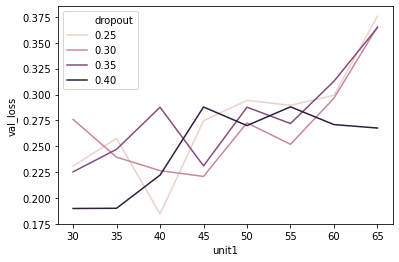

In [135]:
ax3 = sns.lineplot(x="unit1", y="val_loss", hue="dropout" ,data=summ2[summ2['unit2']==summ2['unit1']])

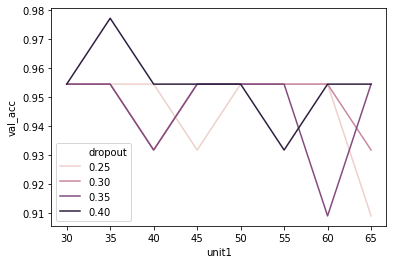

In [137]:
ax4 = sns.lineplot(x="unit1", y="val_acc", hue="dropout" ,data=summ2[summ2['unit2']==summ2['unit1']])

In [138]:
summ3 = pd.DataFrame(columns=['unit1','unit2','dropout','val_loss','val_acc'])

for un1 in np.arange(350, 551, 100):
    for un2 in np.arange(350, 551, 10):
        for dr in np.arange(0.2, 0.5, 0.1):

           # Name the test model
           name = 'unit1=_{}_unit2=_{}_dropout={}'.format(un1,un2,dr)
           print(name)

           # build the model
           model = baseline_model(un1,un2,dr)
        
           # Fit the model
           history = model.fit(x_train, y_train, validation_data=(x_test, y_test),
                     epochs=100, batch_size=32, verbose=1, callbacks=[es])
        
           # Plot the history
           #plot_history(history,name,'acc')
        
           #plot_history(history,name,'loss')
       
           # Print the summary values
           val_loss, val_acc = model.evaluate(x_test,y_test)
            
           line=pd.DataFrame({'unit1':[un1],'unit2':[un2],'dropout':[dr],'val_loss':[val_loss],'val_acc':[val_acc]})                  
           summ3 = summ3.append(line,ignore_index=True)
        

unit1=_350_unit2=_350_dropout=0.2
Model: "sequential_2064"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6192 (Dense)           (None, 350)               10850     
_________________________________________________________________
dropout_4128 (Dropout)       (None, 350)               0         
_________________________________________________________________
batch_normalization_4128 (Ba (None, 350)               1400      
_________________________________________________________________
dense_6193 (Dense)           (None, 350)               122850    
_________________________________________________________________
dropout_4129 (Dropout)       (None, 350)               0         
_________________________________________________________________
batch_normalization_4129 (Ba (None, 350)               1400      
_________________________________________________________________
dense_6194 (Dense

11/11 [==============================] - 0s 10ms/step - loss: 0.7412 - accuracy: 0.9884 - val_loss: 1.0651 - val_accuracy: 0.7500
Epoch 00016: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 1.0651 - accuracy: 0.7500
unit1=_350_unit2=_350_dropout=0.4000000000000001
Model: "sequential_2066"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6198 (Dense)           (None, 350)               10850     
_________________________________________________________________
dropout_4132 (Dropout)       (None, 350)               0         
_________________________________________________________________
batch_normalization_4132 (Ba (None, 350)               1400      
_________________________________________________________________
dense_6199 (Dense)           (None, 350)               122850    
_________________________________________________________________
dropout_4133 (Dropout) 

11/11 [==============================] - 0s 9ms/step - loss: 0.8971 - accuracy: 0.9913 - val_loss: 1.2053 - val_accuracy: 0.7727
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8397 - accuracy: 0.9827 - val_loss: 1.1343 - val_accuracy: 0.7727
Epoch 16/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7506 - accuracy: 0.9884 - val_loss: 1.0662 - val_accuracy: 0.7727
Epoch 17/100
11/11 [==============================] - 0s 11ms/step - loss: 0.7145 - accuracy: 0.9855 - val_loss: 0.9870 - val_accuracy: 0.8409
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6491 - accuracy: 0.9884 - val_loss: 0.9787 - val_accuracy: 0.7500
Epoch 19/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5854 - accuracy: 0.9942 - val_loss: 0.9440 - val_accuracy: 0.7273
Epoch 20/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5524 - accuracy: 0.9827 - val_loss: 0.8635 - val_accuracy: 0.7500
Epoch 21/100
11

11/11 [==============================] - 0s 10ms/step - loss: 0.8887 - accuracy: 0.9769 - val_loss: 1.1176 - val_accuracy: 0.7500
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8288 - accuracy: 0.9682 - val_loss: 1.0265 - val_accuracy: 0.8409
Epoch 16/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7652 - accuracy: 0.9740 - val_loss: 1.0715 - val_accuracy: 0.7045
Epoch 00016: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 1.0715 - accuracy: 0.7045
unit1=_350_unit2=_370_dropout=0.2
Model: "sequential_2070"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6210 (Dense)           (None, 350)               10850     
_________________________________________________________________
dropout_4140 (Dropout)       (None, 350)               0         
_________________________________________________________________
batch_normalizat

11/11 [==============================] - 0s 10ms/step - loss: 0.5977 - accuracy: 0.9855 - val_loss: 0.8967 - val_accuracy: 0.8182
Epoch 20/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5442 - accuracy: 0.9913 - val_loss: 0.8958 - val_accuracy: 0.7273
Epoch 21/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5111 - accuracy: 0.9884 - val_loss: 0.8489 - val_accuracy: 0.7273
Epoch 22/100
11/11 [==============================] - 0s 10ms/step - loss: 0.4716 - accuracy: 0.9913 - val_loss: 0.8328 - val_accuracy: 0.7273
Epoch 23/100
11/11 [==============================] - 0s 10ms/step - loss: 0.4440 - accuracy: 0.9884 - val_loss: 0.7446 - val_accuracy: 0.7955
Epoch 24/100
11/11 [==============================] - 0s 11ms/step - loss: 0.4165 - accuracy: 0.9942 - val_loss: 0.7082 - val_accuracy: 0.8182
Epoch 25/100
11/11 [==============================] - 0s 12ms/step - loss: 0.4313 - accuracy: 0.9827 - val_loss: 0.6372 - val_accuracy: 0.8409
Epoch 26/100

11/11 [==============================] - 0s 9ms/step - loss: 1.7921 - accuracy: 0.9769 - val_loss: 1.8909 - val_accuracy: 0.8864
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5603 - accuracy: 0.9769 - val_loss: 1.7501 - val_accuracy: 0.8409
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 1.3879 - accuracy: 0.9798 - val_loss: 1.5607 - val_accuracy: 0.8864
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 1.2316 - accuracy: 0.9884 - val_loss: 1.4703 - val_accuracy: 0.8409
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1003 - accuracy: 0.9798 - val_loss: 1.3769 - val_accuracy: 0.7955
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9896 - accuracy: 0.9798 - val_loss: 1.2572 - val_accuracy: 0.8409
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8865 - accuracy: 0.9913 - val_loss: 1.1673 - val_accuracy: 0.8409
Epoch 15/100
11/1

11/11 [==============================] - 0s 10ms/step - loss: 2.8183 - accuracy: 0.9595 - val_loss: 2.3564 - val_accuracy: 0.8636
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 2.4490 - accuracy: 0.9595 - val_loss: 2.1365 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 2.1199 - accuracy: 0.9653 - val_loss: 1.9290 - val_accuracy: 0.8409
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8483 - accuracy: 0.9855 - val_loss: 1.7899 - val_accuracy: 0.8182
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 1.6375 - accuracy: 0.9711 - val_loss: 1.6508 - val_accuracy: 0.8182
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.4302 - accuracy: 0.9740 - val_loss: 1.5267 - val_accuracy: 0.7727
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3042 - accuracy: 0.9595 - val_loss: 1.4144 - val_accuracy: 0.7955
Epoch 12/100
11/11 [

11/11 [==============================] - 0s 25ms/step - loss: 5.4461 - accuracy: 0.8237 - val_loss: 3.7680 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.3530 - accuracy: 0.9653 - val_loss: 3.3716 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 3.6631 - accuracy: 0.9509 - val_loss: 2.9548 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 3.0836 - accuracy: 0.9798 - val_loss: 2.6302 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.6450 - accuracy: 0.9740 - val_loss: 2.3498 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.3006 - accuracy: 0.9682 - val_loss: 2.0850 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 1.9895 - accuracy: 0.9769 - val_loss: 1.9207 - val_accuracy: 0.7955
Epoch 8/100
11/11 

11/11 [==============================] - 0s 23ms/step - loss: 5.3770 - accuracy: 0.8613 - val_loss: 3.8298 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.2060 - accuracy: 0.9653 - val_loss: 3.4423 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 3.5667 - accuracy: 0.9422 - val_loss: 3.0283 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.0315 - accuracy: 0.9451 - val_loss: 2.6965 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.6352 - accuracy: 0.9682 - val_loss: 2.4292 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.3234 - accuracy: 0.9595 - val_loss: 2.1815 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.0038 - accuracy: 0.9769 - val_loss: 2.0376 - val_accuracy: 0.7500
Epoch 8/100
11/11 

11/11 [==============================] - 0s 23ms/step - loss: 5.4895 - accuracy: 0.8468 - val_loss: 3.7632 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 4.4469 - accuracy: 0.9335 - val_loss: 3.3200 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 3.7047 - accuracy: 0.9624 - val_loss: 2.8865 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 3.1440 - accuracy: 0.9538 - val_loss: 2.5632 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.6788 - accuracy: 0.9653 - val_loss: 2.2681 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 2.2884 - accuracy: 0.9653 - val_loss: 2.0283 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.9558 - accuracy: 0.9740 - val_loss: 1.8137 - val_accuracy: 0.8636
Epoch 8/100
11/11 [=====

11/11 [==============================] - 0s 23ms/step - loss: 5.4038 - accuracy: 0.8757 - val_loss: 3.8252 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 4.3335 - accuracy: 0.9509 - val_loss: 3.4175 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 3.6038 - accuracy: 0.9653 - val_loss: 2.9698 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.0997 - accuracy: 0.9538 - val_loss: 2.6464 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.6099 - accuracy: 0.9653 - val_loss: 2.3457 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.2593 - accuracy: 0.9624 - val_loss: 2.1086 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 1.9398 - accuracy: 0.9769 - val_loss: 1.9318 - val_accuracy: 0.7273
Epoch 8/100
11/11 [=

11/11 [==============================] - 0s 24ms/step - loss: 5.6778 - accuracy: 0.8092 - val_loss: 3.9506 - val_accuracy: 0.9773
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.5384 - accuracy: 0.9538 - val_loss: 3.5759 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 3.8084 - accuracy: 0.9566 - val_loss: 3.2087 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 3.2498 - accuracy: 0.9653 - val_loss: 2.8839 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.8015 - accuracy: 0.9682 - val_loss: 2.5960 - val_accuracy: 0.8636
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 2.4367 - accuracy: 0.9653 - val_loss: 2.3217 - val_accuracy: 0.8636
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 2.1578 - accuracy: 0.9653 - val_loss: 2.1305 - val_accuracy: 0.7955
Epoch 8/100
11/11 [===

11/11 [==============================] - 0s 10ms/step - loss: 2.7319 - accuracy: 0.9509 - val_loss: 2.3429 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.3122 - accuracy: 0.9769 - val_loss: 2.0873 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 1.9842 - accuracy: 0.9798 - val_loss: 1.8893 - val_accuracy: 0.8409
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7219 - accuracy: 0.9624 - val_loss: 1.7143 - val_accuracy: 0.8409
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5105 - accuracy: 0.9653 - val_loss: 1.5623 - val_accuracy: 0.8409
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3206 - accuracy: 0.9653 - val_loss: 1.4488 - val_accuracy: 0.8182
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1846 - accuracy: 0.9711 - val_loss: 1.3676 - val_accuracy: 0.7955
Epoch 12/100
11/11 

11/11 [==============================] - 0s 11ms/step - loss: 0.3661 - accuracy: 0.9827 - val_loss: 0.5389 - val_accuracy: 0.8864
Epoch 28/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3606 - accuracy: 0.9827 - val_loss: 0.5330 - val_accuracy: 0.9091
Epoch 29/100
11/11 [==============================] - 0s 10ms/step - loss: 0.3129 - accuracy: 0.9942 - val_loss: 0.5424 - val_accuracy: 0.8636
Epoch 00029: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.5424 - accuracy: 0.8636
unit1=_350_unit2=_430_dropout=0.30000000000000004
Model: "sequential_2089"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6267 (Dense)           (None, 350)               10850     
_________________________________________________________________
dropout_4178 (Dropout)       (None, 350)               0         
_________________________________________________________________


2/2 [==============================] - 0s 2ms/step - loss: 1.0790 - accuracy: 0.7273
unit1=_350_unit2=_440_dropout=0.2
Model: "sequential_2091"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6273 (Dense)           (None, 350)               10850     
_________________________________________________________________
dropout_4182 (Dropout)       (None, 350)               0         
_________________________________________________________________
batch_normalization_4182 (Ba (None, 350)               1400      
_________________________________________________________________
dense_6274 (Dense)           (None, 440)               154440    
_________________________________________________________________
dropout_4183 (Dropout)       (None, 440)               0         
_________________________________________________________________
batch_normalization_4183 (Ba (None, 440)               1760     

11/11 [==============================] - 0s 24ms/step - loss: 5.6760 - accuracy: 0.8555 - val_loss: 3.8951 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.5815 - accuracy: 0.9480 - val_loss: 3.4736 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 3.8336 - accuracy: 0.9595 - val_loss: 3.0011 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.2247 - accuracy: 0.9624 - val_loss: 2.6592 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.7278 - accuracy: 0.9624 - val_loss: 2.3328 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.3381 - accuracy: 0.9682 - val_loss: 2.1020 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0122 - accuracy: 0.9538 - val_loss: 1.9022 - val_accuracy: 0.8636
Epoch 8/100
11/11 

11/11 [==============================] - 0s 10ms/step - loss: 2.1043 - accuracy: 0.9798 - val_loss: 2.0632 - val_accuracy: 0.7273
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.8479 - accuracy: 0.9682 - val_loss: 1.8465 - val_accuracy: 0.7955
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 1.6089 - accuracy: 0.9855 - val_loss: 1.7006 - val_accuracy: 0.7955
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.4342 - accuracy: 0.9769 - val_loss: 1.6099 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2608 - accuracy: 0.9884 - val_loss: 1.4826 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1475 - accuracy: 0.9827 - val_loss: 1.3833 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 12ms/step - loss: 1.0212 - accuracy: 0.9827 - val_loss: 1.2645 - val_accuracy: 0.7955
Epoch 14/100
11

11/11 [==============================] - 0s 23ms/step - loss: 5.6304 - accuracy: 0.8613 - val_loss: 4.0687 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.4516 - accuracy: 0.9595 - val_loss: 3.6062 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 3.7156 - accuracy: 0.9653 - val_loss: 3.1888 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.1585 - accuracy: 0.9682 - val_loss: 2.8151 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.6971 - accuracy: 0.9682 - val_loss: 2.4952 - val_accuracy: 0.8636
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 2.3253 - accuracy: 0.9798 - val_loss: 2.2471 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0379 - accuracy: 0.9769 - val_loss: 1.9978 - val_accuracy: 0.8409
Epoch 8/100
11/11 

11/11 [==============================] - 0s 11ms/step - loss: 3.3864 - accuracy: 0.9509 - val_loss: 2.7275 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.9100 - accuracy: 0.9566 - val_loss: 2.4284 - val_accuracy: 0.8636
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4608 - accuracy: 0.9682 - val_loss: 2.1782 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 2.1595 - accuracy: 0.9509 - val_loss: 1.9803 - val_accuracy: 0.7955
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 1.8545 - accuracy: 0.9682 - val_loss: 1.8170 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 13ms/step - loss: 1.6292 - accuracy: 0.9711 - val_loss: 1.6627 - val_accuracy: 0.7500
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.4439 - accuracy: 0.9740 - val_loss: 1.5813 - val_accuracy: 0.7273
Epoch 11/100
11/1

11/11 [==============================] - 0s 10ms/step - loss: 1.9081 - accuracy: 0.9913 - val_loss: 1.9444 - val_accuracy: 0.8636
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.6656 - accuracy: 0.9827 - val_loss: 1.7369 - val_accuracy: 0.8409
Epoch 9/100
11/11 [==============================] - 0s 12ms/step - loss: 1.4243 - accuracy: 0.9942 - val_loss: 1.6015 - val_accuracy: 0.8409
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.2659 - accuracy: 0.9769 - val_loss: 1.4264 - val_accuracy: 0.8409
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 1.1364 - accuracy: 0.9740 - val_loss: 1.3824 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0179 - accuracy: 0.9740 - val_loss: 1.2026 - val_accuracy: 0.8409
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9339 - accuracy: 0.9740 - val_loss: 1.1518 - val_accuracy: 0.8409
Epoch 14/100
11/

11/11 [==============================] - 0s 11ms/step - loss: 1.5315 - accuracy: 0.9769 - val_loss: 1.6943 - val_accuracy: 0.7955
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3396 - accuracy: 0.9855 - val_loss: 1.4885 - val_accuracy: 0.8409
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.2412 - accuracy: 0.9538 - val_loss: 1.3988 - val_accuracy: 0.8182
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1325 - accuracy: 0.9711 - val_loss: 1.2535 - val_accuracy: 0.8409
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0180 - accuracy: 0.9798 - val_loss: 1.1921 - val_accuracy: 0.8409
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9206 - accuracy: 0.9798 - val_loss: 1.1310 - val_accuracy: 0.8409
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8307 - accuracy: 0.9769 - val_loss: 1.0694 - val_accuracy: 0.8409
Epoch 16/100

11/11 [==============================] - 0s 9ms/step - loss: 1.6125 - accuracy: 0.9711 - val_loss: 1.6763 - val_accuracy: 0.7500
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 1.4210 - accuracy: 0.9682 - val_loss: 1.5461 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2822 - accuracy: 0.9624 - val_loss: 1.3913 - val_accuracy: 0.8409
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1590 - accuracy: 0.9624 - val_loss: 1.3385 - val_accuracy: 0.7500
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0254 - accuracy: 0.9855 - val_loss: 1.2582 - val_accuracy: 0.7727
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9343 - accuracy: 0.9855 - val_loss: 1.2196 - val_accuracy: 0.7500
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8531 - accuracy: 0.9884 - val_loss: 1.1100 - val_accuracy: 0.7955
Epoch 16/100
1

11/11 [==============================] - 0s 11ms/step - loss: 1.2148 - accuracy: 0.9769 - val_loss: 1.4672 - val_accuracy: 0.7045
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0736 - accuracy: 0.9855 - val_loss: 1.3071 - val_accuracy: 0.7727
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9435 - accuracy: 0.9942 - val_loss: 1.2957 - val_accuracy: 0.7045
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8421 - accuracy: 0.9884 - val_loss: 1.2205 - val_accuracy: 0.7045
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7758 - accuracy: 0.9798 - val_loss: 1.1495 - val_accuracy: 0.7045
Epoch 16/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7125 - accuracy: 0.9827 - val_loss: 1.0257 - val_accuracy: 0.7955
Epoch 17/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6627 - accuracy: 0.9855 - val_loss: 1.0469 - val_accuracy: 0.7045
Epoch 00017: 

11/11 [==============================] - 0s 10ms/step - loss: 1.8246 - accuracy: 0.9827 - val_loss: 1.8934 - val_accuracy: 0.8182
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5939 - accuracy: 0.9884 - val_loss: 1.7247 - val_accuracy: 0.7955
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.4332 - accuracy: 0.9827 - val_loss: 1.6301 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3286 - accuracy: 0.9538 - val_loss: 1.4380 - val_accuracy: 0.8409
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1753 - accuracy: 0.9798 - val_loss: 1.3287 - val_accuracy: 0.8409
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0745 - accuracy: 0.9769 - val_loss: 1.2620 - val_accuracy: 0.8182
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9280 - accuracy: 0.9884 - val_loss: 1.1894 - val_accuracy: 0.8182
Epoch 15/100


11/11 [==============================] - 0s 10ms/step - loss: 4.8238 - accuracy: 0.9624 - val_loss: 3.5963 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 4.0898 - accuracy: 0.9220 - val_loss: 3.1217 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.4048 - accuracy: 0.9682 - val_loss: 2.7541 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.8910 - accuracy: 0.9624 - val_loss: 2.4391 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 2.5109 - accuracy: 0.9509 - val_loss: 2.1940 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1270 - accuracy: 0.9740 - val_loss: 1.9796 - val_accuracy: 0.8182
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.8845 - accuracy: 0.9653 - val_loss: 1.8076 - val_accuracy: 0.7955
Epoch 9/100
11/11 [=

11/11 [==============================] - 0s 11ms/step - loss: 1.8454 - accuracy: 0.9682 - val_loss: 1.8726 - val_accuracy: 0.8409
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 1.6075 - accuracy: 0.9798 - val_loss: 1.7130 - val_accuracy: 0.8864
Epoch 10/100
11/11 [==============================] - 0s 12ms/step - loss: 1.4345 - accuracy: 0.9798 - val_loss: 1.5664 - val_accuracy: 0.8636
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.2555 - accuracy: 0.9884 - val_loss: 1.4688 - val_accuracy: 0.8409
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 1.1342 - accuracy: 0.9827 - val_loss: 1.3624 - val_accuracy: 0.8409
Epoch 13/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9885 - accuracy: 0.9913 - val_loss: 1.2837 - val_accuracy: 0.8409
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9380 - accuracy: 0.9740 - val_loss: 1.2027 - val_accuracy: 0.7273
Epoch 15/100


11/11 [==============================] - 0s 9ms/step - loss: 3.8280 - accuracy: 0.9624 - val_loss: 3.2183 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.2790 - accuracy: 0.9566 - val_loss: 2.8304 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.7938 - accuracy: 0.9595 - val_loss: 2.5361 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.3854 - accuracy: 0.9769 - val_loss: 2.2991 - val_accuracy: 0.7955
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0692 - accuracy: 0.9798 - val_loss: 2.0593 - val_accuracy: 0.7955
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.8153 - accuracy: 0.9769 - val_loss: 1.7951 - val_accuracy: 0.8409
Epoch 9/100
11/11 [==============================] - 0s 9ms/step - loss: 1.7020 - accuracy: 0.9509 - val_loss: 1.7430 - val_accuracy: 0.7727
Epoch 10/100
11/11 [

11/11 [==============================] - 0s 10ms/step - loss: 4.0354 - accuracy: 0.9509 - val_loss: 3.0649 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.3704 - accuracy: 0.9624 - val_loss: 2.7024 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.8546 - accuracy: 0.9451 - val_loss: 2.3596 - val_accuracy: 0.8636
Epoch 6/100
11/11 [==============================] - 0s 9ms/step - loss: 2.4066 - accuracy: 0.9740 - val_loss: 2.1265 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0601 - accuracy: 0.9711 - val_loss: 1.9035 - val_accuracy: 0.7955
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7838 - accuracy: 0.9682 - val_loss: 1.7627 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5768 - accuracy: 0.9595 - val_loss: 1.6052 - val_accuracy: 0.7500
Epoch 10/100
11/11 [

11/11 [==============================] - 0s 11ms/step - loss: 1.9829 - accuracy: 0.9682 - val_loss: 1.9509 - val_accuracy: 0.7955
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7097 - accuracy: 0.9740 - val_loss: 1.7463 - val_accuracy: 0.7955
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5689 - accuracy: 0.9682 - val_loss: 1.5855 - val_accuracy: 0.8409
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3597 - accuracy: 0.9682 - val_loss: 1.5004 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 1.2051 - accuracy: 0.9740 - val_loss: 1.3842 - val_accuracy: 0.7955
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0837 - accuracy: 0.9740 - val_loss: 1.2581 - val_accuracy: 0.8409
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9630 - accuracy: 0.9855 - val_loss: 1.2642 - val_accuracy: 0.7273
Epoch 00013: ea

11/11 [==============================] - 0s 10ms/step - loss: 1.3825 - accuracy: 0.9855 - val_loss: 1.5874 - val_accuracy: 0.8409
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2450 - accuracy: 0.9740 - val_loss: 1.4328 - val_accuracy: 0.8409
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1069 - accuracy: 0.9855 - val_loss: 1.3556 - val_accuracy: 0.8182
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0433 - accuracy: 0.9595 - val_loss: 1.2512 - val_accuracy: 0.8409
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9599 - accuracy: 0.9798 - val_loss: 1.1336 - val_accuracy: 0.8636
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9134 - accuracy: 0.9682 - val_loss: 1.0777 - val_accuracy: 0.8636
Epoch 16/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7947 - accuracy: 0.9827 - val_loss: 1.0294 - val_accuracy: 0.8636
Epoch 17/100

11/11 [==============================] - 0s 10ms/step - loss: 1.4433 - accuracy: 0.9682 - val_loss: 1.5461 - val_accuracy: 0.7955
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2706 - accuracy: 0.9740 - val_loss: 1.4683 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1695 - accuracy: 0.9653 - val_loss: 1.3474 - val_accuracy: 0.7500
Epoch 13/100
11/11 [==============================] - 0s 11ms/step - loss: 1.0415 - accuracy: 0.9798 - val_loss: 1.2473 - val_accuracy: 0.7727
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9791 - accuracy: 0.9682 - val_loss: 1.1723 - val_accuracy: 0.7955
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8967 - accuracy: 0.9711 - val_loss: 1.1155 - val_accuracy: 0.7955
Epoch 16/100
11/11 [==============================] - 0s 11ms/step - loss: 0.7988 - accuracy: 0.9913 - val_loss: 1.1241 - val_accuracy: 0.7273
Epoch 00016:

11/11 [==============================] - 0s 11ms/step - loss: 1.0193 - accuracy: 0.9855 - val_loss: 1.2564 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9173 - accuracy: 0.9798 - val_loss: 1.2102 - val_accuracy: 0.7273
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8128 - accuracy: 0.9913 - val_loss: 1.1488 - val_accuracy: 0.7273
Epoch 16/100
11/11 [==============================] - 0s 9ms/step - loss: 0.7445 - accuracy: 0.9855 - val_loss: 1.0872 - val_accuracy: 0.7273
Epoch 17/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6821 - accuracy: 0.9884 - val_loss: 1.0272 - val_accuracy: 0.7273
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6288 - accuracy: 0.9913 - val_loss: 1.0241 - val_accuracy: 0.7273
Epoch 19/100
11/11 [==============================] - 0s 10ms/step - loss: 0.5989 - accuracy: 0.9827 - val_loss: 0.9011 - val_accuracy: 0.7955
Epoch 20/100
1

11/11 [==============================] - 0s 10ms/step - loss: 1.6868 - accuracy: 0.9884 - val_loss: 1.8209 - val_accuracy: 0.8182
Epoch 10/100
11/11 [==============================] - 0s 9ms/step - loss: 1.5110 - accuracy: 0.9827 - val_loss: 1.6997 - val_accuracy: 0.7727
Epoch 11/100
11/11 [==============================] - 0s 9ms/step - loss: 1.3536 - accuracy: 0.9740 - val_loss: 1.6090 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2150 - accuracy: 0.9884 - val_loss: 1.4835 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0969 - accuracy: 0.9827 - val_loss: 1.4194 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 9ms/step - loss: 1.0068 - accuracy: 0.9798 - val_loss: 1.2573 - val_accuracy: 0.8409
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.9069 - accuracy: 0.9971 - val_loss: 1.2504 - val_accuracy: 0.7273
Epoch 16/100
11/

11/11 [==============================] - 0s 23ms/step - loss: 5.8148 - accuracy: 0.8324 - val_loss: 3.9980 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.7208 - accuracy: 0.9335 - val_loss: 3.5587 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 4.0210 - accuracy: 0.9306 - val_loss: 3.1394 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 3.4353 - accuracy: 0.9595 - val_loss: 2.8018 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.9268 - accuracy: 0.9624 - val_loss: 2.5208 - val_accuracy: 0.8182
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.5556 - accuracy: 0.9393 - val_loss: 2.2601 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.2169 - accuracy: 0.9653 - val_loss: 2.0705 - val_accuracy: 0.7955
Epoch 8/100
11/11 [=

11/11 [==============================] - 0s 23ms/step - loss: 5.8194 - accuracy: 0.8468 - val_loss: 4.0849 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.6779 - accuracy: 0.9451 - val_loss: 3.6378 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 3.9204 - accuracy: 0.9480 - val_loss: 3.2001 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 3.3243 - accuracy: 0.9595 - val_loss: 2.8515 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 9ms/step - loss: 2.8449 - accuracy: 0.9769 - val_loss: 2.5266 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.4318 - accuracy: 0.9855 - val_loss: 2.3053 - val_accuracy: 0.7727
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0960 - accuracy: 0.9855 - val_loss: 2.1110 - val_accuracy: 0.7273
Epoch 8/100
11/11 [=

11/11 [==============================] - 0s 25ms/step - loss: 5.7480 - accuracy: 0.8555 - val_loss: 4.2007 - val_accuracy: 0.8864
Epoch 2/100
11/11 [==============================] - 0s 9ms/step - loss: 4.5535 - accuracy: 0.9682 - val_loss: 3.7373 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 9ms/step - loss: 3.8743 - accuracy: 0.9509 - val_loss: 3.3514 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 9ms/step - loss: 3.3675 - accuracy: 0.9538 - val_loss: 3.0130 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.8899 - accuracy: 0.9769 - val_loss: 2.6893 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.5190 - accuracy: 0.9769 - val_loss: 2.4383 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 9ms/step - loss: 2.2041 - accuracy: 0.9711 - val_loss: 2.2133 - val_accuracy: 0.8409
Epoch 8/100
11/11 [===

11/11 [==============================] - 0s 10ms/step - loss: 4.7746 - accuracy: 0.9422 - val_loss: 3.6169 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 3.9812 - accuracy: 0.9595 - val_loss: 3.1435 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.3710 - accuracy: 0.9595 - val_loss: 2.7906 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.8526 - accuracy: 0.9682 - val_loss: 2.4688 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.4236 - accuracy: 0.9711 - val_loss: 2.2179 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0554 - accuracy: 0.9769 - val_loss: 2.0045 - val_accuracy: 0.7500
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 1.8017 - accuracy: 0.9711 - val_loss: 1.8403 - val_accuracy: 0.7273
Epoch 9/100
11/11 

11/11 [==============================] - 0s 10ms/step - loss: 3.3408 - accuracy: 0.9711 - val_loss: 2.8599 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.8246 - accuracy: 0.9769 - val_loss: 2.5510 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.4817 - accuracy: 0.9566 - val_loss: 2.2855 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1339 - accuracy: 0.9538 - val_loss: 2.0560 - val_accuracy: 0.8182
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 1.8913 - accuracy: 0.9538 - val_loss: 1.8905 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 1.6490 - accuracy: 0.9769 - val_loss: 1.7510 - val_accuracy: 0.7500
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.4926 - accuracy: 0.9798 - val_loss: 1.6434 - val_accuracy: 0.7273
Epoch 11/100
11/1

11/11 [==============================] - 0s 10ms/step - loss: 0.3717 - accuracy: 0.9827 - val_loss: 0.6731 - val_accuracy: 0.7727
Epoch 00030: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.6731 - accuracy: 0.7727
unit1=_450_unit2=_390_dropout=0.2
Model: "sequential_2139"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6417 (Dense)           (None, 450)               13950     
_________________________________________________________________
dropout_4278 (Dropout)       (None, 450)               0         
_________________________________________________________________
batch_normalization_4278 (Ba (None, 450)               1800      
_________________________________________________________________
dense_6418 (Dense)           (None, 390)               175890    
_________________________________________________________________
dropout_4279 (Dropout)       (None, 39

11/11 [==============================] - 0s 25ms/step - loss: 6.0257 - accuracy: 0.8671 - val_loss: 4.1111 - val_accuracy: 0.9773
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.8633 - accuracy: 0.9451 - val_loss: 3.6215 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 4.0172 - accuracy: 0.9653 - val_loss: 3.1576 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.3667 - accuracy: 0.9595 - val_loss: 2.7992 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.8443 - accuracy: 0.9653 - val_loss: 2.4744 - val_accuracy: 0.7955
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 2.4197 - accuracy: 0.9566 - val_loss: 2.1944 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0570 - accuracy: 0.9653 - val_loss: 1.9820 - val_accuracy: 0.7500
Epoch 8/100
11/11 

11/11 [==============================] - 0s 10ms/step - loss: 3.5051 - accuracy: 0.9624 - val_loss: 2.9868 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.0149 - accuracy: 0.9509 - val_loss: 2.6639 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.6112 - accuracy: 0.9624 - val_loss: 2.3979 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.2455 - accuracy: 0.9740 - val_loss: 2.1885 - val_accuracy: 0.7955
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0026 - accuracy: 0.9451 - val_loss: 1.9649 - val_accuracy: 0.8182
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7443 - accuracy: 0.9769 - val_loss: 1.8491 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5641 - accuracy: 0.9769 - val_loss: 1.6941 - val_accuracy: 0.7500
Epoch 11/100
11/1

11/11 [==============================] - 0s 11ms/step - loss: 3.3698 - accuracy: 0.9855 - val_loss: 3.0128 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 2.8817 - accuracy: 0.9682 - val_loss: 2.6831 - val_accuracy: 0.8182
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 2.4647 - accuracy: 0.9769 - val_loss: 2.3790 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1263 - accuracy: 0.9798 - val_loss: 2.1914 - val_accuracy: 0.7045
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 1.8448 - accuracy: 0.9798 - val_loss: 1.9507 - val_accuracy: 0.7273
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.6083 - accuracy: 0.9798 - val_loss: 1.7860 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.4189 - accuracy: 0.9884 - val_loss: 1.6575 - val_accuracy: 0.7045
Epoch 11/100
11/1

11/11 [==============================] - 0s 10ms/step - loss: 1.4001 - accuracy: 0.9566 - val_loss: 1.5515 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2442 - accuracy: 0.9682 - val_loss: 1.4568 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 11ms/step - loss: 1.1159 - accuracy: 0.9769 - val_loss: 1.3637 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 1.0328 - accuracy: 0.9711 - val_loss: 1.3189 - val_accuracy: 0.7045
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9389 - accuracy: 0.9798 - val_loss: 1.2222 - val_accuracy: 0.7273
Epoch 16/100
11/11 [==============================] - 0s 12ms/step - loss: 0.9080 - accuracy: 0.9653 - val_loss: 1.1457 - val_accuracy: 0.7955
Epoch 17/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8154 - accuracy: 0.9711 - val_loss: 1.1148 - val_accuracy: 0.7273
Epoch 18/100

11/11 [==============================] - 0s 11ms/step - loss: 1.0066 - accuracy: 0.9682 - val_loss: 1.2492 - val_accuracy: 0.7955
Epoch 15/100
11/11 [==============================] - 0s 12ms/step - loss: 0.9240 - accuracy: 0.9855 - val_loss: 1.1844 - val_accuracy: 0.7500
Epoch 16/100
11/11 [==============================] - 0s 11ms/step - loss: 0.8205 - accuracy: 0.9855 - val_loss: 1.1555 - val_accuracy: 0.7273
Epoch 17/100
11/11 [==============================] - 0s 11ms/step - loss: 0.7592 - accuracy: 0.9798 - val_loss: 1.0866 - val_accuracy: 0.7273
Epoch 18/100
11/11 [==============================] - 0s 11ms/step - loss: 0.7164 - accuracy: 0.9798 - val_loss: 1.0147 - val_accuracy: 0.7273
Epoch 19/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6800 - accuracy: 0.9740 - val_loss: 0.9157 - val_accuracy: 0.8409
Epoch 20/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6281 - accuracy: 0.9855 - val_loss: 0.9441 - val_accuracy: 0.7273
Epoch 00020:

11/11 [==============================] - 0s 12ms/step - loss: 1.1992 - accuracy: 0.9884 - val_loss: 1.4443 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0435 - accuracy: 0.9913 - val_loss: 1.3733 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9382 - accuracy: 0.9855 - val_loss: 1.3266 - val_accuracy: 0.7045
Epoch 15/100
11/11 [==============================] - 0s 12ms/step - loss: 0.8555 - accuracy: 0.9942 - val_loss: 1.2387 - val_accuracy: 0.7045
Epoch 16/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7759 - accuracy: 0.9913 - val_loss: 1.1515 - val_accuracy: 0.7045
Epoch 17/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6949 - accuracy: 0.9913 - val_loss: 1.1374 - val_accuracy: 0.7045
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6516 - accuracy: 0.9884 - val_loss: 1.0268 - val_accuracy: 0.7273
Epoch 19/100

11/11 [==============================] - 0s 10ms/step - loss: 1.2529 - accuracy: 0.9653 - val_loss: 1.4794 - val_accuracy: 0.7045
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1319 - accuracy: 0.9595 - val_loss: 1.3421 - val_accuracy: 0.7727
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0138 - accuracy: 0.9884 - val_loss: 1.2841 - val_accuracy: 0.7273
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9471 - accuracy: 0.9769 - val_loss: 1.2288 - val_accuracy: 0.7273
Epoch 16/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9286 - accuracy: 0.9538 - val_loss: 1.1478 - val_accuracy: 0.7727
Epoch 17/100
11/11 [==============================] - 0s 11ms/step - loss: 0.8586 - accuracy: 0.9711 - val_loss: 1.0754 - val_accuracy: 0.7955
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7640 - accuracy: 0.9855 - val_loss: 1.0281 - val_accuracy: 0.8409
Epoch 19/100

11/11 [==============================] - 0s 11ms/step - loss: 1.0893 - accuracy: 0.9682 - val_loss: 1.2560 - val_accuracy: 0.8409
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9665 - accuracy: 0.9827 - val_loss: 1.2440 - val_accuracy: 0.7273
Epoch 16/100
11/11 [==============================] - 0s 11ms/step - loss: 0.8818 - accuracy: 0.9798 - val_loss: 1.1713 - val_accuracy: 0.7273
Epoch 17/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8074 - accuracy: 0.9827 - val_loss: 1.1076 - val_accuracy: 0.7273
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7135 - accuracy: 0.9942 - val_loss: 1.1069 - val_accuracy: 0.7273
Epoch 19/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6761 - accuracy: 0.9769 - val_loss: 1.0320 - val_accuracy: 0.7273
Epoch 20/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6240 - accuracy: 0.9827 - val_loss: 0.9759 - val_accuracy: 0.7273
Epoch 21/100

11/11 [==============================] - 0s 11ms/step - loss: 1.2832 - accuracy: 0.9769 - val_loss: 1.5294 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 12ms/step - loss: 1.1723 - accuracy: 0.9682 - val_loss: 1.5052 - val_accuracy: 0.7045
Epoch 14/100
11/11 [==============================] - 0s 11ms/step - loss: 1.0978 - accuracy: 0.9827 - val_loss: 1.2408 - val_accuracy: 0.8409
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9996 - accuracy: 0.9827 - val_loss: 1.2946 - val_accuracy: 0.7273
Epoch 00015: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 1.2946 - accuracy: 0.7273
unit1=_450_unit2=_450_dropout=0.30000000000000004
Model: "sequential_2158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6474 (Dense)           (None, 450)               13950     
_______________________________________________________

11/11 [==============================] - 0s 10ms/step - loss: 0.8125 - accuracy: 0.9798 - val_loss: 1.0827 - val_accuracy: 0.8182
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7859 - accuracy: 0.9595 - val_loss: 1.0421 - val_accuracy: 0.7500
Epoch 19/100
11/11 [==============================] - 0s 11ms/step - loss: 0.7031 - accuracy: 0.9827 - val_loss: 0.9698 - val_accuracy: 0.8409
Epoch 20/100
11/11 [==============================] - 0s 9ms/step - loss: 0.6925 - accuracy: 0.9682 - val_loss: 0.9375 - val_accuracy: 0.8182
Epoch 21/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6092 - accuracy: 0.9913 - val_loss: 0.9718 - val_accuracy: 0.7045
Epoch 00021: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.9718 - accuracy: 0.7045
unit1=_450_unit2=_460_dropout=0.2
Model: "sequential_2160"
_________________________________________________________________
Layer (type)                 Output Shape              Param 

2/2 [==============================] - 0s 3ms/step - loss: 1.2690 - accuracy: 0.7273
unit1=_450_unit2=_460_dropout=0.4000000000000001
Model: "sequential_2162"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6486 (Dense)           (None, 450)               13950     
_________________________________________________________________
dropout_4324 (Dropout)       (None, 450)               0         
_________________________________________________________________
batch_normalization_4324 (Ba (None, 450)               1800      
_________________________________________________________________
dense_6487 (Dense)           (None, 460)               207460    
_________________________________________________________________
dropout_4325 (Dropout)       (None, 460)               0         
_________________________________________________________________
batch_normalization_4325 (Ba (None, 460)         

2/2 [==============================] - 0s 2ms/step - loss: 1.2343 - accuracy: 0.7045
unit1=_450_unit2=_470_dropout=0.30000000000000004
Model: "sequential_2164"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6492 (Dense)           (None, 450)               13950     
_________________________________________________________________
dropout_4328 (Dropout)       (None, 450)               0         
_________________________________________________________________
batch_normalization_4328 (Ba (None, 450)               1800      
_________________________________________________________________
dense_6493 (Dense)           (None, 470)               211970    
_________________________________________________________________
dropout_4329 (Dropout)       (None, 470)               0         
_________________________________________________________________
batch_normalization_4329 (Ba (None, 470)        

11/11 [==============================] - 0s 10ms/step - loss: 0.7404 - accuracy: 0.9798 - val_loss: 1.0234 - val_accuracy: 0.8409
Epoch 19/100
11/11 [==============================] - 0s 11ms/step - loss: 0.6906 - accuracy: 0.9855 - val_loss: 1.0633 - val_accuracy: 0.7273
Epoch 00019: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 1.0633 - accuracy: 0.7273
unit1=_450_unit2=_480_dropout=0.2
Model: "sequential_2166"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6498 (Dense)           (None, 450)               13950     
_________________________________________________________________
dropout_4332 (Dropout)       (None, 450)               0         
_________________________________________________________________
batch_normalization_4332 (Ba (None, 450)               1800      
_________________________________________________________________
dense_6499 (Dense)         

11/11 [==============================] - 0s 10ms/step - loss: 0.8331 - accuracy: 0.9769 - val_loss: 1.1057 - val_accuracy: 0.7500
Epoch 18/100
11/11 [==============================] - 0s 10ms/step - loss: 0.7498 - accuracy: 0.9855 - val_loss: 1.0567 - val_accuracy: 0.7500
Epoch 19/100
11/11 [==============================] - 0s 10ms/step - loss: 0.6841 - accuracy: 0.9884 - val_loss: 1.0977 - val_accuracy: 0.7045
Epoch 00019: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 1.0977 - accuracy: 0.7045
unit1=_450_unit2=_480_dropout=0.4000000000000001
Model: "sequential_2168"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6504 (Dense)           (None, 450)               13950     
_________________________________________________________________
dropout_4336 (Dropout)       (None, 450)               0         
_________________________________________________________________
b

11/11 [==============================] - 0s 10ms/step - loss: 1.7518 - accuracy: 0.9711 - val_loss: 1.8752 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.5350 - accuracy: 0.9855 - val_loss: 1.7161 - val_accuracy: 0.7500
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.3548 - accuracy: 0.9884 - val_loss: 1.6237 - val_accuracy: 0.7045
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1934 - accuracy: 0.9913 - val_loss: 1.5042 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0837 - accuracy: 0.9884 - val_loss: 1.3797 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9666 - accuracy: 0.9913 - val_loss: 1.3032 - val_accuracy: 0.7273
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8827 - accuracy: 0.9855 - val_loss: 1.2655 - val_accuracy: 0.7273
Epoch 16/100

11/11 [==============================] - 0s 10ms/step - loss: 3.0947 - accuracy: 0.9798 - val_loss: 2.6596 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.6187 - accuracy: 0.9711 - val_loss: 2.3530 - val_accuracy: 0.7727
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.2562 - accuracy: 0.9682 - val_loss: 2.1097 - val_accuracy: 0.7727
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 1.9395 - accuracy: 0.9653 - val_loss: 1.8968 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.6791 - accuracy: 0.9740 - val_loss: 1.7576 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.4479 - accuracy: 0.9913 - val_loss: 1.6262 - val_accuracy: 0.7045
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.2712 - accuracy: 0.9855 - val_loss: 1.5032 - val_accuracy: 0.7045
Epoch 12/100
11/

11/11 [==============================] - 0s 11ms/step - loss: 2.6328 - accuracy: 0.9740 - val_loss: 2.4519 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.2776 - accuracy: 0.9653 - val_loss: 2.1587 - val_accuracy: 0.7955
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.9777 - accuracy: 0.9740 - val_loss: 1.9651 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7180 - accuracy: 0.9711 - val_loss: 1.8092 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.4971 - accuracy: 0.9855 - val_loss: 1.6913 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3409 - accuracy: 0.9653 - val_loss: 1.5422 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 1.1785 - accuracy: 0.9884 - val_loss: 1.4738 - val_accuracy: 0.7045
Epoch 13/100
11

11/11 [==============================] - 0s 25ms/step - loss: 6.8388 - accuracy: 0.8613 - val_loss: 4.8016 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 5.3919 - accuracy: 0.9451 - val_loss: 4.2845 - val_accuracy: 0.8864
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.5072 - accuracy: 0.9653 - val_loss: 3.7852 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.8194 - accuracy: 0.9798 - val_loss: 3.3642 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.2594 - accuracy: 0.9827 - val_loss: 2.9875 - val_accuracy: 0.8182
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.8162 - accuracy: 0.9711 - val_loss: 2.6497 - val_accuracy: 0.7955
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4322 - accuracy: 0.9769 - val_loss: 2.3964 - val_accuracy: 0.7273
Epoch 8/100
11/11 

11/11 [==============================] - 0s 11ms/step - loss: 2.7070 - accuracy: 0.9653 - val_loss: 2.4454 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 2.3234 - accuracy: 0.9682 - val_loss: 2.1708 - val_accuracy: 0.8409
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 1.9702 - accuracy: 0.9827 - val_loss: 2.0265 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7102 - accuracy: 0.9798 - val_loss: 1.8089 - val_accuracy: 0.8182
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5006 - accuracy: 0.9769 - val_loss: 1.6954 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.3389 - accuracy: 0.9827 - val_loss: 1.5491 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 1.1942 - accuracy: 0.9798 - val_loss: 1.4513 - val_accuracy: 0.7273
Epoch 13/100
11

11/11 [==============================] - 0s 26ms/step - loss: 6.9355 - accuracy: 0.8555 - val_loss: 4.7880 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 13ms/step - loss: 5.4563 - accuracy: 0.9595 - val_loss: 4.2397 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.5830 - accuracy: 0.9451 - val_loss: 3.6849 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 3.8738 - accuracy: 0.9480 - val_loss: 3.2500 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.2798 - accuracy: 0.9711 - val_loss: 2.8714 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.8054 - accuracy: 0.9769 - val_loss: 2.5706 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.3883 - accuracy: 0.9769 - val_loss: 2.3405 - val_accuracy: 0.7273
Epoch 8/100
11/11 

11/11 [==============================] - 0s 25ms/step - loss: 6.6563 - accuracy: 0.9046 - val_loss: 4.8384 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 5.2625 - accuracy: 0.9335 - val_loss: 4.2338 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 4.3924 - accuracy: 0.9653 - val_loss: 3.7464 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 3.6898 - accuracy: 0.9769 - val_loss: 3.2697 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.1009 - accuracy: 0.9827 - val_loss: 2.9119 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.6397 - accuracy: 0.9913 - val_loss: 2.5564 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.2474 - accuracy: 0.9855 - val_loss: 2.2856 - val_accuracy: 0.7273
Epoch 8/100
11/11 

11/11 [==============================] - 0s 27ms/step - loss: 7.0658 - accuracy: 0.8439 - val_loss: 4.7696 - val_accuracy: 0.9773
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 5.7192 - accuracy: 0.9335 - val_loss: 4.2141 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.7520 - accuracy: 0.9538 - val_loss: 3.6419 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.9638 - accuracy: 0.9798 - val_loss: 3.2120 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.3551 - accuracy: 0.9566 - val_loss: 2.8124 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.8442 - accuracy: 0.9740 - val_loss: 2.5240 - val_accuracy: 0.7727
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.4385 - accuracy: 0.9682 - val_loss: 2.2554 - val_accuracy: 0.7727
Epoch 8/100
11/11 

11/11 [==============================] - 0s 15ms/step - loss: 3.2310 - accuracy: 0.9682 - val_loss: 2.8491 - val_accuracy: 0.7500
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 2.7401 - accuracy: 0.9740 - val_loss: 2.5436 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 14ms/step - loss: 2.3476 - accuracy: 0.9827 - val_loss: 2.3097 - val_accuracy: 0.7045
Epoch 8/100
11/11 [==============================] - 0s 16ms/step - loss: 2.0404 - accuracy: 0.9595 - val_loss: 2.0628 - val_accuracy: 0.7045
Epoch 9/100
11/11 [==============================] - 0s 14ms/step - loss: 1.7748 - accuracy: 0.9740 - val_loss: 1.9497 - val_accuracy: 0.7045
Epoch 10/100
11/11 [==============================] - 0s 13ms/step - loss: 1.6071 - accuracy: 0.9653 - val_loss: 1.7316 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 13ms/step - loss: 1.4227 - accuracy: 0.9711 - val_loss: 1.6896 - val_accuracy: 0.7045
Epoch 12/100
11/

11/11 [==============================] - 0s 12ms/step - loss: 3.0743 - accuracy: 0.9740 - val_loss: 2.8591 - val_accuracy: 0.8182
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 2.5971 - accuracy: 0.9855 - val_loss: 2.5093 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.2418 - accuracy: 0.9653 - val_loss: 2.2331 - val_accuracy: 0.7955
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 1.9333 - accuracy: 0.9827 - val_loss: 2.0331 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 13ms/step - loss: 1.7173 - accuracy: 0.9711 - val_loss: 1.8337 - val_accuracy: 0.7500
Epoch 10/100
11/11 [==============================] - 0s 14ms/step - loss: 1.5257 - accuracy: 0.9798 - val_loss: 1.6621 - val_accuracy: 0.7955
Epoch 11/100
11/11 [==============================] - 0s 14ms/step - loss: 1.3359 - accuracy: 0.9855 - val_loss: 1.5681 - val_accuracy: 0.7273
Epoch 12/100
11/

11/11 [==============================] - 0s 12ms/step - loss: 2.0369 - accuracy: 0.9682 - val_loss: 2.0166 - val_accuracy: 0.7273
Epoch 9/100
11/11 [==============================] - 0s 12ms/step - loss: 1.7806 - accuracy: 0.9653 - val_loss: 1.8383 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 13ms/step - loss: 1.5772 - accuracy: 0.9653 - val_loss: 1.6963 - val_accuracy: 0.7045
Epoch 11/100
11/11 [==============================] - 0s 13ms/step - loss: 1.4113 - accuracy: 0.9595 - val_loss: 1.5792 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 12ms/step - loss: 1.2713 - accuracy: 0.9769 - val_loss: 1.5002 - val_accuracy: 0.7045
Epoch 13/100
11/11 [==============================] - 0s 12ms/step - loss: 1.1051 - accuracy: 0.9855 - val_loss: 1.4224 - val_accuracy: 0.7045
Epoch 14/100
11/11 [==============================] - 0s 12ms/step - loss: 0.9865 - accuracy: 0.9942 - val_loss: 1.3280 - val_accuracy: 0.7273
Epoch 15/100


11/11 [==============================] - 0s 10ms/step - loss: 4.8473 - accuracy: 0.9364 - val_loss: 3.8045 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.0702 - accuracy: 0.9624 - val_loss: 3.3800 - val_accuracy: 0.8864
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 3.4455 - accuracy: 0.9451 - val_loss: 2.9741 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 12ms/step - loss: 2.9443 - accuracy: 0.9769 - val_loss: 2.6760 - val_accuracy: 0.7273
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4960 - accuracy: 0.9740 - val_loss: 2.3807 - val_accuracy: 0.7500
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1628 - accuracy: 0.9798 - val_loss: 2.1547 - val_accuracy: 0.7273
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.8574 - accuracy: 0.9884 - val_loss: 1.9865 - val_accuracy: 0.7045
Epoch 9/100
11/11 

11/11 [==============================] - 0s 30ms/step - loss: 6.1834 - accuracy: 0.8468 - val_loss: 4.4803 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 14ms/step - loss: 4.9429 - accuracy: 0.9595 - val_loss: 3.9928 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 15ms/step - loss: 4.1863 - accuracy: 0.9538 - val_loss: 3.6043 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 3.5696 - accuracy: 0.9740 - val_loss: 3.1916 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 14ms/step - loss: 3.0749 - accuracy: 0.9798 - val_loss: 2.8669 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 15ms/step - loss: 2.6920 - accuracy: 0.9740 - val_loss: 2.5921 - val_accuracy: 0.7955
Epoch 7/100
11/11 [==============================] - 0s 13ms/step - loss: 2.3237 - accuracy: 0.9827 - val_loss: 2.3327 - val_accuracy: 0.8182
Epoch 8/100
11/11 

11/11 [==============================] - 0s 10ms/step - loss: 5.0298 - accuracy: 0.9306 - val_loss: 3.8340 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 4.2064 - accuracy: 0.9509 - val_loss: 3.3433 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.5451 - accuracy: 0.9624 - val_loss: 2.9516 - val_accuracy: 0.9091
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 2.9723 - accuracy: 0.9538 - val_loss: 2.6054 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.5366 - accuracy: 0.9653 - val_loss: 2.3191 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.1564 - accuracy: 0.9595 - val_loss: 2.0937 - val_accuracy: 0.8182
Epoch 8/100
11/11 [==============================] - 0s 9ms/step - loss: 1.8485 - accuracy: 0.9769 - val_loss: 1.9213 - val_accuracy: 0.7273
Epoch 9/100
11/11 [

11/11 [==============================] - 0s 10ms/step - loss: 5.1104 - accuracy: 0.9509 - val_loss: 3.9979 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 4.2964 - accuracy: 0.9624 - val_loss: 3.5752 - val_accuracy: 0.9545
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.6927 - accuracy: 0.9451 - val_loss: 3.1698 - val_accuracy: 0.9545
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.1407 - accuracy: 0.9769 - val_loss: 2.8634 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.7208 - accuracy: 0.9624 - val_loss: 2.5719 - val_accuracy: 0.8864
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.3729 - accuracy: 0.9566 - val_loss: 2.3138 - val_accuracy: 0.8636
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 2.1012 - accuracy: 0.9624 - val_loss: 2.1052 - val_accuracy: 0.8409
Epoch 9/100
11/11 

11/11 [==============================] - 0s 23ms/step - loss: 6.1898 - accuracy: 0.8988 - val_loss: 4.5791 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 4.9645 - accuracy: 0.9480 - val_loss: 4.0350 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 4.1941 - accuracy: 0.9480 - val_loss: 3.5999 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.5696 - accuracy: 0.9682 - val_loss: 3.2105 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.0678 - accuracy: 0.9711 - val_loss: 2.8909 - val_accuracy: 0.7273
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.6313 - accuracy: 0.9769 - val_loss: 2.5842 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.3150 - accuracy: 0.9624 - val_loss: 2.3172 - val_accuracy: 0.7500
Epoch 8/100
11/11 

11/11 [==============================] - 0s 10ms/step - loss: 3.7257 - accuracy: 0.9480 - val_loss: 3.0538 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.1763 - accuracy: 0.9624 - val_loss: 2.7337 - val_accuracy: 0.7955
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.6814 - accuracy: 0.9798 - val_loss: 2.4543 - val_accuracy: 0.7955
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.3087 - accuracy: 0.9769 - val_loss: 2.2180 - val_accuracy: 0.7500
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0138 - accuracy: 0.9740 - val_loss: 2.0113 - val_accuracy: 0.7500
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7509 - accuracy: 0.9711 - val_loss: 1.8386 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.5569 - accuracy: 0.9682 - val_loss: 1.7232 - val_accuracy: 0.7045
Epoch 11/100
11/1

11/11 [==============================] - 0s 11ms/step - loss: 1.3726 - accuracy: 0.9855 - val_loss: 1.6444 - val_accuracy: 0.7045
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2307 - accuracy: 0.9827 - val_loss: 1.5340 - val_accuracy: 0.7045
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1498 - accuracy: 0.9711 - val_loss: 1.4262 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0506 - accuracy: 0.9711 - val_loss: 1.3284 - val_accuracy: 0.7273
Epoch 15/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9806 - accuracy: 0.9711 - val_loss: 1.2481 - val_accuracy: 0.7273
Epoch 16/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8918 - accuracy: 0.9769 - val_loss: 1.2260 - val_accuracy: 0.7273
Epoch 17/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8411 - accuracy: 0.9682 - val_loss: 1.0846 - val_accuracy: 0.8409
Epoch 18/100

11/11 [==============================] - 0s 10ms/step - loss: 1.7873 - accuracy: 0.9798 - val_loss: 1.9654 - val_accuracy: 0.7045
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.5784 - accuracy: 0.9827 - val_loss: 1.7026 - val_accuracy: 0.8409
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.4246 - accuracy: 0.9827 - val_loss: 1.6614 - val_accuracy: 0.7045
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 1.2506 - accuracy: 0.9884 - val_loss: 1.5506 - val_accuracy: 0.7045
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1350 - accuracy: 0.9711 - val_loss: 1.4649 - val_accuracy: 0.7045
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0331 - accuracy: 0.9884 - val_loss: 1.2901 - val_accuracy: 0.8182
Epoch 15/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9444 - accuracy: 0.9827 - val_loss: 1.2956 - val_accuracy: 0.7045
Epoch 00015:

11/11 [==============================] - 0s 10ms/step - loss: 1.4879 - accuracy: 0.9769 - val_loss: 1.6477 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3455 - accuracy: 0.9653 - val_loss: 1.5434 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1879 - accuracy: 0.9682 - val_loss: 1.4324 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0752 - accuracy: 0.9798 - val_loss: 1.3769 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9724 - accuracy: 0.9827 - val_loss: 1.2897 - val_accuracy: 0.7273
Epoch 15/100
11/11 [==============================] - 0s 9ms/step - loss: 0.8774 - accuracy: 0.9855 - val_loss: 1.2422 - val_accuracy: 0.7045
Epoch 16/100
11/11 [==============================] - 0s 12ms/step - loss: 0.8081 - accuracy: 0.9827 - val_loss: 1.1366 - val_accuracy: 0.7273
Epoch 17/100


11/11 [==============================] - 0s 11ms/step - loss: 2.3258 - accuracy: 0.9624 - val_loss: 2.2501 - val_accuracy: 0.7273
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.9914 - accuracy: 0.9827 - val_loss: 2.0550 - val_accuracy: 0.7273
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.7281 - accuracy: 0.9884 - val_loss: 1.8933 - val_accuracy: 0.7045
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.5299 - accuracy: 0.9769 - val_loss: 1.7484 - val_accuracy: 0.7045
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.3384 - accuracy: 0.9942 - val_loss: 1.6124 - val_accuracy: 0.7045
Epoch 12/100
11/11 [==============================] - 0s 12ms/step - loss: 1.1763 - accuracy: 0.9942 - val_loss: 1.5211 - val_accuracy: 0.7045
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0482 - accuracy: 0.9827 - val_loss: 1.4438 - val_accuracy: 0.7045
Epoch 14/100
1

11/11 [==============================] - 0s 11ms/step - loss: 3.1853 - accuracy: 0.9884 - val_loss: 2.9747 - val_accuracy: 0.7500
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.7391 - accuracy: 0.9769 - val_loss: 2.6607 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.3647 - accuracy: 0.9855 - val_loss: 2.3984 - val_accuracy: 0.7045
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0437 - accuracy: 0.9798 - val_loss: 2.1455 - val_accuracy: 0.7273
Epoch 9/100
11/11 [==============================] - 0s 10ms/step - loss: 1.8325 - accuracy: 0.9653 - val_loss: 1.9460 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.6306 - accuracy: 0.9884 - val_loss: 1.8191 - val_accuracy: 0.7045
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.4147 - accuracy: 0.9913 - val_loss: 1.6936 - val_accuracy: 0.7273
Epoch 12/100
11/

11/11 [==============================] - 0s 11ms/step - loss: 1.4125 - accuracy: 0.9798 - val_loss: 1.6781 - val_accuracy: 0.7045
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2809 - accuracy: 0.9769 - val_loss: 1.6001 - val_accuracy: 0.7045
Epoch 13/100
11/11 [==============================] - 0s 10ms/step - loss: 1.1754 - accuracy: 0.9740 - val_loss: 1.4448 - val_accuracy: 0.7045
Epoch 14/100
11/11 [==============================] - 0s 10ms/step - loss: 1.0917 - accuracy: 0.9769 - val_loss: 1.3858 - val_accuracy: 0.7045
Epoch 15/100
11/11 [==============================] - 0s 10ms/step - loss: 0.9694 - accuracy: 0.9740 - val_loss: 1.3142 - val_accuracy: 0.7273
Epoch 16/100
11/11 [==============================] - 0s 11ms/step - loss: 0.9116 - accuracy: 0.9769 - val_loss: 1.2597 - val_accuracy: 0.7045
Epoch 17/100
11/11 [==============================] - 0s 10ms/step - loss: 0.8829 - accuracy: 0.9682 - val_loss: 1.2287 - val_accuracy: 0.7045
Epoch 18/100

11/11 [==============================] - 0s 10ms/step - loss: 4.4793 - accuracy: 0.9769 - val_loss: 3.6833 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 3.7546 - accuracy: 0.9711 - val_loss: 3.2133 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.2637 - accuracy: 0.9306 - val_loss: 2.8524 - val_accuracy: 0.7955
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.7389 - accuracy: 0.9740 - val_loss: 2.5617 - val_accuracy: 0.7500
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.3847 - accuracy: 0.9595 - val_loss: 2.3052 - val_accuracy: 0.7273
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 2.0809 - accuracy: 0.9682 - val_loss: 2.1101 - val_accuracy: 0.7273
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 1.8021 - accuracy: 0.9653 - val_loss: 1.9532 - val_accuracy: 0.7273
Epoch 10/100
11/11

11/11 [==============================] - 0s 24ms/step - loss: 6.7491 - accuracy: 0.8671 - val_loss: 4.8934 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 5.3173 - accuracy: 0.9364 - val_loss: 4.3116 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 10ms/step - loss: 4.4503 - accuracy: 0.9769 - val_loss: 3.8435 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.7600 - accuracy: 0.9682 - val_loss: 3.3476 - val_accuracy: 0.9318
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.2322 - accuracy: 0.9653 - val_loss: 3.0034 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.7682 - accuracy: 0.9798 - val_loss: 2.6507 - val_accuracy: 0.8409
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.4139 - accuracy: 0.9595 - val_loss: 2.4076 - val_accuracy: 0.7727
Epoch 8/100
11/11 

11/11 [==============================] - 0s 11ms/step - loss: 2.6580 - accuracy: 0.9682 - val_loss: 2.4235 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.2722 - accuracy: 0.9653 - val_loss: 2.1631 - val_accuracy: 0.7727
Epoch 8/100
11/11 [==============================] - 0s 10ms/step - loss: 1.9799 - accuracy: 0.9682 - val_loss: 1.9392 - val_accuracy: 0.7727
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 1.7103 - accuracy: 0.9682 - val_loss: 1.8448 - val_accuracy: 0.7045
Epoch 10/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5174 - accuracy: 0.9769 - val_loss: 1.6725 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.3360 - accuracy: 0.9711 - val_loss: 1.5451 - val_accuracy: 0.7273
Epoch 12/100
11/11 [==============================] - 0s 10ms/step - loss: 1.2344 - accuracy: 0.9566 - val_loss: 1.4695 - val_accuracy: 0.7045
Epoch 13/100
11

11/11 [==============================] - 0s 24ms/step - loss: 7.0681 - accuracy: 0.8468 - val_loss: 4.9060 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 10ms/step - loss: 5.6164 - accuracy: 0.9422 - val_loss: 4.3463 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.7043 - accuracy: 0.9566 - val_loss: 3.8186 - val_accuracy: 0.8636
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 3.9331 - accuracy: 0.9682 - val_loss: 3.3631 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 10ms/step - loss: 3.3743 - accuracy: 0.9740 - val_loss: 2.9535 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.9011 - accuracy: 0.9538 - val_loss: 2.6341 - val_accuracy: 0.8182
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4926 - accuracy: 0.9624 - val_loss: 2.3808 - val_accuracy: 0.7500
Epoch 8/100
11/11 

11/11 [==============================] - 0s 32ms/step - loss: 6.8417 - accuracy: 0.8642 - val_loss: 4.9821 - val_accuracy: 0.9545
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 5.4071 - accuracy: 0.9566 - val_loss: 4.3593 - val_accuracy: 0.8636
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.5250 - accuracy: 0.9653 - val_loss: 3.8177 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 13ms/step - loss: 3.8086 - accuracy: 0.9711 - val_loss: 3.3695 - val_accuracy: 0.7955
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.2495 - accuracy: 0.9682 - val_loss: 3.0161 - val_accuracy: 0.7273
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.7599 - accuracy: 0.9884 - val_loss: 2.6913 - val_accuracy: 0.7045
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 2.3515 - accuracy: 0.9884 - val_loss: 2.3875 - val_accuracy: 0.7045
Epoch 8/100
11/11 

11/11 [==============================] - 0s 29ms/step - loss: 7.0652 - accuracy: 0.8468 - val_loss: 4.8893 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 5.7334 - accuracy: 0.9191 - val_loss: 4.2752 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 12ms/step - loss: 4.7745 - accuracy: 0.9451 - val_loss: 3.7277 - val_accuracy: 0.9318
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 4.0143 - accuracy: 0.9451 - val_loss: 3.2915 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.3923 - accuracy: 0.9595 - val_loss: 2.8971 - val_accuracy: 0.8864
Epoch 6/100
11/11 [==============================] - 0s 12ms/step - loss: 2.8850 - accuracy: 0.9566 - val_loss: 2.5790 - val_accuracy: 0.8636
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4624 - accuracy: 0.9624 - val_loss: 2.3306 - val_accuracy: 0.7955
Epoch 8/100
11/11 

11/11 [==============================] - 0s 26ms/step - loss: 7.1502 - accuracy: 0.8786 - val_loss: 5.0393 - val_accuracy: 0.9773
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 5.7251 - accuracy: 0.9480 - val_loss: 4.4175 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.7934 - accuracy: 0.9653 - val_loss: 3.8956 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 4.0113 - accuracy: 0.9740 - val_loss: 3.4264 - val_accuracy: 0.8864
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.4445 - accuracy: 0.9653 - val_loss: 3.0472 - val_accuracy: 0.8182
Epoch 6/100
11/11 [==============================] - 0s 13ms/step - loss: 2.9545 - accuracy: 0.9595 - val_loss: 2.7307 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.5253 - accuracy: 0.9769 - val_loss: 2.4271 - val_accuracy: 0.8182
Epoch 8/100
11/11 

11/11 [==============================] - 0s 26ms/step - loss: 7.0866 - accuracy: 0.8526 - val_loss: 5.1341 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 5.6396 - accuracy: 0.9364 - val_loss: 4.5416 - val_accuracy: 0.9545
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.6897 - accuracy: 0.9711 - val_loss: 3.9980 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 3.9820 - accuracy: 0.9653 - val_loss: 3.5181 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.4049 - accuracy: 0.9595 - val_loss: 3.1127 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.9182 - accuracy: 0.9798 - val_loss: 2.7724 - val_accuracy: 0.7500
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4927 - accuracy: 0.9827 - val_loss: 2.5171 - val_accuracy: 0.7045
Epoch 8/100
11/11 

11/11 [==============================] - 0s 25ms/step - loss: 7.2435 - accuracy: 0.8786 - val_loss: 4.9834 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 5.7971 - accuracy: 0.9364 - val_loss: 4.3455 - val_accuracy: 0.9318
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.8162 - accuracy: 0.9422 - val_loss: 3.7383 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 4.0433 - accuracy: 0.9364 - val_loss: 3.2890 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.3754 - accuracy: 0.9711 - val_loss: 2.8845 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.8421 - accuracy: 0.9740 - val_loss: 2.5873 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4211 - accuracy: 0.9682 - val_loss: 2.2934 - val_accuracy: 0.7500
Epoch 8/100
11/11 

11/11 [==============================] - 0s 11ms/step - loss: 4.8364 - accuracy: 0.9538 - val_loss: 3.9237 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 4.0764 - accuracy: 0.9480 - val_loss: 3.4408 - val_accuracy: 0.8636
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.4635 - accuracy: 0.9827 - val_loss: 3.0361 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.9335 - accuracy: 0.9884 - val_loss: 2.7420 - val_accuracy: 0.7273
Epoch 7/100
11/11 [==============================] - 0s 12ms/step - loss: 2.5454 - accuracy: 0.9711 - val_loss: 2.4537 - val_accuracy: 0.7045
Epoch 8/100
11/11 [==============================] - 0s 11ms/step - loss: 2.2625 - accuracy: 0.9451 - val_loss: 2.2136 - val_accuracy: 0.7045
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 1.9458 - accuracy: 0.9740 - val_loss: 2.0080 - val_accuracy: 0.7273
Epoch 10/100
11/11

2/2 [==============================] - 0s 2ms/step - loss: 1.0179 - accuracy: 0.7273
unit1=_550_unit2=_500_dropout=0.2
Model: "sequential_2235"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6705 (Dense)           (None, 550)               17050     
_________________________________________________________________
dropout_4470 (Dropout)       (None, 550)               0         
_________________________________________________________________
batch_normalization_4470 (Ba (None, 550)               2200      
_________________________________________________________________
dense_6706 (Dense)           (None, 500)               275500    
_________________________________________________________________
dropout_4471 (Dropout)       (None, 500)               0         
_________________________________________________________________
batch_normalization_4471 (Ba (None, 500)               2000     

11/11 [==============================] - 0s 10ms/step - loss: 0.7704 - accuracy: 0.9827 - val_loss: 1.1234 - val_accuracy: 0.7273
Epoch 18/100
11/11 [==============================] - 0s 11ms/step - loss: 0.6894 - accuracy: 0.9942 - val_loss: 1.0656 - val_accuracy: 0.7273
Epoch 19/100
11/11 [==============================] - 0s 11ms/step - loss: 0.6233 - accuracy: 0.9942 - val_loss: 1.0525 - val_accuracy: 0.7045
Epoch 20/100
11/11 [==============================] - 0s 12ms/step - loss: 0.5903 - accuracy: 0.9827 - val_loss: 0.9372 - val_accuracy: 0.7273
Epoch 21/100
11/11 [==============================] - 0s 11ms/step - loss: 0.5569 - accuracy: 0.9827 - val_loss: 0.9420 - val_accuracy: 0.7045
Epoch 00021: early stopping
2/2 [==============================] - 0s 2ms/step - loss: 0.9420 - accuracy: 0.7045
unit1=_550_unit2=_500_dropout=0.4000000000000001
Model: "sequential_2237"
_________________________________________________________________
Layer (type)                 Output Shape    

11/11 [==============================] - 0s 14ms/step - loss: 1.4918 - accuracy: 0.9624 - val_loss: 1.6769 - val_accuracy: 0.7045
Epoch 12/100
11/11 [==============================] - 0s 15ms/step - loss: 1.3126 - accuracy: 0.9827 - val_loss: 1.5795 - val_accuracy: 0.7045
Epoch 13/100
11/11 [==============================] - 0s 14ms/step - loss: 1.1661 - accuracy: 0.9913 - val_loss: 1.4978 - val_accuracy: 0.7045
Epoch 14/100
11/11 [==============================] - 0s 13ms/step - loss: 1.0705 - accuracy: 0.9769 - val_loss: 1.3262 - val_accuracy: 0.7955
Epoch 15/100
11/11 [==============================] - 0s 12ms/step - loss: 1.0206 - accuracy: 0.9711 - val_loss: 1.3253 - val_accuracy: 0.7045
Epoch 16/100
11/11 [==============================] - 0s 13ms/step - loss: 0.9034 - accuracy: 0.9855 - val_loss: 1.2116 - val_accuracy: 0.7273
Epoch 17/100
11/11 [==============================] - 0s 19ms/step - loss: 0.8349 - accuracy: 0.9855 - val_loss: 1.2020 - val_accuracy: 0.7045
Epoch 18/100

11/11 [==============================] - 0s 25ms/step - loss: 7.4834 - accuracy: 0.8757 - val_loss: 5.1422 - val_accuracy: 0.9091
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 6.0378 - accuracy: 0.9277 - val_loss: 4.4729 - val_accuracy: 0.9773
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.9847 - accuracy: 0.9566 - val_loss: 3.8771 - val_accuracy: 0.9091
Epoch 4/100
11/11 [==============================] - 0s 10ms/step - loss: 4.1639 - accuracy: 0.9624 - val_loss: 3.3952 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.5243 - accuracy: 0.9480 - val_loss: 2.9861 - val_accuracy: 0.8409
Epoch 6/100
11/11 [==============================] - 0s 10ms/step - loss: 2.9510 - accuracy: 0.9769 - val_loss: 2.6656 - val_accuracy: 0.7727
Epoch 7/100
11/11 [==============================] - 0s 10ms/step - loss: 2.5258 - accuracy: 0.9653 - val_loss: 2.3761 - val_accuracy: 0.7500
Epoch 8/100
11/11 

2/2 [==============================] - 0s 2ms/step - loss: 1.0211 - accuracy: 0.7045
unit1=_550_unit2=_520_dropout=0.30000000000000004
Model: "sequential_2242"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6726 (Dense)           (None, 550)               17050     
_________________________________________________________________
dropout_4484 (Dropout)       (None, 550)               0         
_________________________________________________________________
batch_normalization_4484 (Ba (None, 550)               2200      
_________________________________________________________________
dense_6727 (Dense)           (None, 520)               286520    
_________________________________________________________________
dropout_4485 (Dropout)       (None, 520)               0         
_________________________________________________________________
batch_normalization_4485 (Ba (None, 520)        

11/11 [==============================] - 0s 11ms/step - loss: 1.3597 - accuracy: 0.9653 - val_loss: 1.6067 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 11ms/step - loss: 1.2255 - accuracy: 0.9740 - val_loss: 1.4835 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 15ms/step - loss: 1.0988 - accuracy: 0.9884 - val_loss: 1.4071 - val_accuracy: 0.7273
Epoch 15/100
11/11 [==============================] - 0s 14ms/step - loss: 1.0272 - accuracy: 0.9798 - val_loss: 1.3351 - val_accuracy: 0.7273
Epoch 16/100
11/11 [==============================] - 0s 14ms/step - loss: 0.9279 - accuracy: 0.9884 - val_loss: 1.2691 - val_accuracy: 0.7273
Epoch 17/100
11/11 [==============================] - 0s 13ms/step - loss: 0.8908 - accuracy: 0.9682 - val_loss: 1.2175 - val_accuracy: 0.7045
Epoch 18/100
11/11 [==============================] - 0s 13ms/step - loss: 0.8032 - accuracy: 0.9855 - val_loss: 1.1138 - val_accuracy: 0.7955
Epoch 19/100

2/2 [==============================] - 0s 2ms/step - loss: 1.3516 - accuracy: 0.7045
unit1=_550_unit2=_530_dropout=0.4000000000000001
Model: "sequential_2246"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6738 (Dense)           (None, 550)               17050     
_________________________________________________________________
dropout_4492 (Dropout)       (None, 550)               0         
_________________________________________________________________
batch_normalization_4492 (Ba (None, 550)               2200      
_________________________________________________________________
dense_6739 (Dense)           (None, 530)               292030    
_________________________________________________________________
dropout_4493 (Dropout)       (None, 530)               0         
_________________________________________________________________
batch_normalization_4493 (Ba (None, 530)         

11/11 [==============================] - 0s 25ms/step - loss: 7.3797 - accuracy: 0.9075 - val_loss: 5.2554 - val_accuracy: 0.9318
Epoch 2/100
11/11 [==============================] - 0s 11ms/step - loss: 5.9156 - accuracy: 0.9277 - val_loss: 4.5378 - val_accuracy: 0.9091
Epoch 3/100
11/11 [==============================] - 0s 11ms/step - loss: 4.8579 - accuracy: 0.9451 - val_loss: 3.9391 - val_accuracy: 0.8409
Epoch 4/100
11/11 [==============================] - 0s 11ms/step - loss: 4.0358 - accuracy: 0.9769 - val_loss: 3.4162 - val_accuracy: 0.8409
Epoch 5/100
11/11 [==============================] - 0s 11ms/step - loss: 3.3855 - accuracy: 0.9653 - val_loss: 3.0082 - val_accuracy: 0.7273
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 2.9060 - accuracy: 0.9566 - val_loss: 2.6466 - val_accuracy: 0.7500
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.4735 - accuracy: 0.9566 - val_loss: 2.3860 - val_accuracy: 0.7045
Epoch 8/100
11/11 

11/11 [==============================] - 0s 11ms/step - loss: 3.5275 - accuracy: 0.9769 - val_loss: 3.2589 - val_accuracy: 0.7045
Epoch 6/100
11/11 [==============================] - 0s 11ms/step - loss: 3.0092 - accuracy: 0.9740 - val_loss: 2.8651 - val_accuracy: 0.7500
Epoch 7/100
11/11 [==============================] - 0s 11ms/step - loss: 2.5694 - accuracy: 0.9827 - val_loss: 2.5542 - val_accuracy: 0.7273
Epoch 8/100
11/11 [==============================] - 0s 12ms/step - loss: 2.2297 - accuracy: 0.9769 - val_loss: 2.2922 - val_accuracy: 0.7273
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 1.8981 - accuracy: 0.9913 - val_loss: 2.0722 - val_accuracy: 0.7045
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.6660 - accuracy: 0.9884 - val_loss: 1.8968 - val_accuracy: 0.7045
Epoch 11/100
11/11 [==============================] - 0s 10ms/step - loss: 1.5017 - accuracy: 0.9711 - val_loss: 1.7312 - val_accuracy: 0.7045
Epoch 12/100
11/

11/11 [==============================] - 0s 11ms/step - loss: 2.1072 - accuracy: 0.9740 - val_loss: 2.1097 - val_accuracy: 0.7273
Epoch 9/100
11/11 [==============================] - 0s 11ms/step - loss: 1.8173 - accuracy: 0.9769 - val_loss: 1.8967 - val_accuracy: 0.7273
Epoch 10/100
11/11 [==============================] - 0s 11ms/step - loss: 1.6332 - accuracy: 0.9682 - val_loss: 1.7539 - val_accuracy: 0.7273
Epoch 11/100
11/11 [==============================] - 0s 11ms/step - loss: 1.4457 - accuracy: 0.9509 - val_loss: 1.5751 - val_accuracy: 0.8182
Epoch 12/100
11/11 [==============================] - 0s 11ms/step - loss: 1.3040 - accuracy: 0.9740 - val_loss: 1.5218 - val_accuracy: 0.7273
Epoch 13/100
11/11 [==============================] - 0s 11ms/step - loss: 1.1487 - accuracy: 0.9798 - val_loss: 1.4234 - val_accuracy: 0.7273
Epoch 14/100
11/11 [==============================] - 0s 13ms/step - loss: 1.0329 - accuracy: 0.9827 - val_loss: 1.3221 - val_accuracy: 0.7273
Epoch 15/100


In [142]:
summ3.iloc[summ3['val_acc'].idxmax()]

unit1            450
unit2            510
dropout          0.4
val_loss    0.538387
val_acc     0.931818
Name: 113, dtype: object

In [ ]:
summ2.iloc[summ2['val_loss'].idxmin()]

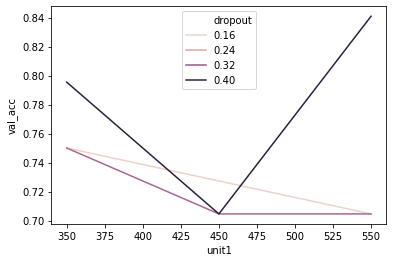

In [141]:
ax3 = sns.lineplot(x="unit1", y="val_acc", hue="dropout" ,data=summ3[summ3['unit2']==summ3['unit1']])

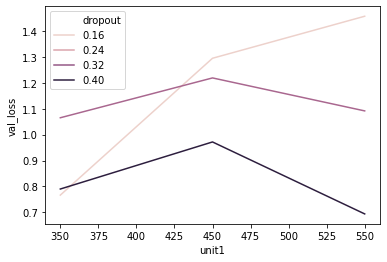

In [140]:
ax4 = sns.lineplot(x="unit1", y="val_loss", hue="dropout" ,data=summ3[summ3['unit2']==summ3['unit1']])

In [ ]:

#not relevant
def plot_history(history,name,metric):
    label_val = 'val_%s' % metric
    
    train = history.history[metric]
    test  = history.history[label_val]

    # Create count of the number of epochs
    epoch_count = range(1, len(train) + 1)

    # Visualize loss history
    plt.plot(epoch_count, train, 'r-')
    plt.plot(epoch_count, test, 'b--')
    plt.legend(['Train', 'Test'])
    plt.xlabel('Epoch')
    plt.ylabel(metric)

    plt.title('%s : %s' % (metric,name))

    plt.show()